---
# Proyecto integrador en DIGITAL HOUSE. Análisis de series temporales para predecir el valor de la acción de Microsoft. 
## Participantes: Alejandro Jait, Dinora García Santacruz y Emiliano Alvarez 
<a id="carga_de_datos"></a> 

In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Definimos parámetros globales para matplotlib.
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 16

import datetime
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data

plt.style.use('seaborn')


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Función que calcula el error cuadrático medio
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

---
# 1- Carga de Datos
<a id="carga_de_datos"></a> 


In [3]:
# Si se precisa alguna otra acción, editar esta lista.
tickers = ['MSFT']

In [4]:
start_date = '2016-01-01'
end_date = '2020-08-30'

In [5]:
df_msft = data.DataReader(tickers, data_source='yahoo', start=start_date, end=end_date)

In [6]:
df1 = pd.DataFrame(df_msft['Close'], columns=['MSFT'])

In [7]:
df1.index.rename('date', inplace=True)

In [8]:
# Dataset con precios de Acciones
#df = pd.read_csv('MSFT.csv', index_col='date', parse_dates=True)
df1.rename(columns={'MSFT' : 'value'}, inplace=True)

In [9]:
df1.shape

(1173, 1)

In [10]:
df1.tail(3)

value
date                  
2020-08-26  221.149994
2020-08-27  226.580002
2020-08-28  228.910004

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1173 entries, 2016-01-04 to 2020-08-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   1173 non-null   float64
dtypes: float64(1)
memory usage: 18.3 KB


In [12]:
df1.describe()

value
count  1173.000000
mean    102.875286
std      43.524807
min      48.430000
25%      64.639999
50%      96.070000
75%     135.160004
max     228.910004

---

In [13]:
df1['year'] = [d.year for d in df1.index]
df1['month'] = [d.strftime('%b') for d in df1.index]

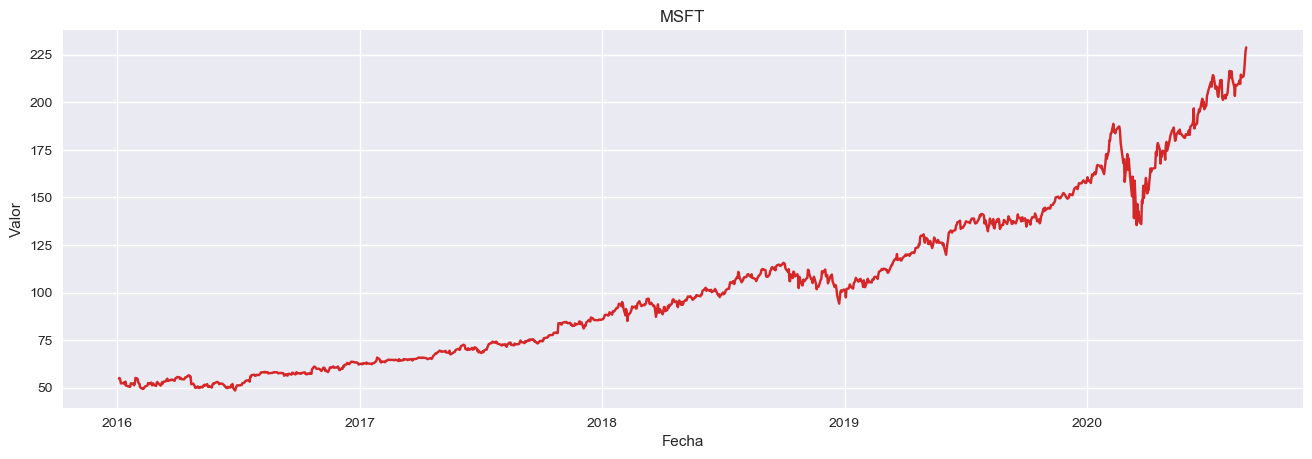

In [14]:
# Función que plotea la serie:

def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df1, x=df1.index, y=df1.value,\
        title='MSFT')

In [15]:
df1.shape

(1173, 3)


### Aquí definimos con cuántos datos nos quedamos:



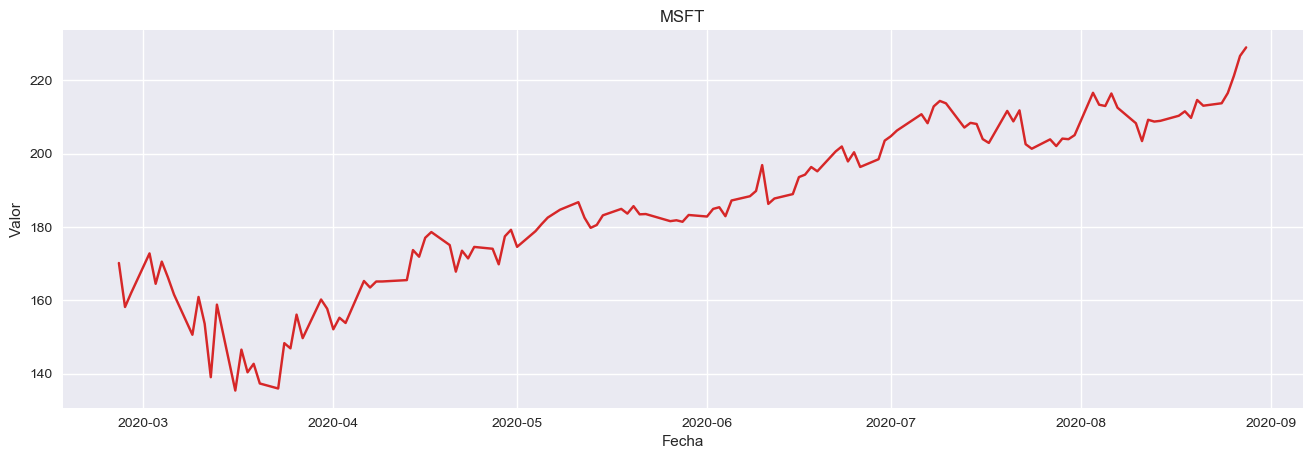

In [16]:
# seleccionamos la cantidad de datos que deseamos
df = df1.tail(130)    

plot_df(df, x=df.index, y=df.value,\
        title='MSFT')

Vamos chequear la estacionalidad de la serie a través de la ACF:

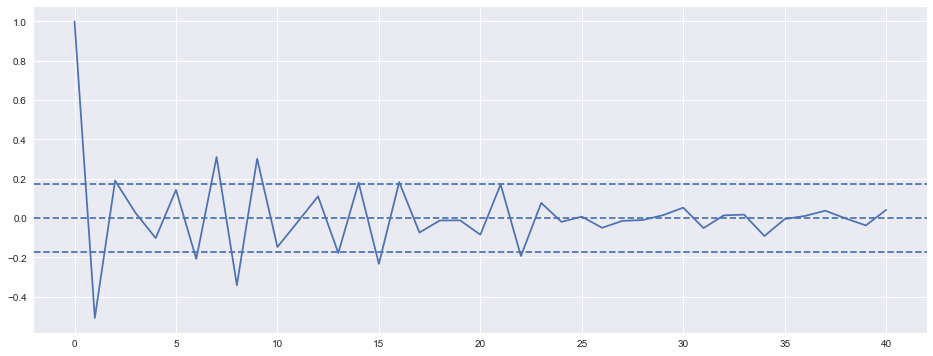

In [17]:
from statsmodels.tsa import stattools
log_valor = np.log(df['value'])
log_valor_diff = log_valor - log_valor.shift()
log_valor_diff = log_valor_diff
log_valor_diff.dropna(inplace = True)
acf_result = stattools.acf(log_valor_diff)
plt.figure(figsize=(16, 6))
plt.plot(acf_result)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_valor_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_valor_diff)),linestyle='--')

In [18]:
# variable que sea la variable de tiempo elevada al cuadrado para modelar la tendencia cuadrátic

df["timeIndex"] = pd.Series(np.arange(len(df['value'])), index=df.index)
df["timeIndex_sq"] = df["timeIndex"]**2
display(df["timeIndex"].head(3))
display(df["timeIndex_sq"].head(3))

date
2020-02-26    0
2020-02-27    1
2020-02-28    2
Name: timeIndex, dtype: int32

date
2020-02-26    0
2020-02-27    1
2020-02-28    4
Name: timeIndex_sq, dtype: int32


### Aquí separamos en TRAIN/TEST:



Vamos a hacer un split entre train y test, teniendo en cuenta que, al tratarse de una serie de tiempo, tenemos que poner *shuffle=False*.

In [19]:
test_size = 15

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=test_size, random_state=42, shuffle=False)

In [20]:
# Vemos los últimos datos del set de entrenamiento:
df_train.tail(3)

value  year month  timeIndex  timeIndex_sq
date                                                       
2020-08-05  212.940002  2020   Aug        112         12544
2020-08-06  216.350006  2020   Aug        113         12769
2020-08-07  212.479996  2020   Aug        114         12996

In [21]:
# Vemos los primeros datos del set de testeo:
df_test.head(3)

value  year month  timeIndex  timeIndex_sq
date                                                       
2020-08-10  208.250000  2020   Aug        115         13225
2020-08-11  203.380005  2020   Aug        116         13456
2020-08-12  209.190002  2020   Aug        117         13689

---
# 2- Modelos
<a id="section_media_constante"></a> 

###  2.1 - Media Constante:

In [22]:
# Calculamos el promedio:
model_mean_pred = df_train['value'].mean()

# La predicción es fija y es la misma para el set de testeo y de entrenamiento:
df_train["Mean"] = model_mean_pred
df_test["Mean"] = model_mean_pred

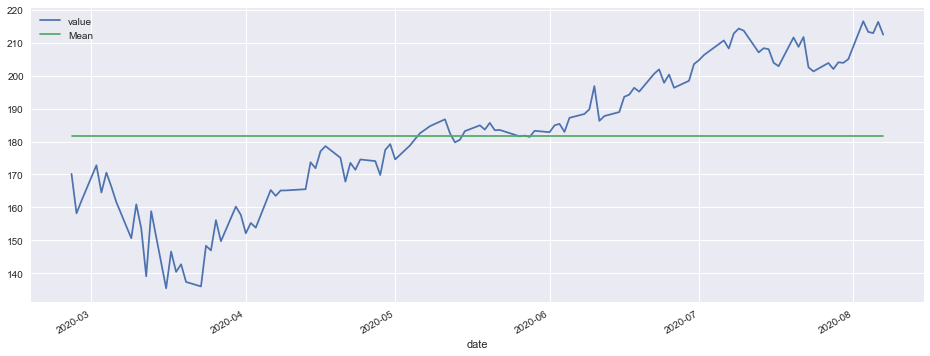

In [23]:
# Ploteamos los valores del set de entrenamiento y el modelo:
df_train.plot(kind="line", y = ["value", "Mean"], figsize=(16, 6));

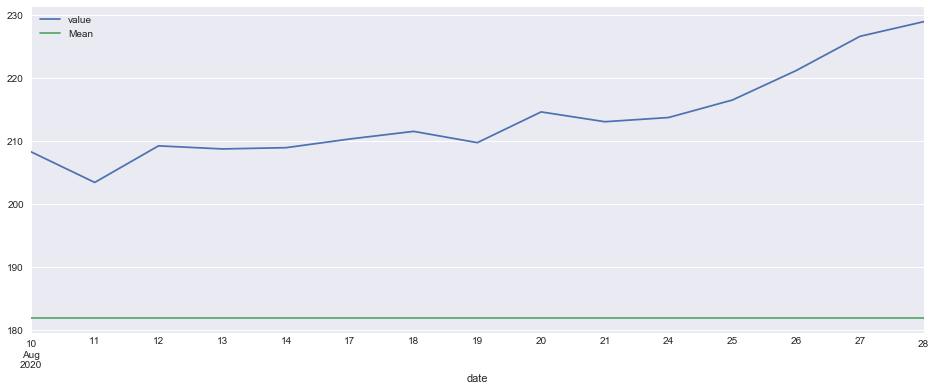

In [24]:
# Ploteamos los valores del set de testeo y el modelo
df_test.plot(kind="line", y = ["value", "Mean"], figsize=(16, 6));

In [25]:
# Obtenemos el error cuadrático medio
model_mean_RMSE = RMSE(df_test.Mean, df_test.value)
model_mean_RMSE

32.5176462649153

In [26]:
# Guardamos el resultado en un DataFrame:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Mean"
df_Results.loc[0, "RMSE"] = model_mean_RMSE
df_Results.head()

Model     RMSE
0  Mean  32.5176

---
<a id="section_random_walk"></a> 
### 2.2 - Random Walk:

Generamos el desplazamiento de nuestro nuestro target en el set de entrenamiento (lag=1):

In [27]:
df_train["valueShift1"] = df_train.value.shift()

# La primera observación nos va a quedar en nan, la reemplazamos por el valor siguente:
df_train["valueShift1"].fillna(method='bfill', inplace=True)
df_train.head(3)

value  year month  timeIndex  timeIndex_sq     Mean  \
date                                                                   
2020-02-26  170.169998  2020   Feb          0             0  181.826   
2020-02-27  158.179993  2020   Feb          1             1  181.826   
2020-02-28  162.009995  2020   Feb          2             4  181.826   

            valueShift1  
date                     
2020-02-26   170.169998  
2020-02-27   170.169998  
2020-02-28   158.179993

Generamos el desplazamiento de nuestro nuestro target en el set de testeo (lag=1):

In [28]:
df_test["valueShift1"] = df_test.value.shift()

# Podemos reemplazar el primer nan con el último valor del set de entrenamiento:
df_test.iloc[0, df_test.shape[1] - 1] = df_train.iloc[-1,0]
df_test.head(3)

value  year month  timeIndex  timeIndex_sq     Mean  \
date                                                                   
2020-08-10  208.250000  2020   Aug        115         13225  181.826   
2020-08-11  203.380005  2020   Aug        116         13456  181.826   
2020-08-12  209.190002  2020   Aug        117         13689  181.826   

            valueShift1  
date                     
2020-08-10   212.479996  
2020-08-11   208.250000  
2020-08-12   203.380005

Vamos a hacer un scatterplot entre las observaciones y su lag de un período:

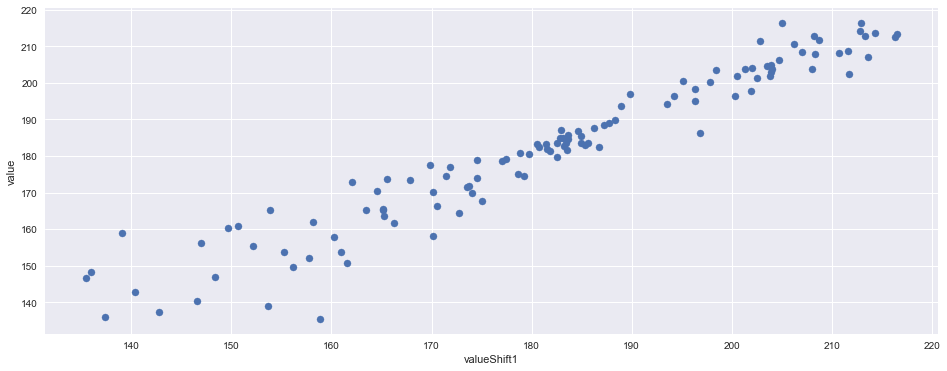

In [29]:
df_train.plot(kind= "scatter", y = "value", x = "valueShift1", s = 50, figsize=(16, 6));

Ploteamos la diferencia entre nuestro target y el lag de un período:

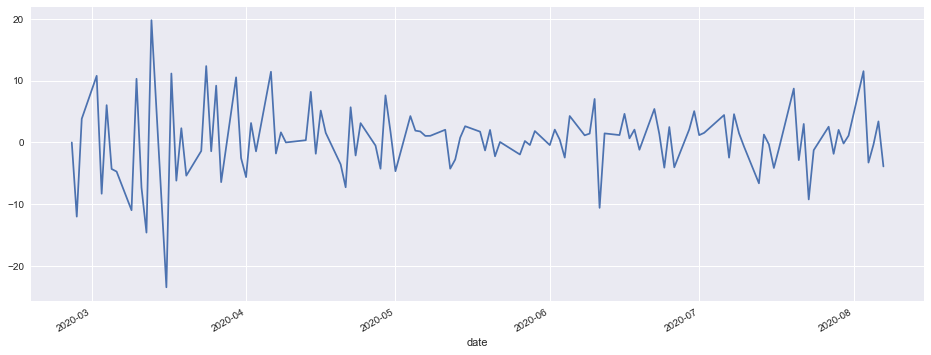

In [30]:
df_train["valueDiff"] = df_train.value - df_train.valueShift1
df_train.valueDiff.plot(figsize=(16, 6));

Como la perturbación aleatoria tiene media igual a cero, la predicción del Random Walk va a ser el valor del lag de un período:

$$ Y_t = Y_{t-1} $$

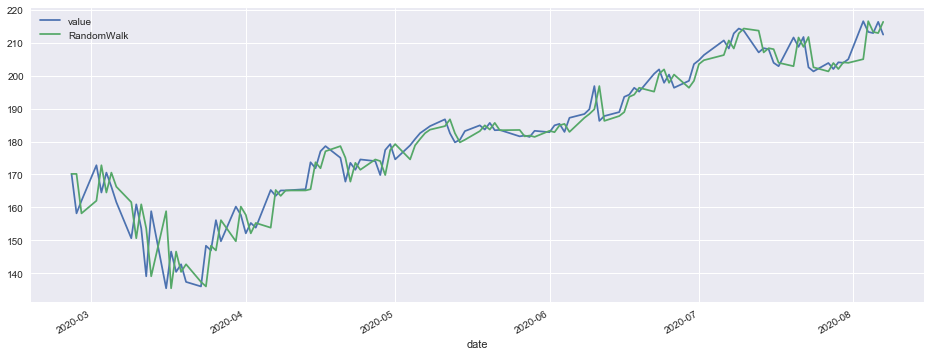

In [31]:
df_train["RandomWalk"] = df_train.valueShift1
df_train.plot(kind="line", y = ["value", "RandomWalk"], figsize=(16, 6));

La predicción sobre el set de testeo es simplemente la última observación registrada en el set de entrenamiento. 

In [32]:
df_test["RandomWalk"] = pd.Series(df_train["value"][-1], index=df_test.index)

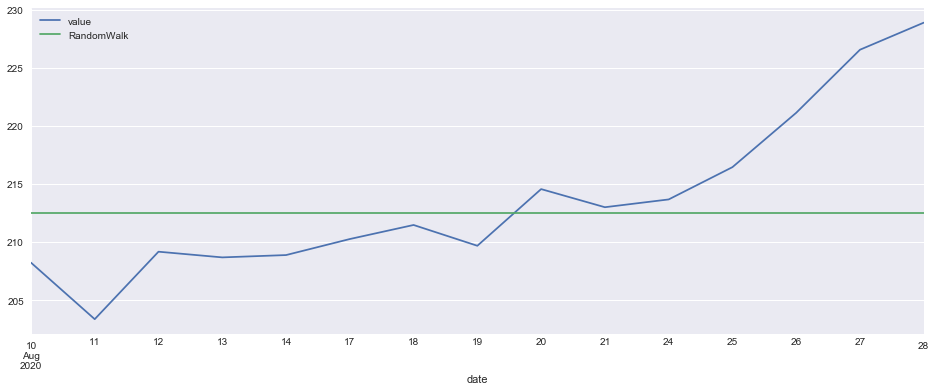

In [33]:
df_test.plot(kind="line", y = ["value", "RandomWalk"], figsize=(16, 6));

In [34]:
# Calculamos el RMSE y almacenamos los resultados
df_Results.loc[1, "Model"] = "Random Walk"
df_Results.loc[1, "RMSE"] = RMSE(df_test.RandomWalk, df_test.value)
df_Results

Model     RMSE
0         Mean  32.5176
1  Random Walk  6.91949

---
<a id="section_tendencia_lineal"></a> 
### 2.3 - Tendencia Lineal

In [35]:
# value = a.t + b
model_linear = smf.ols('value ~ timeIndex', data = df_train).fit()

In [36]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     701.3
Date:                Fri, 04 Sep 2020   Prob (F-statistic):           2.80e-50
Time:                        22:08:22   Log-Likelihood:                -399.62
No. Observations:                 115   AIC:                             803.2
Df Residuals:                     113   BIC:                             808.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    148.3978      1.461    101.586      0.000     145.504     151.292
timeIndex      0.5865      0.022     26.481      0.000       0.543       0.630
==============================================================================
Omnibus:                        5.359   Durbin-Watson:                   0.544
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                7.271
Skew:                          -0.150   Prob(JB):                       0.0264
Kurtosis:                       4.194   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Veamos las predicciones del modelo sobre el set de entrenamiento:

In [37]:
df_train["LinearTrend"] = model_linear.predict(df_train.timeIndex)

Ploteamos los resultados de la predicción:

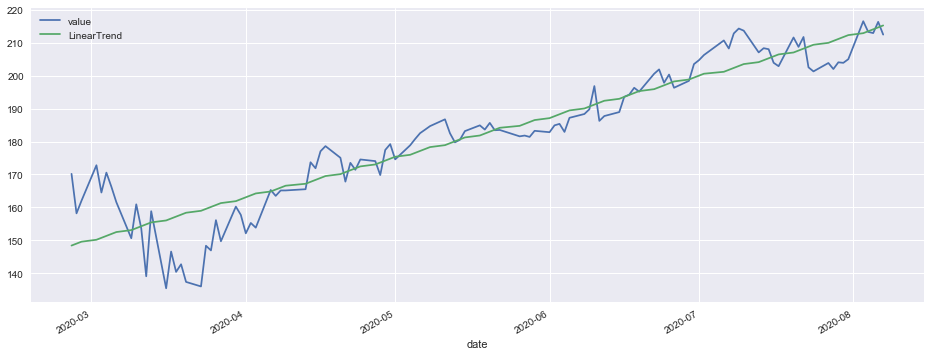

In [38]:
df_train.plot(kind = "line", y = ["value","LinearTrend"], figsize=(16, 6));

Veamos las predicciones del modelo sobre el set de testeo:

In [39]:
df_test["LinearTrend"] = model_linear.predict(df_test.timeIndex)

Ploteamos los resultados de la predicción:

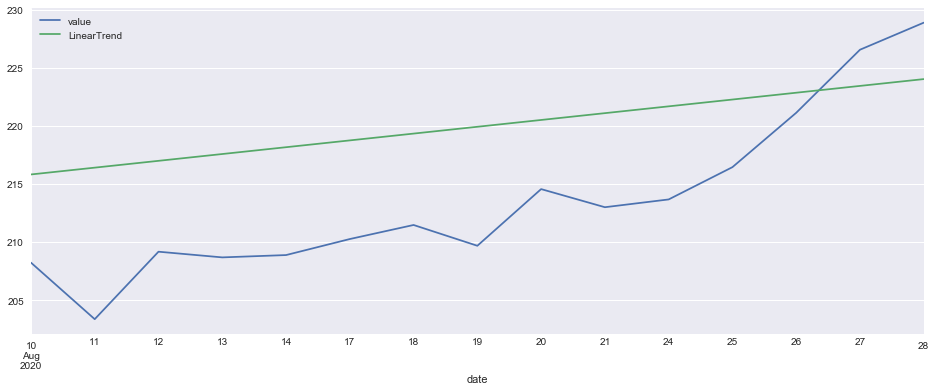

In [40]:
df_test.plot(kind = "line", y = ["value","LinearTrend"], figsize=(16, 6));

Calculamos el error y añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior:

In [41]:
df_Results.loc[2, "Model"] = "LinearTrend"
df_Results.loc[2, "RMSE"] = RMSE(df_test.LinearTrend, df_test.value)
df_Results

Model     RMSE
0         Mean  32.5176
1  Random Walk  6.91949
2  LinearTrend   7.8698

---
<a id="section_tendencia_cuadratica"></a> 
### 2.4 - Tendencia Cuadrática

In [42]:
# Ahora fiteamos nuestro modelo de regresión lineal entre value y timeIndex + timeIndex_sq
model_quadratic = smf.ols('value ~ timeIndex + timeIndex_sq', data = df_train).fit()

In [43]:
# value = a*t + b*t2 * c

# Observamos el summary del modelo:
model_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     349.0
Date:                Fri, 04 Sep 2020   Prob (F-statistic):           7.58e-49
Time:                        22:08:22   Log-Likelihood:                -399.41
No. Observations:                 115   AIC:                             804.8
Df Residuals:                     112   BIC:                             813.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      149.4338      2.173     68.758      0.000     145.128     153.740
timeIndex        0.5315      0.088      6.032      0.000       0.357       0.706
timeIndex_sq     0.0005      0.001      0.645      0.520      -0.001       0.002
==============================================================================
Omnibus:                        6.075   Durbin-Watson:                   0.546
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                7.249
Skew:                          -0.289   Prob(JB):                       0.0267
Kurtosis:                       4.086   Cond. No.                     1.73e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Veamos las predicciones del modelo sobre el set de entrenamiento:

In [44]:
# PREDECIMOS sobre los datos de TRAIN:
df_train["QuadraticTrend"] = model_quadratic.predict(df_train[["timeIndex",\
                                                      "timeIndex_sq"]])

Ploteamos los resultados de la predicción:

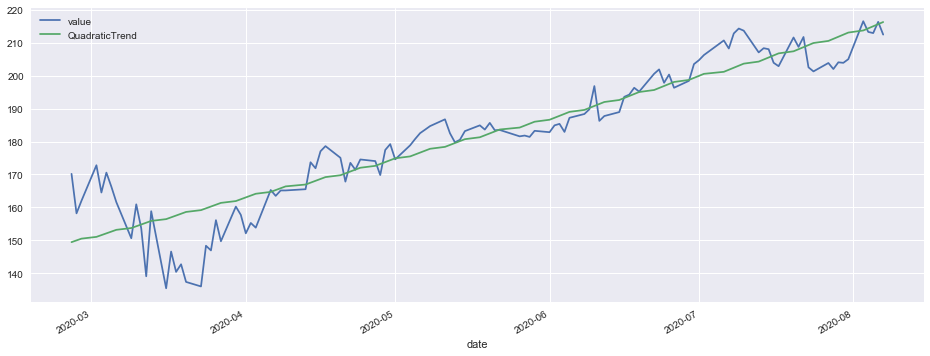

In [45]:
df_train.plot(kind = "line", y = ["value","QuadraticTrend"], figsize=(16, 6));

Veamos las predicciones del modelo sobre el set de testeo:

In [46]:
# PREDECIMOS sobre los datos de TEST:
df_test["QuadraticTrend"] = model_quadratic.predict(df_test[["timeIndex",\
                                                      "timeIndex_sq"]])

Ploteamos los resultados de la predicción:

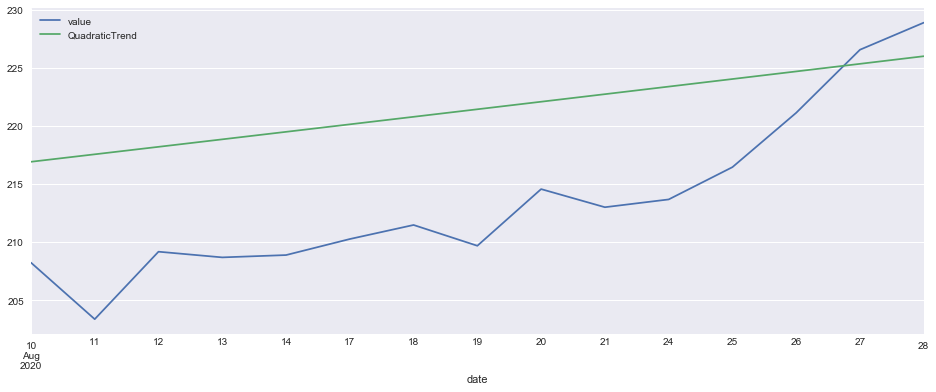

In [47]:
df_test.plot(kind = "line", y = ["value", "QuadraticTrend"], figsize=(16, 6));

Agregamos las predicciones al DataFrame de testeo:

In [48]:
# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior
df_Results.loc[3, "Model"] = "QuadraticTrend"
df_Results.loc[3, "RMSE"] = RMSE(df_test.QuadraticTrend, df_test.value)
df_Results

Model     RMSE
0            Mean  32.5176
1     Random Walk  6.91949
2     LinearTrend   7.8698
3  QuadraticTrend  9.02761

---
<a id="section_tendencia_transformacion_log"></a> 
### 2.5 - Tendencia cuadrática con transformación logarítmica

In [49]:
df_train['log_value'] = np.log(df_train['value'])
df_test['log_value'] = np.log(df_test['value'])

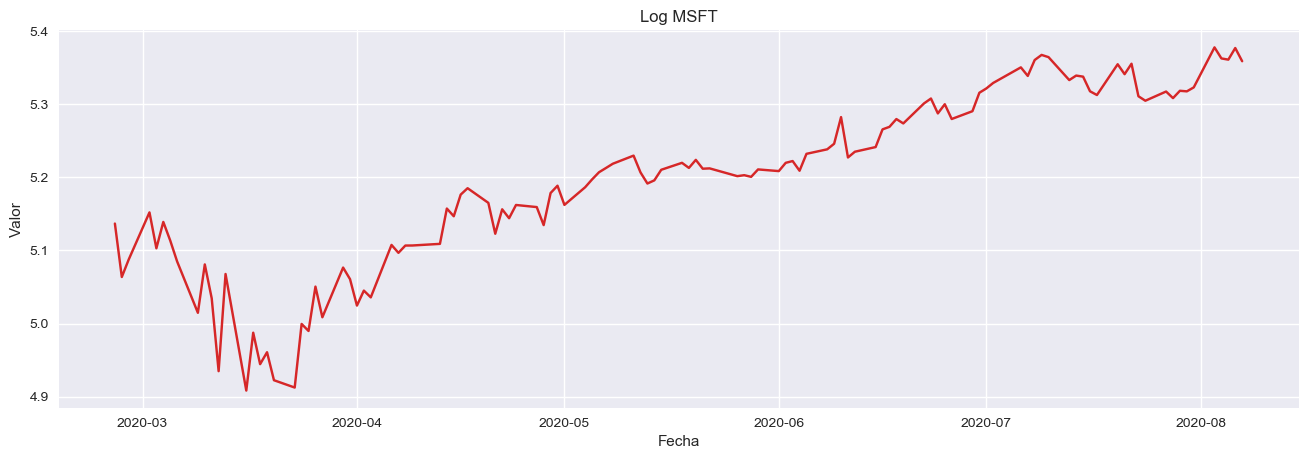

In [50]:
plot_df(df_train, x=df_train.index, y=df_train['log_value'],\
    title='Log MSFT')

Ahora fiteamos nuestro modelo de regresión lineal entre log_value y timeIndex:

In [51]:
# log_value = a*t + b
model_log = smf.ols('log_value ~ timeIndex + timeIndex_sq', data = df_train).fit()

Veamos el summary del modelo:

In [52]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     285.4
Date:                Fri, 04 Sep 2020   Prob (F-statistic):           1.08e-44
Time:                        22:08:24   Log-Likelihood:                 185.79
No. Observations:                 115   AIC:                            -365.6
Df Residuals:                     112   BIC:                            -357.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.0060      0.013    373.563      0.000       4.979       5.033
timeIndex        0.0035      0.001      6.381      0.000       0.002       0.005
timeIndex_sq -1.718e-06   4.61e-06     -0.372      0.710   -1.09e-05    7.42e-06
==============================================================================
Omnibus:                       13.224   Durbin-Watson:                   0.554
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.415
Skew:                          -0.497   Prob(JB):                     1.36e-05
Kurtosis:                       4.920   Cond. No.                     1.73e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Veamos las predicciones:

In [53]:
# cuando haga las predicciones el modelo va a devolver en LOGARITMO, con lo cual luego voy a antirtnsformar
# antitransformará haciendo el Exponente
df_train['model_log'] = model_log.predict(df_train[["timeIndex", "timeIndex_sq"]])
df_test['model_log'] = model_log.predict(df_test[["timeIndex", "timeIndex_sq"]])

Almacenamos las predicciones del modelo en el set de entrenamiento y testeo luego de haber realizado back-transformation:

In [54]:
df_train['back_model_log'] = np.exp(df_train['model_log'])
df_test['back_model_log'] = np.exp(df_test['model_log'])

In [55]:
df_test.head(3)

value  year month  timeIndex  timeIndex_sq     Mean  \
date                                                                   
2020-08-10  208.250000  2020   Aug        115         13225  181.826   
2020-08-11  203.380005  2020   Aug        116         13456  181.826   
2020-08-12  209.190002  2020   Aug        117         13689  181.826   

            valueShift1  RandomWalk  LinearTrend  QuadraticTrend  log_value  \
date                                                                          
2020-08-10   212.479996  212.479996   215.840696      216.932177   5.338739   
2020-08-11   208.250000  212.479996   216.427156      217.575093   5.315076   
2020-08-12   203.380005  212.479996   217.013617      218.218974   5.343243   

            model_log  back_model_log  
date                                   
2020-08-10   5.381952      217.446376  
2020-08-11   5.385022      218.114890  
2020-08-12   5.388088      218.784709

Ploteamos los resultados de la predicción en el set de entrenamiento **sin** back-transformation:


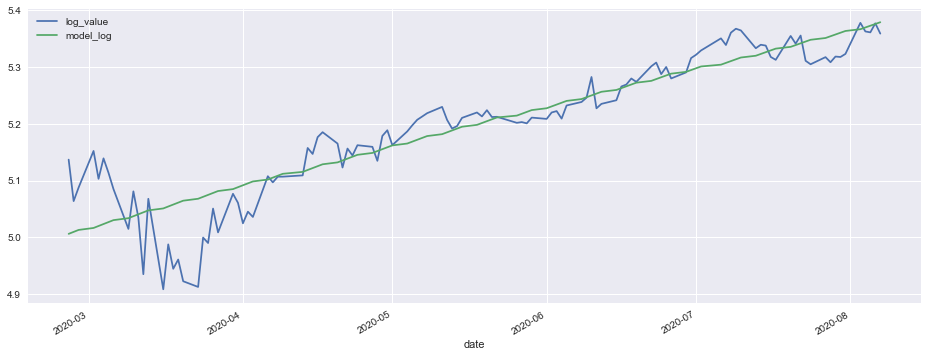

In [56]:
df_train.plot(kind = "line", y = ['log_value', 'model_log'], figsize=(16, 6));

Ploteamos los resultados de la predicción en el set de entrenamiento **con** back-transformation:

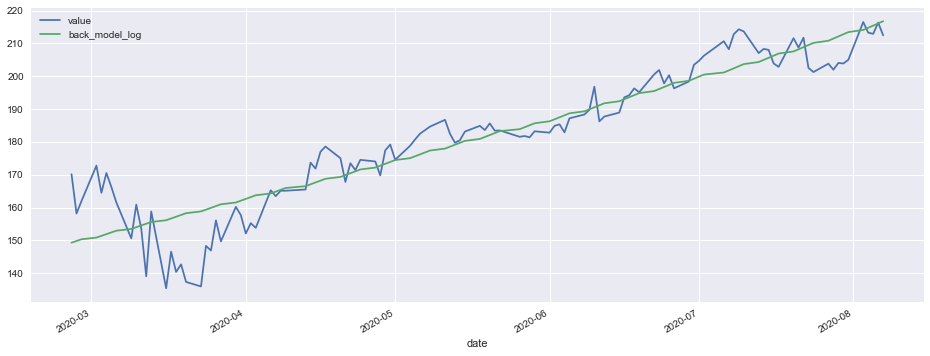

In [57]:
df_train.plot(kind = "line", y = ['value', 'back_model_log'], figsize=(16, 6));

Ploteamos los resultados de la predicción en el set de testeo **sin** back-transformation:

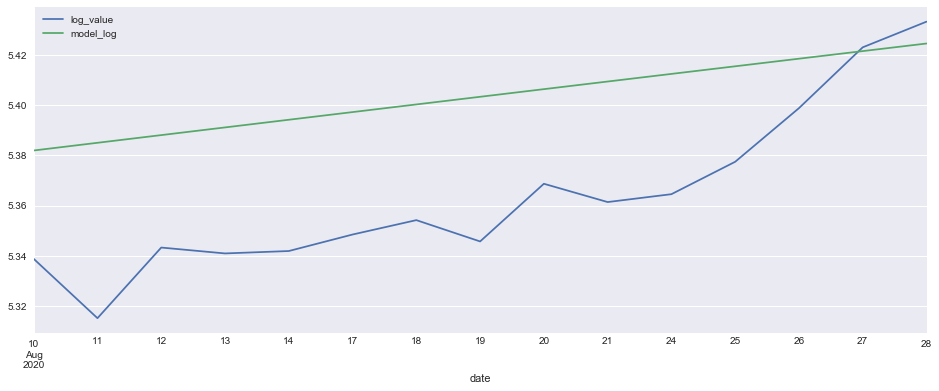

In [58]:
df_test.plot(kind = "line", y = ['log_value', 'model_log'], figsize=(16, 6));

Ploteamos los resultados de la predicción en el set de testeo **con** back-transformation:

In [59]:
# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior:
df_Results.loc[4, "Model"] = "Transf Log"
df_Results.loc[4, "RMSE"] = RMSE(df_test['back_model_log'], df_test['value'])
df_Results

Model     RMSE
0            Mean  32.5176
1     Random Walk  6.91949
2     LinearTrend   7.8698
3  QuadraticTrend  9.02761
4      Transf Log  9.60369

---
<a id="section_tendencia_transformacion_log_estacionalidad"></a> 
### 2.6 - Tendencia con transformación logarítmica + estacionalidad mensual

##### Nuestra serie no tiene estacionalidad, por lo que el código no será utilizado. Pero queda preparado para otra serie.

In [60]:
con_dummies = False

if con_dummies:
    model_log_est = smf.ols('log_value ~ timeIndex + Aug + Jul + Jun + May',\
                              data = df_train).fit()
    model_log_est.summary()

    df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex", \
                                                  "Aug", "Jul", "Jun", "May"]])

    df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex", \
                                                  "Aug", "Jul", "Jun", "May"]])

    df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
    df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

    df_train.plot(kind = "line", y = ['log_value', 'model_log_est'], figsize=(16, 6));
    df_train.plot(kind = "line", y = ['value', 'back_model_log_est'], figsize=(16, 6));
    df_test.plot(kind = "line", y = ['log_value', 'model_log_est'], figsize=(16, 6));
    df_test.plot(kind = "line", y = ['value', 'back_model_log_est'], figsize=(16, 6));

    df_Results.loc[5, "Model"] = "Transf Log + est"
    df_Results.loc[5, "RMSE"] = RMSE(df_test['back_model_log_est'], df_test['value'])
    df_Results

---
<a id="section_exponential_smoothing"></a> 
### 2.7 - Single Exponential Smoothing

In [61]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt

In [62]:
from sklearn.model_selection import TimeSeriesSplit 

Definimos una función que aplica time series cross validation para el modelo single exponential smoothing:

In [63]:
from sklearn.metrics import mean_squared_error

def timeseriesCVscore_exp_smoot(alpha, series):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # creamos un array de errores:
    errors = []
    
    values = series.values
    
    # instanciamos el objeto que realiza el tscv:
    tscv = TimeSeriesSplit(n_splits=5) 
    
    # Aplicamos cross validation:

    for train, test in tscv.split(values):
    
        model = SimpleExpSmoothing(values[train]).fit(smoothing_level=alpha,\
                                                             optimized=True)
                
        predictions = model.forecast(len(test))
        actual = values[test]
    
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    
    return (np.mean(np.array(errors)))  # devuelve el valor medio de los Errores para las 5 CV Folds

In [64]:
# VA A HACER CROSS-VALIDATION y una especie de GridSearch para encontrar el mejor ALPHA
alphas = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
errors = []
RMSE_errors = []

for alpha in alphas:
    error  = timeseriesCVscore_exp_smoot(alpha, df_train.value) # hace el CV para cada Alpha
    errors.append(error)
        
print('Alpha óptimo:', alphas[np.argmin(errors)]) # devuelve el alpha para el cual el error fué mínimo

Alpha óptimo: 0.9


In [65]:
# Entrenamos el modelo optimizado:
model_simp_exp_smoothing = SimpleExpSmoothing(df_train.value).fit(smoothing_level=alphas[np.argmin(errors)],\
                                                             optimized=True)

In [66]:
model_simp_exp_smoothing.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:                  endog   No. Observations:                  115
Model:             SimpleExpSmoothing   SSE                           3512.607
Optimized:                       True   AIC                            397.206
Trend:                           None   BIC                            402.696
Seasonal:                        None   AICC                           397.570
Seasonal Periods:                None   Date:                 Fri, 04 Sep 2020
Box-Cox:                        False   Time:                         22:08:25
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9000000                alpha                False
initial_level              169.01931                  l.0                 True
------------------------------------------------------------------------------
"""

In [67]:
predicc = model_simp_exp_smoothing.forecast(len(df_test['value']))
predicc.index = df_test.index
predicc

date
2020-08-10    212.833455
2020-08-11    212.833455
2020-08-12    212.833455
2020-08-13    212.833455
2020-08-14    212.833455
2020-08-17    212.833455
2020-08-18    212.833455
2020-08-19    212.833455
2020-08-20    212.833455
2020-08-21    212.833455
2020-08-24    212.833455
2020-08-25    212.833455
2020-08-26    212.833455
2020-08-27    212.833455
2020-08-28    212.833455
dtype: float64

Almacenamos las predicciones del modelo en el set de entrenamiento y test:

In [68]:
fiteados = model_simp_exp_smoothing.fittedvalues
fiteados.index = df_train.index
df_train["Simple_Smoothing"] = fiteados

predicc = model_simp_exp_smoothing.forecast(len(df_test['value']))
predicc.index = df_test.index
df_test["Simple_Smoothing"] = predicc

In [69]:
model_simp_smo_RMSE = RMSE(df_test["Simple_Smoothing"], df_test.value)
model_simp_smo_RMSE

6.870142253657388

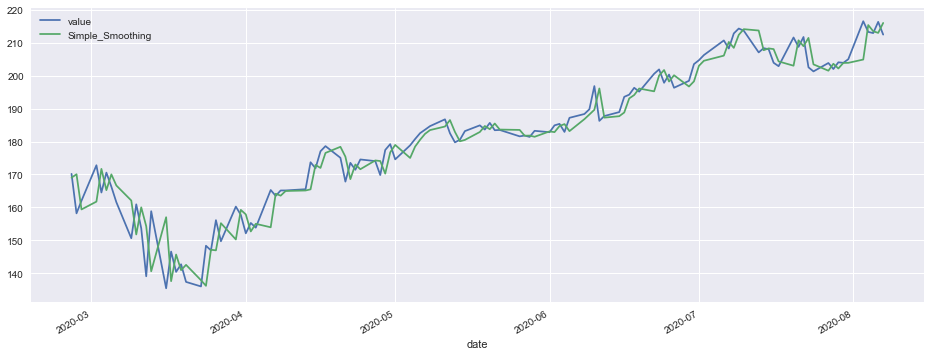

In [70]:
df_train.plot(kind = "line", y = ["value", "Simple_Smoothing"], figsize=(16, 6))


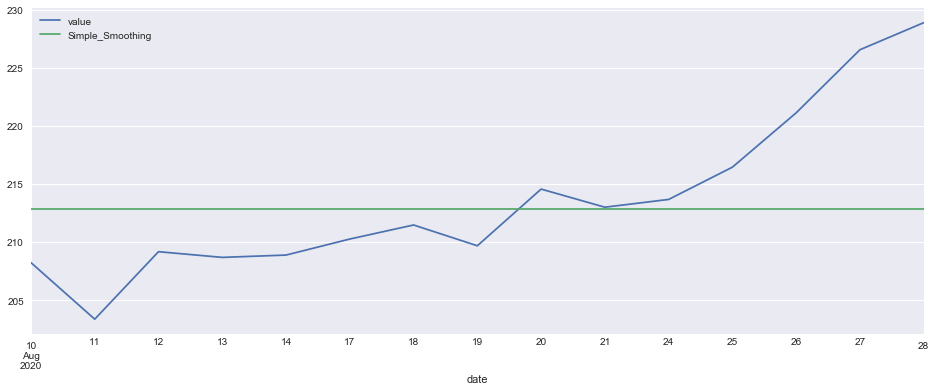

In [71]:
df_test.plot(kind="line", y = ["value", "Simple_Smoothing"], figsize=(16, 6));

In [72]:
# Calculamos el RMSE y almacenamos los resultados
df_Results.loc[6, "Model"] = "Simple Smoothing"
df_Results.loc[6, "RMSE"] = RMSE(df_test["Simple_Smoothing"], df_test.value)
df_Results

Model     RMSE
0              Mean  32.5176
1       Random Walk  6.91949
2       LinearTrend   7.8698
3    QuadraticTrend  9.02761
4        Transf Log  9.60369
6  Simple Smoothing  6.87014

---
<a id="section_exponential_smoothing"></a> 
### 2.8 - Exponential Smoothing:

In [73]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [74]:
from sklearn.metrics import mean_squared_error

In [75]:
from sklearn.metrics import mean_squared_error

def timeseriesCVscore_exp_smoot_2(alpha_, trend_, series):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # creamos un array de errores:
    errors = []
    resumen = []
    temp = ()
    
    values = series.values
    
    # instanciamos el objeto que realiza el tscv:
    tscv = TimeSeriesSplit(n_splits=5) 
    
    # Aplicamos cross validation:

    for train, test in tscv.split(values):
        for trend_f in trend_:
            for alpha in alpha_:    
                model = ExponentialSmoothing(values[train], 
                                            damped=False, 
                                            dates=None,
                                            freq=None,                                  
                                            missing='none', 
                                            trend=trend_f # trend : {"add", "mul", "additive", "multiplicative", None}
                                                      ).fit(smoothing_level=alpha,\
                                                                        optimized=True)

                predictions = model.forecast(len(test))
                actual = values[test]

                error = mean_squared_error(predictions, actual)
                errors.append(error)
                
                temp = (error, trend_f, alpha)
                resumen.append(temp)
        
    return (errors, resumen)  # devuelve el valor medio de los Errores para las 5 CV Folds

In [76]:
trend_ = ["add", "mul", "additive", "multiplicative"]
alphas = [0.4, 0.5, 0.6, 0.7]
resu=[]

errors, resu = timeseriesCVscore_exp_smoot_2(alphas, trend_, df_train.value) # hace el CV para cada Alpha

print('Modelo óptimo:', resu[np.argmin(errors)]) # devuelve el alpha para el cual el error fué mínimo

Modelo óptimo: (9.083988287642667, 'add', 0.4)


In [77]:
# Entrenamos el modelo optimizado:
model_exp_smoothing = ExponentialSmoothing(df_train["value"], 
                                  damped=False, 
                                  dates=None,
                                  freq=None,                                  
                                  missing='none', 
                                  trend= resu[np.argmin(errors)][1]
                                          ).fit(smoothing_level=resu[np.argmin(errors)][2], 
                                                             optimized=True)

In [78]:
model_exp_smoothing.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                    endog   No. Observations:                  115
Model:             ExponentialSmoothing   SSE                           3229.194
Optimized:                         True   AIC                            391.531
Trend:                         Additive   BIC                            402.511
Seasonal:                          None   AICC                           392.309
Seasonal Periods:                  None   Date:                 Fri, 04 Sep 2020
Box-Cox:                          False   Time:                         22:08:25
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.4000000                alpha                False
smoothing_slope            0.1812136                 beta                 True
initial_level              168.58353                  l.0                 True
initial_slope               0.000000                  b.0                 True
------------------------------------------------------------------------------
"""

In [79]:
predicc = model_exp_smoothing.forecast(len(df_test['value']))
predicc.index = df_test.index

Almacenamos las predicciones del modelo en el set de entrenamiento y test:

In [80]:
fiteados = model_exp_smoothing.fittedvalues
fiteados.index = df_train.index
df_train["Exp_Smoothing"] = fiteados

predicc = model_exp_smoothing.forecast(len(df_test['value']))
predicc.index = df_test.index
df_test["Exp_Smoothing"] = predicc

In [81]:
model_exp_smo_RMSE = RMSE(df_test["Exp_Smoothing"], df_test.value)
model_exp_smo_RMSE

9.796729137265952

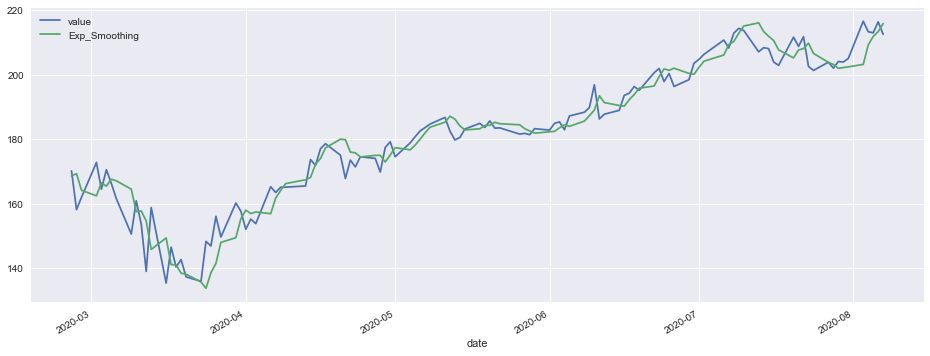

In [82]:
df_train.plot(kind = "line", y = ["value", "Exp_Smoothing"], figsize=(16, 6))


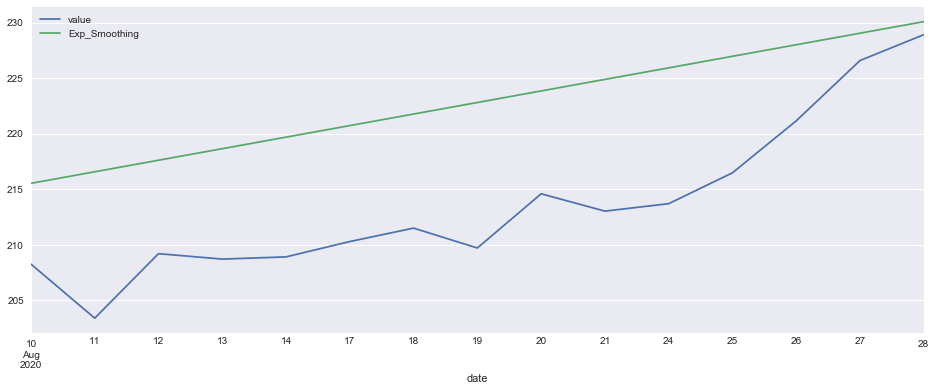

In [83]:
df_test.plot(kind="line", y = ["value", "Exp_Smoothing"], figsize=(16, 6));

In [84]:
# Calculamos el RMSE y almacenamos los resultados
df_Results.loc[7, "Model"] = "Exponential Smoothing"
df_Results.loc[7, "RMSE"] = RMSE(df_test["Exp_Smoothing"], df_test.value)
df_Results

Model     RMSE
0                   Mean  32.5176
1            Random Walk  6.91949
2            LinearTrend   7.8698
3         QuadraticTrend  9.02761
4             Transf Log  9.60369
6       Simple Smoothing  6.87014
7  Exponential Smoothing  9.79673

In [85]:
df_test.columns.values

array(['value', 'year', 'month', 'timeIndex', 'timeIndex_sq', 'Mean',
       'valueShift1', 'RandomWalk', 'LinearTrend', 'QuadraticTrend',
       'log_value', 'model_log', 'back_model_log', 'Simple_Smoothing',
       'Exp_Smoothing'], dtype=object)

#### Comparativa de nuestros modelos para la Tendencia

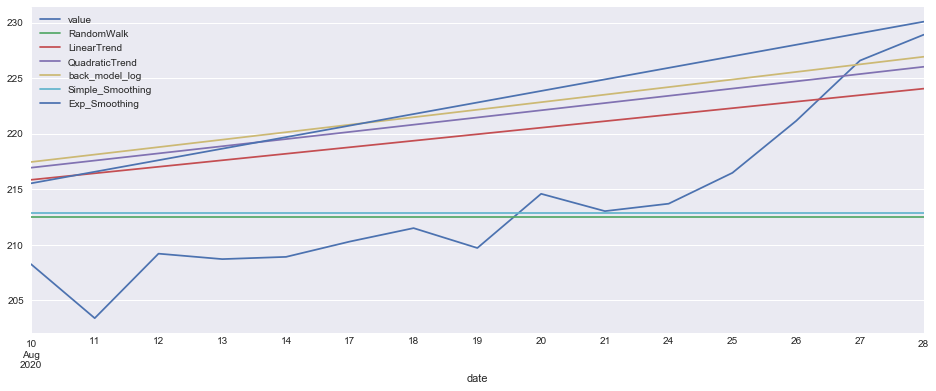

In [86]:
# Ploteamos las mejores estimaciones de la tendencia
df_test.plot(kind = "line", y = ["value", 
       'RandomWalk', 'LinearTrend', 'QuadraticTrend',
       'back_model_log', 'Simple_Smoothing',
       'Exp_Smoothing'], figsize=(16, 6));

---
<a id="section_modelos_ciclos"></a> 
###  3- Modelos de Ciclos para Series de Tiempo

<a id="section_series_estacionarias"></a> 
### 3.1- Series Estacionarias (modelado de nuestra serie original menos la tendencia seleccionada)

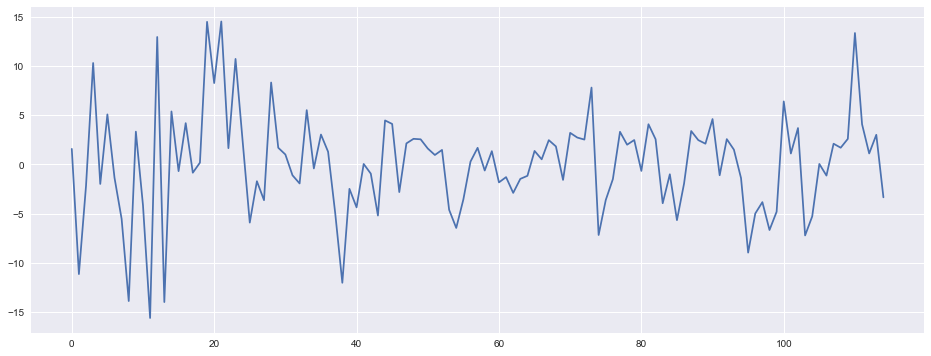

In [87]:
res_model = df_train['value'] - df_train["Exp_Smoothing"]
plt.figure(figsize=(16, 6))
plt.plot(df_train.timeIndex, res_model, '-');

Aplicamos el test de Dickey-Fuller al resíduo:

In [88]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -4.447032
p-value: 0.000245
Valor crítico 1%: -3.49
Valor crítico 5%: -2.89
Valor crítico 10%: -2.58


Podemos rechazar la $H_0$. Avanzamos con el modelado de los ciclos de los residuos del modelo:

---
<a id="section_modelo_arima"></a> 
### 3.1.1 - Modelo ARIMA

In [89]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Vamos a definir una función que va a plotear una serie y nos va a dar información sobre su estacionariedad y sobre sus ACF y PACF:

In [90]:
def tsplot(y, lags=None, title='', figsize=(16, 6)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x1cd68bee388>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cd6836f388>)

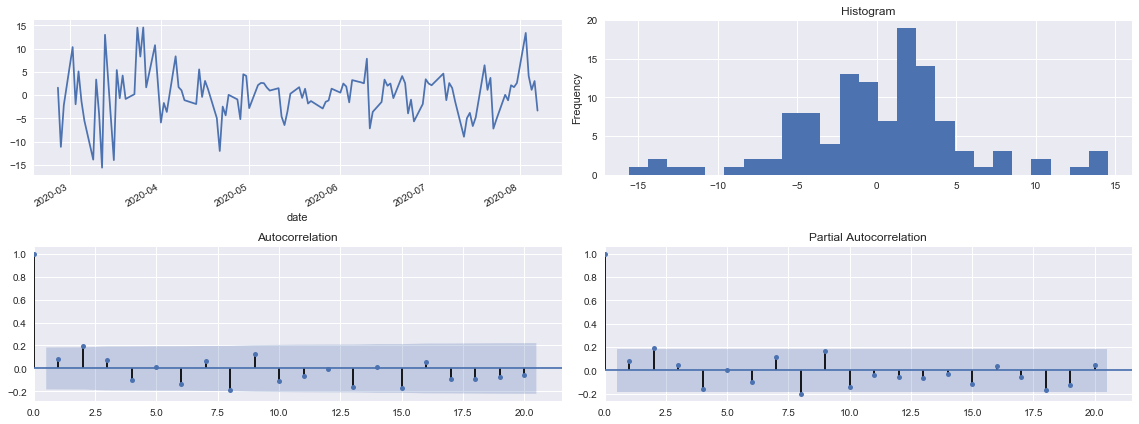

In [91]:
# Corremos la función con nuestra serie res_log:
tsplot(res_model, lags=20)

Se observa que la serie es ruido blanco con lo cual no tiene sentido aplicar ARIMA. Dejamos el código solo a modo de ejemplo.

In [92]:
# Importamos el modelo ARIMA de statsmodels
from statsmodels.tsa.arima_model import ARIMA

In [93]:
model_ARIMA = ARIMA(res_model, order=(1, 0, 1))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

date
2020-02-26    0.114917
2020-02-27    0.296939
2020-02-28   -1.107131
2020-03-02   -0.740904
2020-03-03    0.864055
dtype: float64

Hacemos un print de los resultados:

In [94]:
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  115
Model:                     ARMA(1, 1)   Log Likelihood                -353.741
Method:                       css-mle   S.D. of innovations              5.243
Date:                Fri, 04 Sep 2020   AIC                            715.482
Time:                        22:08:28   BIC                            726.461
Sample:                             0   HQIC                           719.938
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1149      0.626      0.184      0.854      -1.111       1.341
ar.L1.y        0.6008      0.254      2.365      0.018       0.103       1.099
ma.L1.y       -0.4869      0.269     -1.807      0.0

Ploteamos la serie res_model y las estimaciones del modelo:

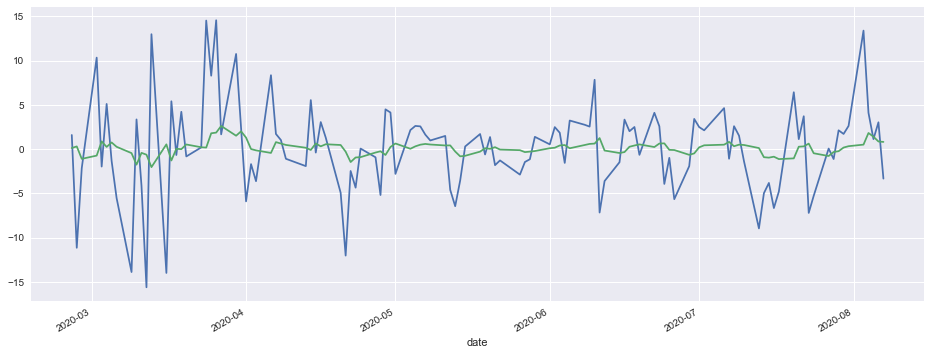

In [95]:
plt.figure(figsize=(16,6))
res_model.plot()
results_ARIMA.fittedvalues.plot();

Analizamos los residuos del modelo ARIMA:

In [96]:
res_ARIMA =  results_ARIMA.fittedvalues - res_model

(<matplotlib.axes._subplots.AxesSubplot at 0x1cd67b4e248>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cd67bdeec8>)

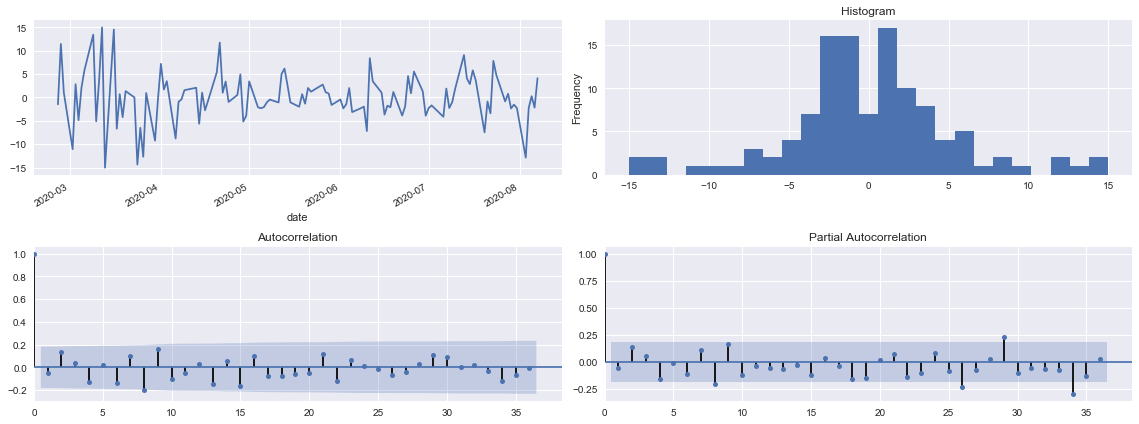

In [97]:
tsplot(res_ARIMA.dropna(), lags=36)

No parecería haber más estructura en los resíduos que podamos capturar. Nuestro resíduo ahora es ruido blanco.

Con el método forecast() podemos hacer predicciones out-of-sample:

In [98]:
predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test['value']), alpha=0.05)

Incorporamos el efecto cíclico a nuestro modelo:

In [99]:
df_train['model_ARIMA'] = df_train["Exp_Smoothing"] + results_ARIMA.fittedvalues
df_test['model_ARIMA'] = df_test["Exp_Smoothing"] + predictions_ARIMA

Ploteamos el Modelo:

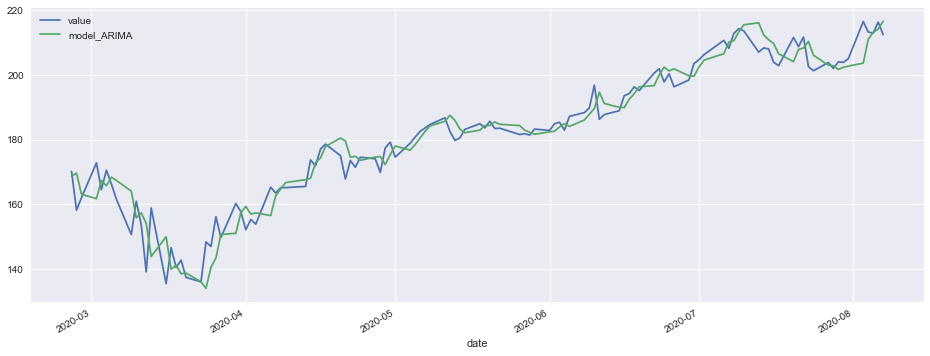

In [100]:
df_train.plot(kind = "line", y = ['value', 'model_ARIMA'], figsize=(16, 6));

Ploteamos la Predicción:

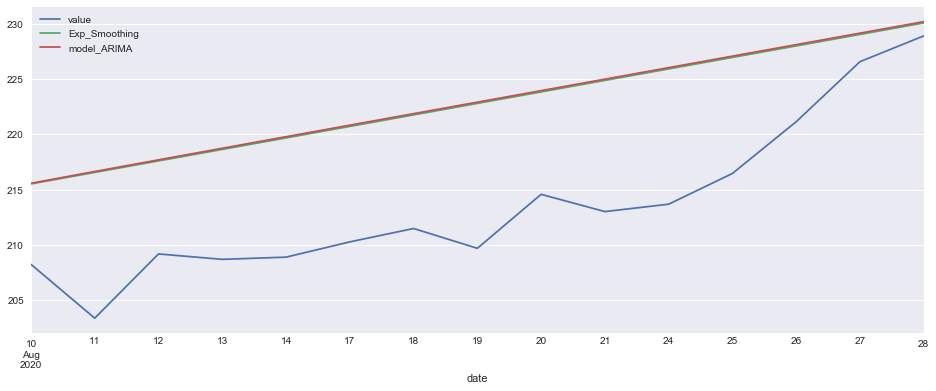

In [101]:
df_test.plot(kind = "line", y = ['value', 'Exp_Smoothing', 'model_ARIMA'], figsize=(16, 6));

Calculamos el RMSE y lo almacenamos en nuestro DataFrame:

In [102]:
df_Results.loc[8, "Model"] = "Tendencia + ARIMA"
df_Results.loc[8, "RMSE"] = RMSE(df_test['model_ARIMA'], df_test['value'])
df_Results

Model     RMSE
0                   Mean  32.5176
1            Random Walk  6.91949
2            LinearTrend   7.8698
3         QuadraticTrend  9.02761
4             Transf Log  9.60369
6       Simple Smoothing  6.87014
7  Exponential Smoothing  9.79673
8      Tendencia + ARIMA  9.89523

<a id="section_series_estacionarias"></a> 
### 3.2- Series Estacionarias (modelado de la serie original menos el lag (1) de la misma)

---

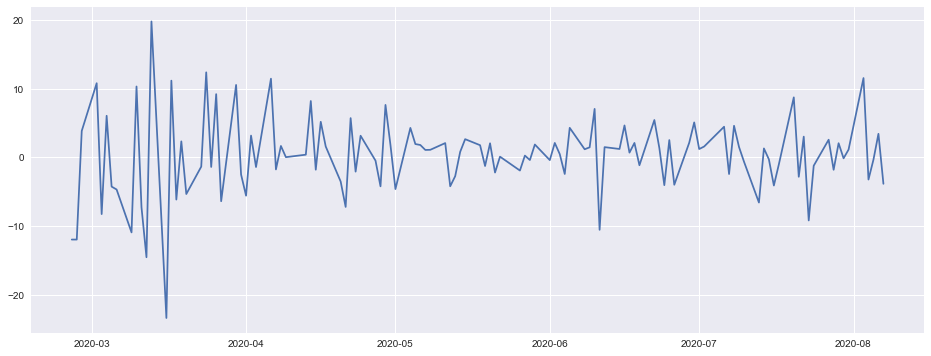

In [103]:
train_value = df_train.value   
train_value_diff = train_value - train_value.shift()
train_value_diff.fillna(method='bfill', inplace=True)
plt.figure(figsize=(16, 6))
plt.plot(train_value_diff)

Aplicamos el test de Dickey-Fuller al resíduo:

In [104]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(train_value_diff.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -17.080286
p-value: 0.000000
Valor crítico 1%: -3.49
Valor crítico 5%: -2.89
Valor crítico 10%: -2.58


Podemos rechazar la $H_0$. Avanzamos con el modelado de los ciclos de los residuos del modelo:

<a id="section_modelo_arima"></a> 
### 3.2.1 - Modelo ARIMA

(<matplotlib.axes._subplots.AxesSubplot at 0x1cd68683a48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cd67b0d8c8>)

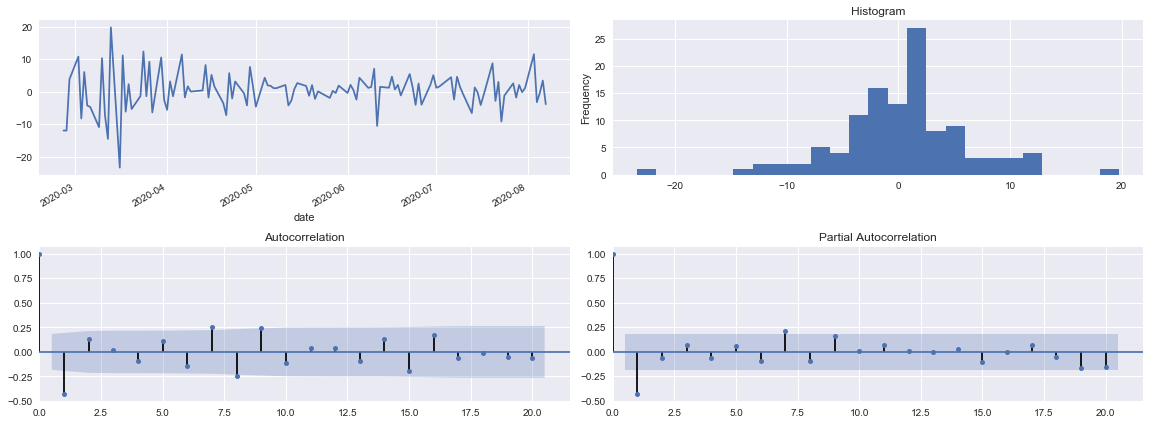

In [105]:
# Corremos la función con nuestra serie res_log:
tsplot(train_value_diff, lags=20)

Text(0.5,1,'Residual sum of squares: 3244.240')

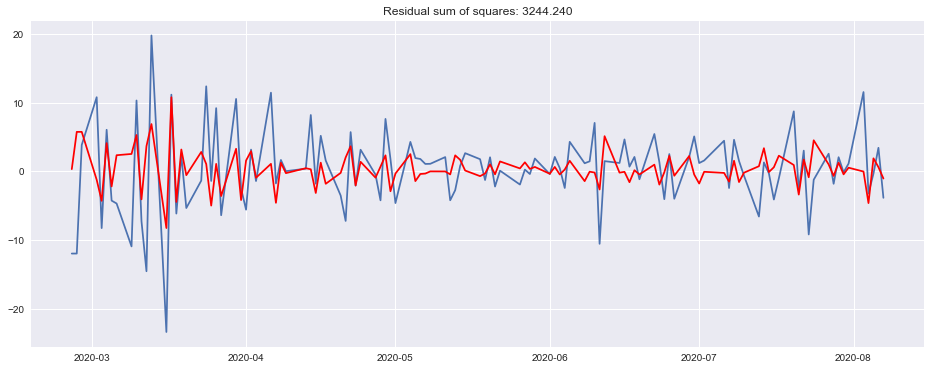

In [106]:
# AR model on differenced data

# AR : p había dado 1 de la PACF
# I  :
# MA : q había dado 1 de la ACF

# (  AR  ,  I  ,  MA )
# (  p   ,  d  ,  q)
# (  1   ,  0 ,   0 )   # PROBAMOS MODELAR SÓLO CON LA PARTE "AR"
# ( PACF , dif , ACF )

model = ARIMA(train_value_diff, order=(1, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.figure(figsize=(16, 6))
plt.plot(train_value_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('Residual sum of squares: %.3f'% sum((results_AR.fittedvalues-train_value_diff)**2))

Text(0.5,1,'Residual sum of squares: 3285.330')

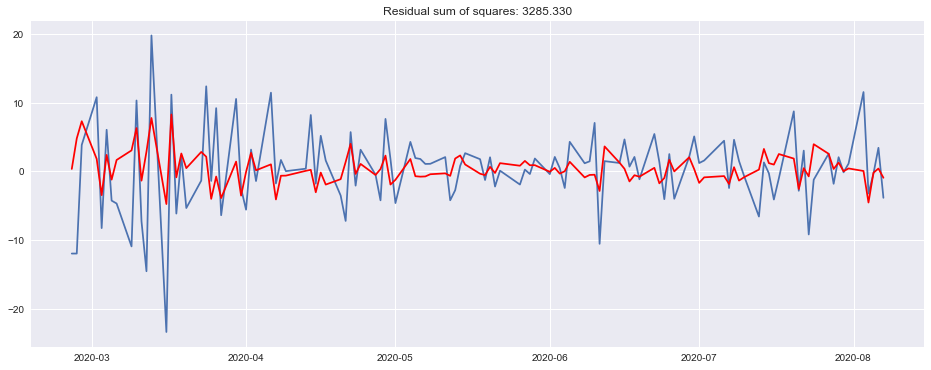

In [107]:
# MA model on differenced data

# AR : p había dado 1 de la PACF
# I  :
# MA : q había dado 1 de la ACF

# (  AR  ,  I  ,  MA )
# (  p   ,  d  ,  q)
# (  0   ,  0 ,   1 )   # PROBAMOS MODELAR SÓLO CON LA PARTE "MA"
# ( PACF , dif , ACF )

model = ARIMA(train_value_diff, order=(0, 0, 1))  
results_MA = model.fit(disp=-1)
plt.figure(figsize=(16, 6))
plt.plot(train_value_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Residual sum of squares: %.3f'% sum((results_MA.fittedvalues-train_value_diff)**2))

Text(0.5,1,'Residual sum of squares: 3224.431')

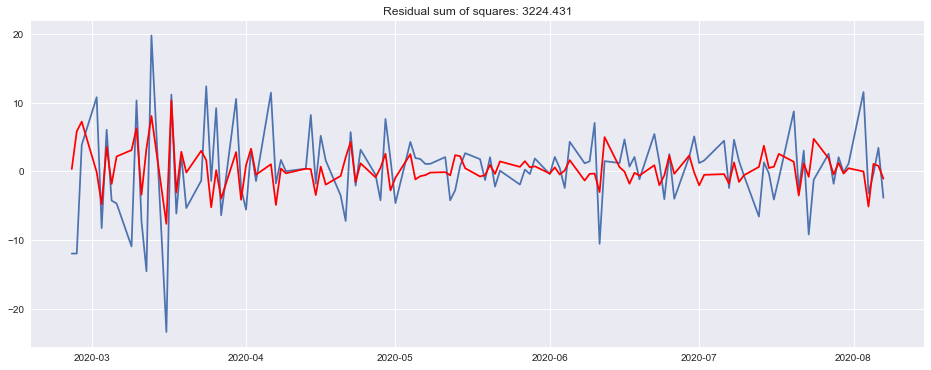

In [108]:
# ARIMA model on differenced data

# AR : p había dado 1 de la PACF
# I  :
# MA : q había dado 1 de la ACF

# (  AR  ,  I  ,  MA )
# (  p   ,  d  ,  q)
# (  1  ,  0 ,   1 )   # PROBAMOS MODELAR COMO "ARIMA"
# ( PACF , dif , ACF )

model = ARIMA(train_value_diff, order=(1, 0, 1))
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(16, 6))
plt.plot(train_value_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('Residual sum of squares: %.3f'% sum((results_ARIMA.fittedvalues-train_value_diff)**2))

In [109]:
print('\n results_AR.summary():\n')
print(results_AR.summary())
print('\n results_MA.summary():\n')
print(results_MA.summary())
print('\n results_ARIMA.summary():\n')
print(results_ARIMA.summary())


 results_AR.summary():

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                  115
Model:                     ARMA(1, 0)   Log Likelihood                -354.795
Method:                       css-mle   S.D. of innovations              5.287
Date:                Fri, 04 Sep 2020   AIC                            715.591
Time:                        22:08:31   BIC                            723.826
Sample:                             0   HQIC                           718.933
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3075      0.343      0.896      0.370      -0.365       0.980
ar.L1.value    -0.4410      0.085     -5.174      0.000      -0.608      -0.274
                       

##### Analizamos los residuos del modelo AR:

In [110]:
res_AR =  results_AR.fittedvalues - train_value_diff

(<matplotlib.axes._subplots.AxesSubplot at 0x1cd68a5edc8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cd69777cc8>)

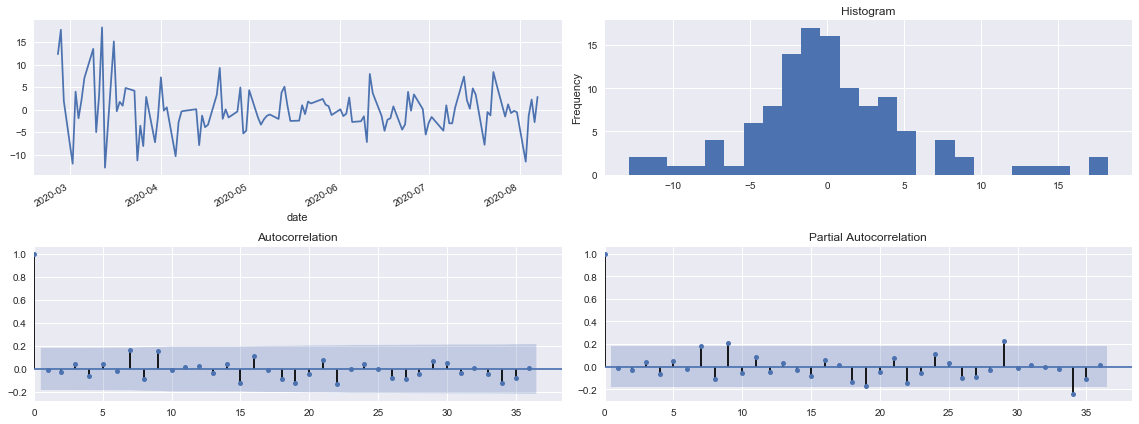

In [111]:
tsplot(res_AR, lags=36)

No parecería haber más estructura en los resíduos que podamos capturar. Nuestro resíduo ahora es ruido blanco.

##### Analizamos los residuos del modelo MA:

In [112]:
res_MA =  results_MA.fittedvalues - train_value_diff

(<matplotlib.axes._subplots.AxesSubplot at 0x1cd687a8188>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cd68422208>)

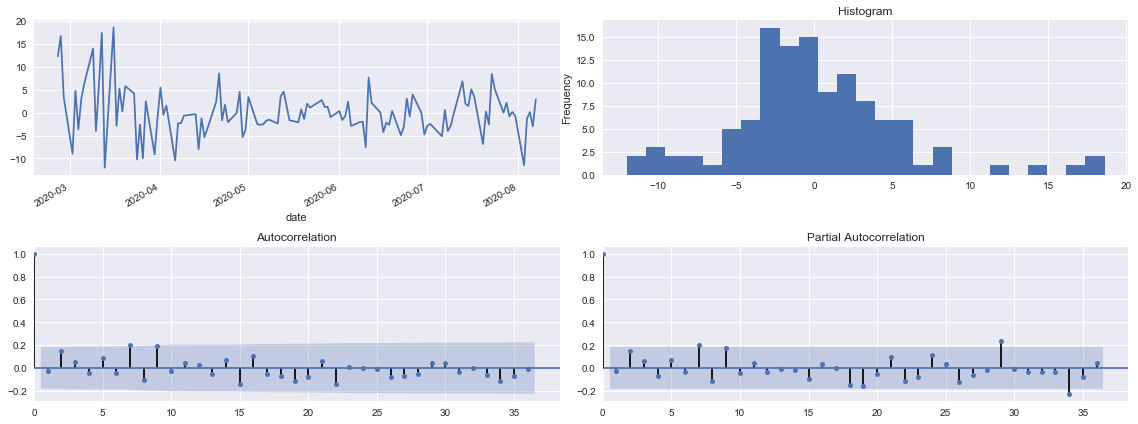

In [113]:
tsplot(res_MA, lags=36)

No parecería haber más estructura en los resíduos que podamos capturar. Nuestro resíduo ahora es ruido blanco.

##### Analizamos los residuos del modelo ARIMA:

In [114]:
res_ARIMA =  results_ARIMA.fittedvalues - train_value_diff

(<matplotlib.axes._subplots.AxesSubplot at 0x1cd67a39b48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cd67fe4e08>)

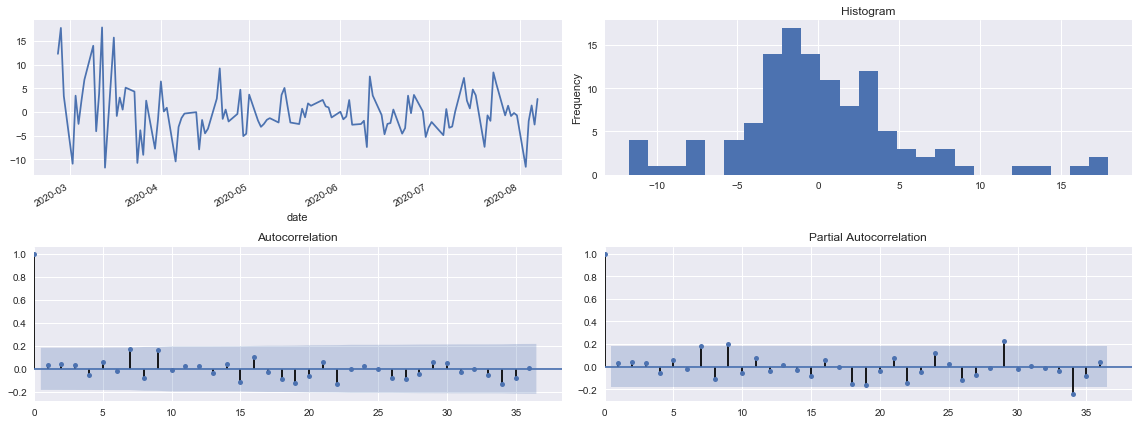

In [115]:
tsplot(res_ARIMA, lags=36)

No parecería haber más estructura en los resíduos que podamos capturar. Nuestro resíduo ahora es ruido blanco.

##### Guardamos las Prediccones del modelo AR

In [116]:
train_AR_2 = train_value.shift()
train_AR_2.fillna(method='bfill', inplace=True)

df_train['model_AR_2'] = train_AR_2 + results_AR.fittedvalues

test_AR_2 = pd.Series(df_train['model_AR_2'][-1], index=df_test.index)

predictions_AR, se, conf = results_AR.forecast(len(df_test['value']), alpha=0.05)
predictions_AR_back = predictions_AR
predictions_AR_back_cumsum = predictions_AR_back.cumsum()

predictions_AR_test = test_AR_2.add(predictions_AR_back_cumsum,fill_value=0)

df_test['model_AR_2'] = predictions_AR_test

##### Guardamos las Prediccones del modelo MA

In [117]:
train_MA_2 = train_value.shift()
train_MA_2.fillna(method='bfill', inplace=True)

df_train['model_MA_2'] = train_MA_2 + results_MA.fittedvalues

test_MA_2 = pd.Series(df_train['model_MA_2'][-1], index=df_test.index)

predictions_MA, se, conf = results_MA.forecast(len(df_test['value']), alpha=0.05)
predictions_MA_back = predictions_MA
predictions_MA_back_cumsum = predictions_MA_back.cumsum()

predictions_MA_test = test_MA_2.add(predictions_MA_back_cumsum,fill_value=0)

df_test['model_MA_2'] = predictions_MA_test

##### Guardamos las Prediccones del modelo ARIMA

In [118]:
train_ARIMA_2 = train_value.shift()
train_ARIMA_2.fillna(method='bfill', inplace=True)

df_train['model_ARIMA_2'] = train_ARIMA_2 + results_ARIMA.fittedvalues

test_ARIMA_2 = pd.Series(df_train['model_ARIMA_2'][-1], index=df_test.index)

predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test['value']), alpha=0.05)
predictions_ARIMA_back = predictions_ARIMA
predictions_ARIMA_back_cumsum = predictions_ARIMA_back.cumsum()

predictions_ARIMA_test = test_ARIMA_2.add(predictions_ARIMA_back_cumsum,fill_value=0)

df_test['model_ARIMA_2'] = predictions_ARIMA_test

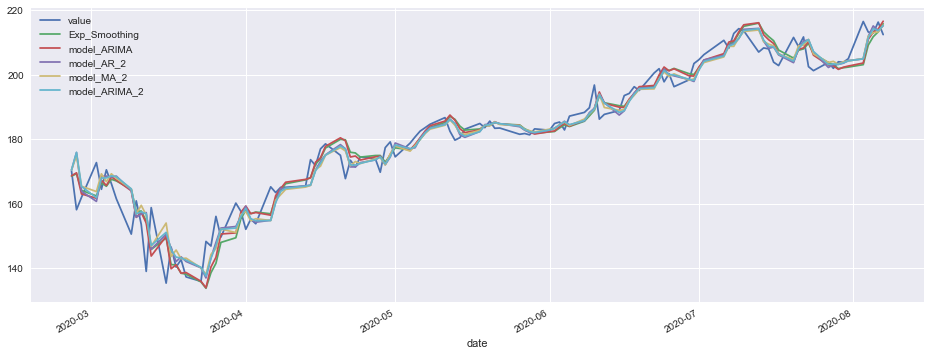

In [119]:
df_train.plot(kind = "line", y = ['value', 'Exp_Smoothing', 'model_ARIMA', 'model_AR_2','model_MA_2', 'model_ARIMA_2'], figsize=(16, 6));

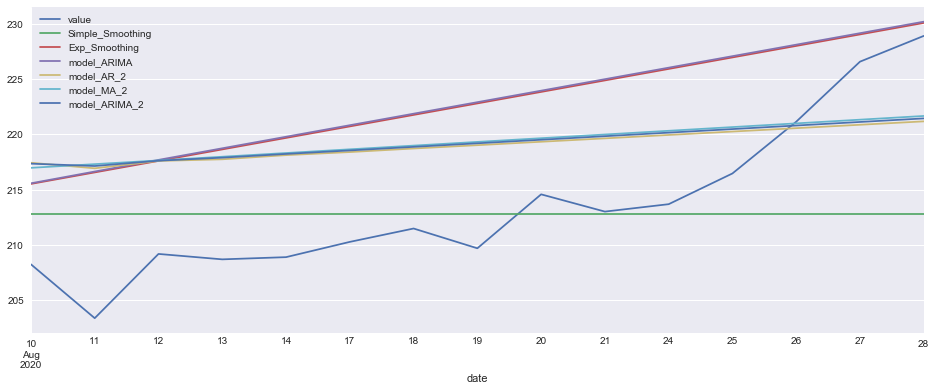

In [120]:
df_test.plot(kind = "line", y = ['value', 'Simple_Smoothing', 'Exp_Smoothing', 'model_ARIMA', 'model_AR_2', 'model_MA_2', 'model_ARIMA_2'], figsize=(16, 6));

In [121]:
df_Results.loc[9, "Model"] = "Diff + AR"
df_Results.loc[9, "RMSE"] = RMSE(df_test['model_AR_2'], df_test['value'])

df_Results.loc[10, "Model"] = "Diff + MA"
df_Results.loc[10, "RMSE"] = RMSE(df_test['model_MA_2'], df_test['value'])

df_Results.loc[11, "Model"] = "Diff + ARIMA"
df_Results.loc[11, "RMSE"] = RMSE(df_test['model_ARIMA_2'], df_test['value'])

df_Results

Model     RMSE
0                    Mean  32.5176
1             Random Walk  6.91949
2             LinearTrend   7.8698
3          QuadraticTrend  9.02761
4              Transf Log  9.60369
6        Simple Smoothing  6.87014
7   Exponential Smoothing  9.79673
8       Tendencia + ARIMA  9.89523
9               Diff + AR  7.84804
10              Diff + MA  7.96508
11           Diff + ARIMA  7.92761

<a id="section_modelo_sarimax"></a> 
### 3.3 - Modelo SARIMAX

#### Dado que la serie se entiende que no posee estacionalidad, esta parte de la notebook no la utilizaremos, con lo cual los resultados serán los mismos que los obtenidos en los modelos Sin Estacionalidad.

In [122]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
import os
import itertools
import warnings

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [123]:
def model_resid_stats(model_results,
                      het_method='breakvar',
                      norm_method='jarquebera',
                      sercor_method='ljungbox',
                      verbose=True,
                      ):
    '''More information about the statistics under the ARIMA parameters table, tests of standardized residuals:
    
    Test of heteroskedasticity
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity

    Test of normality (Default: Jarque-Bera)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality

    Test of serial correlation (Default: Ljung-Box)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html
    '''
    # Re-run the ARIMA model statistical tests, and more. To be used when selecting viable models.
    (het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
    norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
    sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
    sercor_stat = sercor_stat[-1] # last number for the largest lag
    sercor_p = sercor_p[-1] # last number for the largest lag

    # Run Durbin-Watson test on the standardized residuals.
    # The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
    # Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
    # This statistic will always be between 0 and 4. The closer to 0 the statistic,
    # the more evidence for positive serial correlation. The closer to 4,
    # the more evidence for negative serial correlation.
    # Essentially, below 1 or above 3 is bad.
    dw_stat = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

    # check whether roots are outside the unit circle (we want them to be);
    # will be True when AR is not used (i.e., AR order = 0)
    arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
    # will be True when MA is not used (i.e., MA order = 0)
    maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)
    
    if verbose:
        print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
        print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
        print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
        print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw_stat))
        print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
        print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))
    
    stat = {'het_method': het_method,
            'het_stat': het_stat,
            'het_p': het_p,
            'norm_method': norm_method,
            'norm_stat': norm_stat,
            'norm_p': norm_p,
            'skew': skew,
            'kurtosis': kurtosis,
            'sercor_method': sercor_method,
            'sercor_stat': sercor_stat,
            'sercor_p': sercor_p,
            'dw_stat': dw_stat,
            'arroots_outside_unit_circle': arroots_outside_unit_circle,
            'maroots_outside_unit_circle': maroots_outside_unit_circle,
            }
    return stat

In [124]:
def model_gridsearch(ts,
                     p_min,
                     d_min,
                     q_min,
                     p_max,
                     d_max,
                     q_max,
                     sP_min,
                     sD_min,
                     sQ_min,
                     sP_max,
                     sD_max,
                     sQ_max,
                     trends,
                     s=None,
                     enforce_stationarity=True,
                     enforce_invertibility=True,
                     simple_differencing=False,
                     plot_diagnostics=False,
                     verbose=False,
                     filter_warnings=True,
                    ):
    '''Run grid search of SARIMAX models and save results.
    '''
    
    cols = ['p', 'd', 'q', 'sP', 'sD', 'sQ', 's', 'trend',
            'enforce_stationarity', 'enforce_invertibility', 'simple_differencing',
            'aic', 'bic',
            'het_p', 'norm_p', 'sercor_p', 'dw_stat',
            'arroots_gt_1', 'maroots_gt_1',
            'datetime_run']

    # Initialize a DataFrame to store the results
    df_results = pd.DataFrame(columns=cols)

    mod_num=0
    for trend,p,d,q,sP,sD,sQ in itertools.product(trends,
                                                  range(p_min,p_max+1),
                                                  range(d_min,d_max+1),
                                                  range(q_min,q_max+1),
                                                  range(sP_min,sP_max+1),
                                                  range(sD_min,sD_max+1),
                                                  range(sQ_min,sQ_max+1),
                                                  ):
        # initialize to store results for this parameter set
        this_model = pd.DataFrame(index=[mod_num], columns=cols)

        if p==0 and d==0 and q==0:
            continue

        try:
            model = sm.tsa.SARIMAX(ts,
                                   trend=trend,
                                   order=(p, d, q),
                                   seasonal_order=(sP, sD, sQ, s),
                                   enforce_stationarity=enforce_stationarity,
                                   enforce_invertibility=enforce_invertibility,
                                   simple_differencing=simple_differencing,
                                  )
            
            if filter_warnings is True:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model_results = model.fit(disp=0)
            else:
                model_results = model.fit()

            if verbose:
                print(model_results.summary())

            if plot_diagnostics:
                model_results.plot_diagnostics();

            stat = model_resid_stats(model_results,
                                     verbose=verbose)

            this_model.loc[mod_num, 'p'] = p
            this_model.loc[mod_num, 'd'] = d
            this_model.loc[mod_num, 'q'] = q
            this_model.loc[mod_num, 'sP'] = sP
            this_model.loc[mod_num, 'sD'] = sD
            this_model.loc[mod_num, 'sQ'] = sQ
            this_model.loc[mod_num, 's'] = s
            this_model.loc[mod_num, 'trend'] = trend
            this_model.loc[mod_num, 'enforce_stationarity'] = enforce_stationarity
            this_model.loc[mod_num, 'enforce_invertibility'] = enforce_invertibility
            this_model.loc[mod_num, 'simple_differencing'] = simple_differencing
            this_model.loc[mod_num, 'aic'] = model_results.aic
            this_model.loc[mod_num, 'bic'] = model_results.bic
            this_model.loc[mod_num, 'het_p'] = stat['het_p']
            this_model.loc[mod_num, 'norm_p'] = stat['norm_p']
            this_model.loc[mod_num, 'sercor_p'] = stat['sercor_p']
            this_model.loc[mod_num, 'dw_stat'] = stat['dw_stat']
            this_model.loc[mod_num, 'arroots_gt_1'] = stat['arroots_outside_unit_circle']
            this_model.loc[mod_num, 'maroots_gt_1'] = stat['maroots_outside_unit_circle']

            this_model.loc[mod_num, 'datetime_run'] = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')

            df_results = df_results.append(this_model)
            mod_num+=1
        except:
            continue
    return df_results

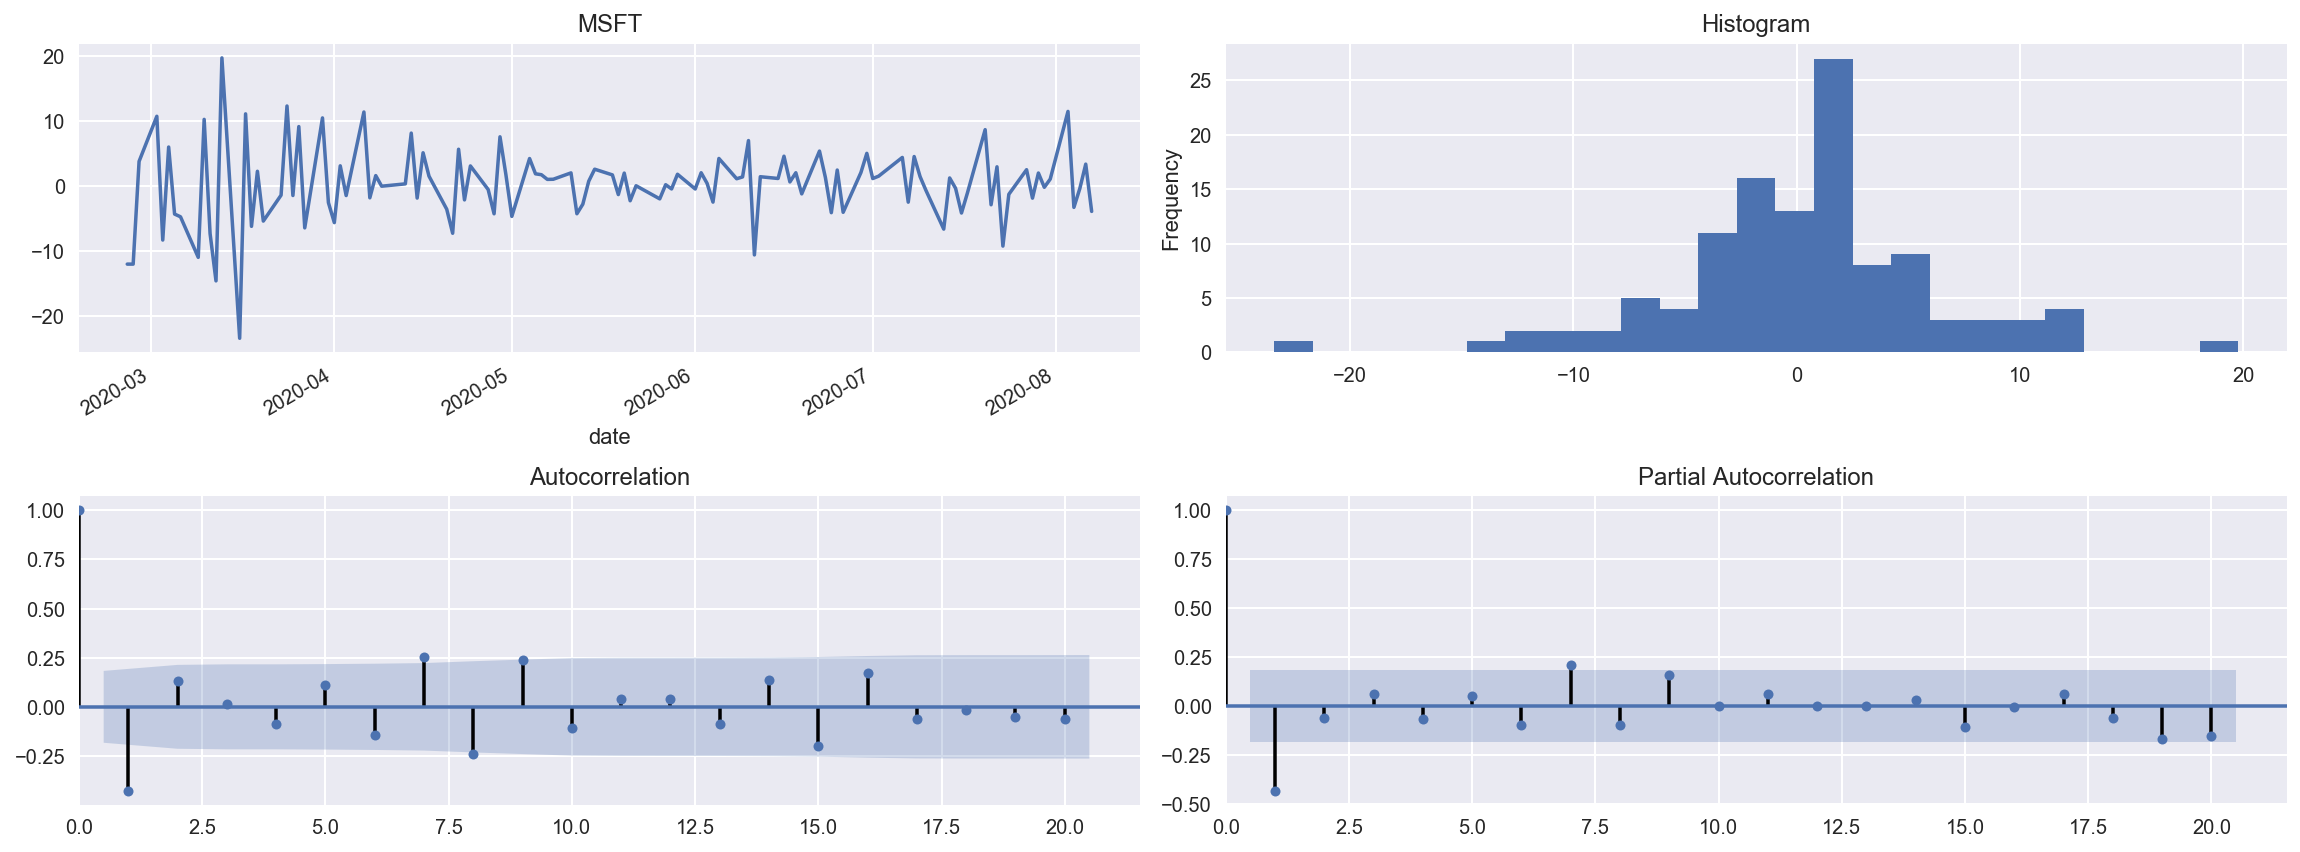

In [125]:
tsplot(train_value_diff, title='MSFT', lags=20);

In [126]:
# HACEMOS UN GRIDSEARH PARA LOS PARÁMETROS DE TODO (LA PARTE DE SIN y CON SEASONAL) ARIMA / SARIMA

p_min = 1
d_min = 0
q_min = 1
p_max = 3
d_max = 0
q_max = 3

sP_min = 0
sD_min = 0
sQ_min = 0
sP_max = 0
sD_max = 0
sQ_max = 0

s=0

trends=['n', 'c']

enforce_stationarity=True
enforce_invertibility=True
simple_differencing=True

plot_diagnostics=False

verbose=False

df_results = model_gridsearch(train_value_diff,
                              p_min,
                              d_min,
                              q_min,
                              p_max,
                              d_max,
                              q_max,
                              sP_min,
                              sD_min,
                              sQ_min,
                              sP_max,
                              sD_max,
                              sQ_max,
                              trends,
                              s=s,
                              enforce_stationarity=enforce_stationarity,
                              enforce_invertibility=enforce_invertibility,
                              simple_differencing=simple_differencing,
                              plot_diagnostics=plot_diagnostics,
                              verbose=verbose,
                              )

In [127]:
# cElegiríamos el modelo con el mayor sercor_p
df_results.sort_values(by='sercor_p', ascending=False).head(10)

p  d  q sP sD sQ  s trend enforce_stationarity enforce_invertibility  \
3   2  0  1  0  0  0  0     n                 True                  True   
6   3  0  1  0  0  0  0     n                 True                  True   
4   2  0  2  0  0  0  0     n                 True                  True   
12  2  0  1  0  0  0  0     c                 True                  True   
16  3  0  2  0  0  0  0     c                 True                  True   
15  3  0  1  0  0  0  0     c                 True                  True   
13  2  0  2  0  0  0  0     c                 True                  True   
7   3  0  2  0  0  0  0     n                 True                  True   
17  3  0  3  0  0  0  0     c                 True                  True   
8   3  0  3  0  0  0  0     n                 True                  True   

   simple_differencing       aic       bic   het_p  norm_p sercor_p dw_stat  \
3                 True 712.09707 723.07680 0.00092 0.00003  0.96763 1.92958   
6                 True 714.09700 727.82167 0.00092 0.00003  0.96752 1.92883   
4                 True 714.09700 727.82166 0.00092 0.00003  0.96751 1.92877   
12                True 713.19451 726.91917 0.00059 0.00003  0.96645 1.93406   
16                True 717.13868 736.35320 0.00069 0.00006  0.96611 1.94753   
15                True 715.17517 731.64476 0.00056 0.00003  0.96413 1.92131   
13                True 715.17291 731.64250 0.00056 0.00003  0.96400 1.91985   
7                 True 715.65888 732.12847 0.00105 0.00027  0.96231 1.96038   
17                True 719.00275 740.96221 0.00069 0.00012  0.95796 1.91737   
8                 True 717.47991 736.69444 0.00101 0.00047  0.95343 1.92390   

   arroots_gt_1 maroots_gt_1         datetime_run  
3          True         True  2020-09-04 22:08:35  
6          True         True  2020-09-04 22:08:36  
4          True         True  2020-09-04 22:08:35  
12         True         True  2020-09-04 22:08:37  
16         True         True  2020-09-04 22:08:38  
15         True         True  2020-09-04 22:08:38  
13         True         True  2020-09-04 22:08:37  
7          True         True  2020-09-04 22:08:36  
17         True         True  2020-09-04 22:08:39  
8          True         True  2020-09-04 22:08:36

In [128]:
model_SARIMAX = sm.tsa.SARIMAX(train_value_diff,
                                   trend="n",
                                   order=(1, 0, 1),
                                   seasonal_order=(0, 0, 0, 0),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False,
                                   simple_differencing=False,
                                  )
# Estimo el modelo:
results_SARIMAX = model_SARIMAX.fit()
results_SARIMAX.fittedvalues.head()

date
2020-02-26    0.00000
2020-02-27    4.77793
2020-02-28    4.77797
2020-03-02   -1.42220
2020-03-03   -5.65108
dtype: float64

##### Guardamos las Prediccones del modelo SARIMAX

In [129]:
train_SARIMAX = train_value.shift()
train_SARIMAX.fillna(method='bfill', inplace=True)

df_train['model_SARIMAX'] = train_SARIMAX + results_SARIMAX.fittedvalues

test_SARIMAX = pd.Series(df_train['model_SARIMAX'][-1], index=df_test.index)

predictions_SARIMAX = results_SARIMAX.forecast(len(df_test['value']), alpha=0.05)
predictions_SARIMAX_back = predictions_SARIMAX
predictions_SARIMAX_back_cumsum = predictions_SARIMAX_back.cumsum()

predictions_SARIMAX_test = test_SARIMAX.add(predictions_SARIMAX_back_cumsum,fill_value=0)

df_test['model_SARIMAX'] = predictions_SARIMAX_test

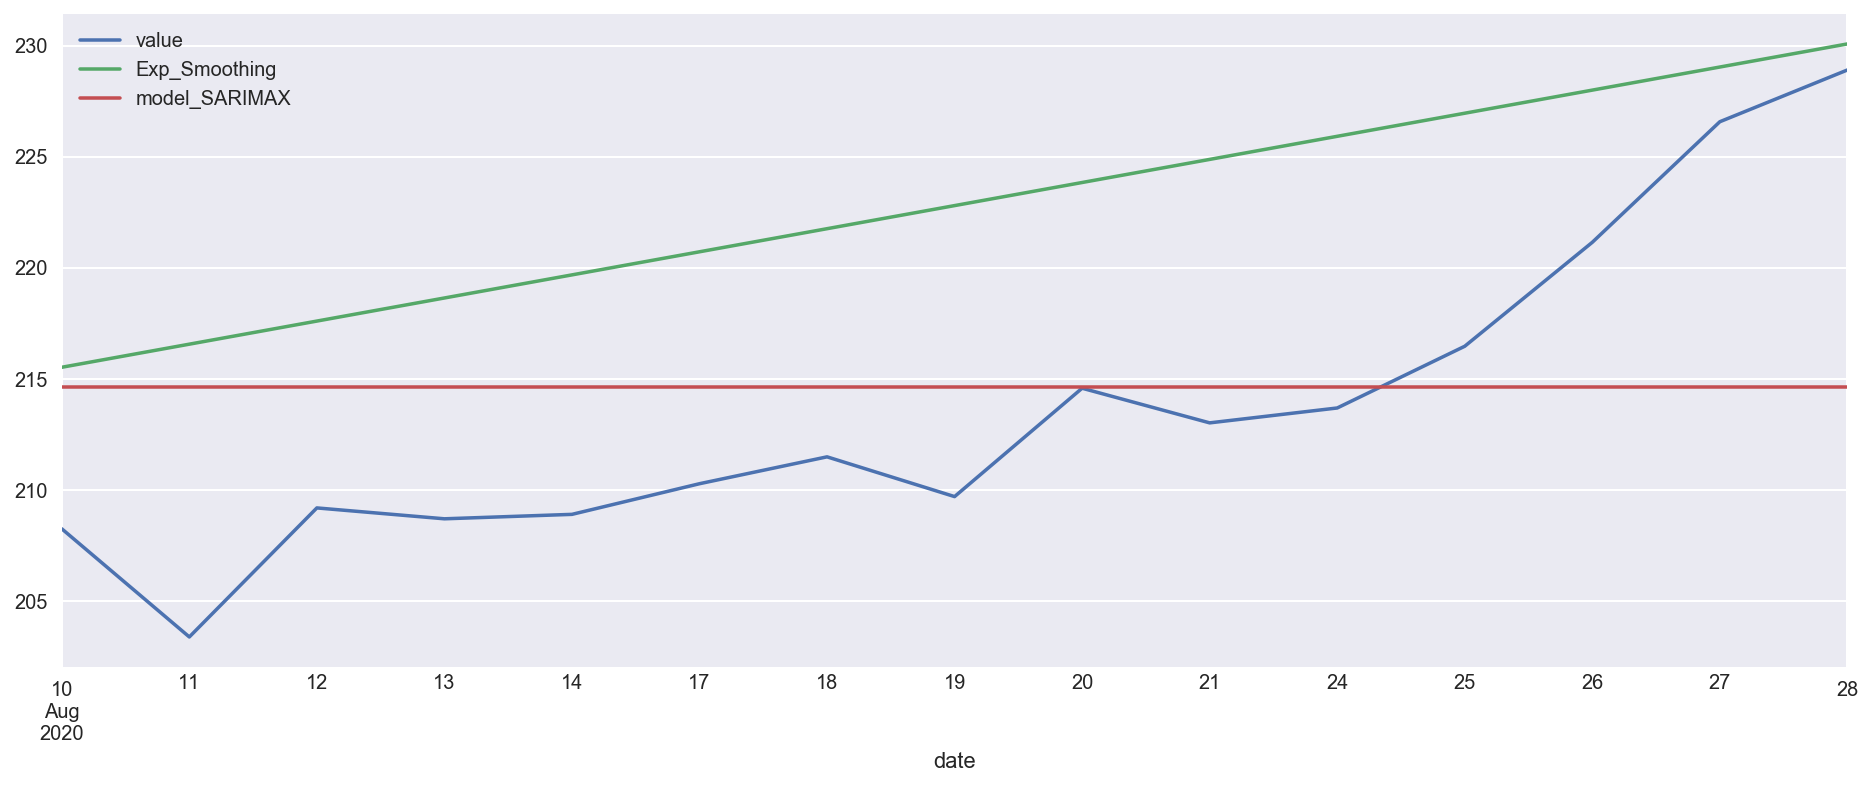

In [130]:
df_test.plot(kind = "line", y = ['value', 'Exp_Smoothing', 'model_SARIMAX'], figsize=(16, 6));

In [131]:
# Calculamos el RMSE y almacenamos los resultados
df_Results.loc[12, "Model"] = "Diff + SARIMAX"
df_Results.loc[12, "RMSE"] = RMSE(df_test['model_SARIMAX'], df_test.value)
df_Results

Model     RMSE
0                    Mean 32.51765
1             Random Walk  6.91949
2             LinearTrend  7.86980
3          QuadraticTrend  9.02761
4              Transf Log  9.60369
6        Simple Smoothing  6.87014
7   Exponential Smoothing  9.79673
8       Tendencia + ARIMA  9.89523
9               Diff + AR  7.84804
10              Diff + MA  7.96508
11           Diff + ARIMA  7.92761
12         Diff + SARIMAX  6.90160

---
<a id="forecast_con_prophet"></a> 
###  4- Forecasting con PROPHET

#### 4.1 - Modelos Prophet

In [132]:
from fbprophet import Prophet

from pandas.tseries.offsets import DateOffset

https://facebook.github.io/prophet/docs/non-daily_data.html#data-with-regular-gaps
https://facebook.github.io/prophet/docs/diagnostics.html
https://facebook.github.io/prophet/docs/diagnostics.html#parallelizing-cross-validation
https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning


In [133]:
# Preparamos los Datos como los requiere Prophet:

df_prophet = df["value"]
df_prophet = df_prophet.reset_index()
df_prophet.columns = ['ds', 'y']
df_prophet

df_train_prophet = df_train["value"]
df_train_prophet = df_train_prophet.reset_index()
df_train_prophet.columns = ['ds', 'y']
print(df_train_prophet.tail(7))

df_test_prophet = df_test["value"]
df_test_prophet = df_test_prophet.reset_index()
df_test_prophet.columns = ['ds', 'y']
df_test_prophet.tail()

            ds         y
108 2020-07-30 203.89999
109 2020-07-31 205.00999
110 2020-08-03 216.53999
111 2020-08-04 213.28999
112 2020-08-05 212.94000
113 2020-08-06 216.35001
114 2020-08-07 212.48000


ds         y
10 2020-08-24 213.69000
11 2020-08-25 216.47000
12 2020-08-26 221.14999
13 2020-08-27 226.58000
14 2020-08-28 228.91000

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


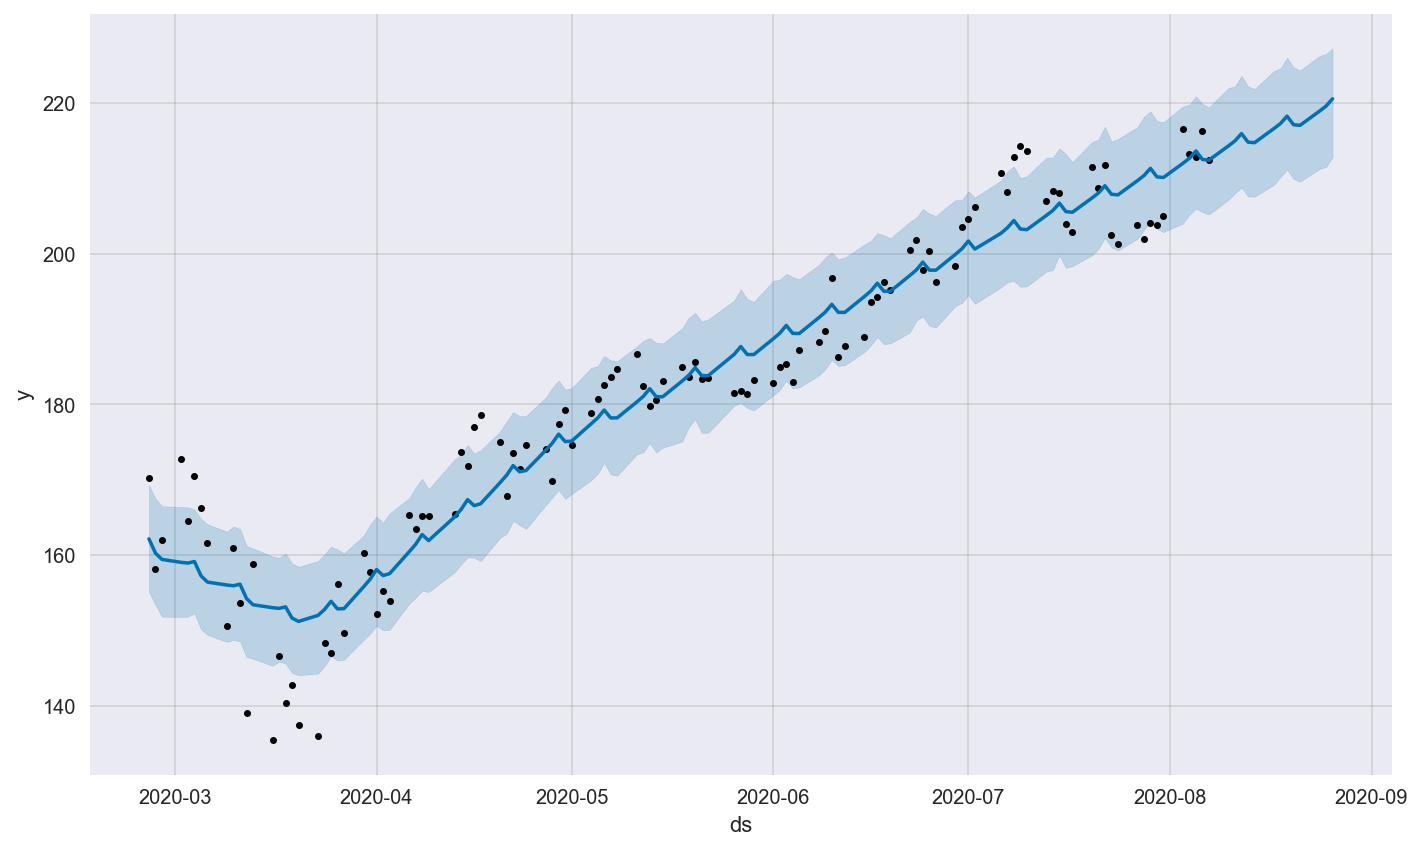

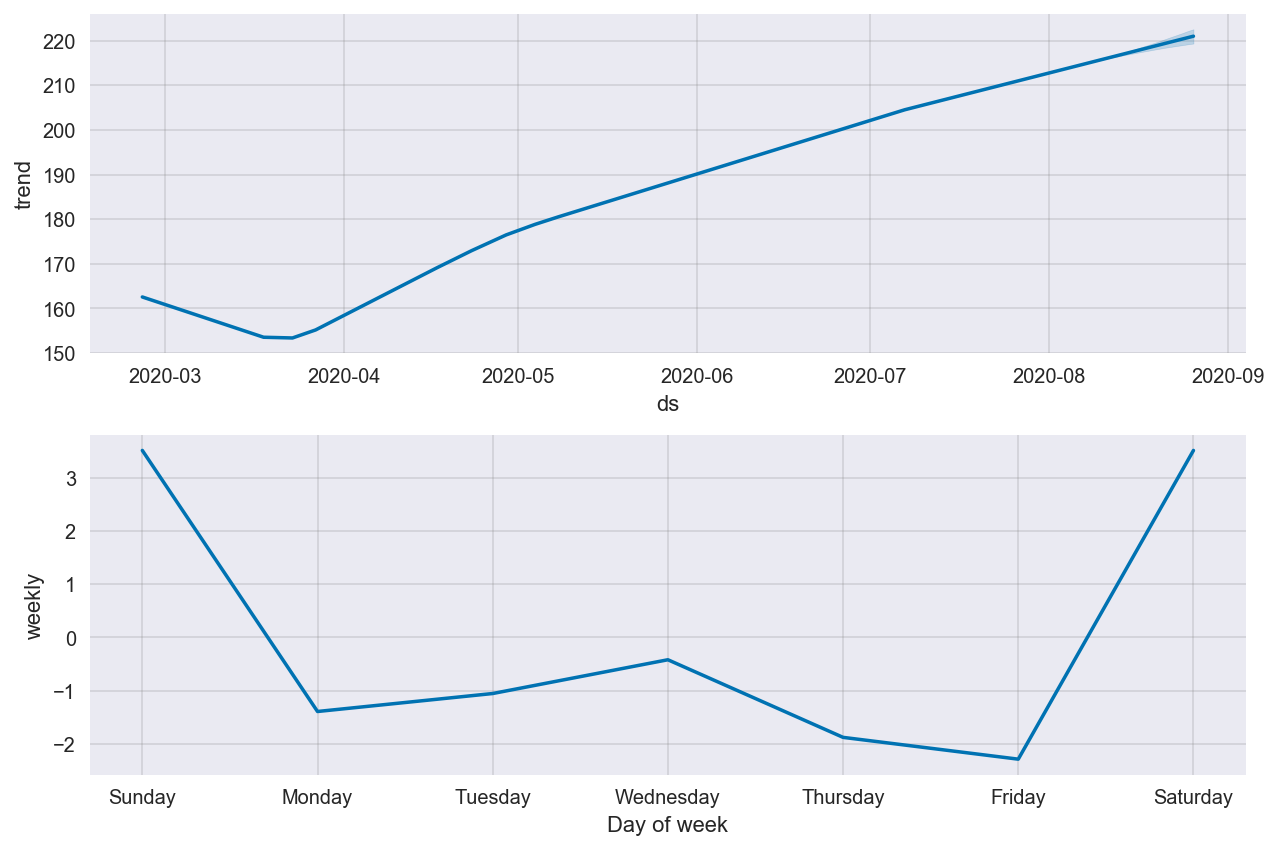

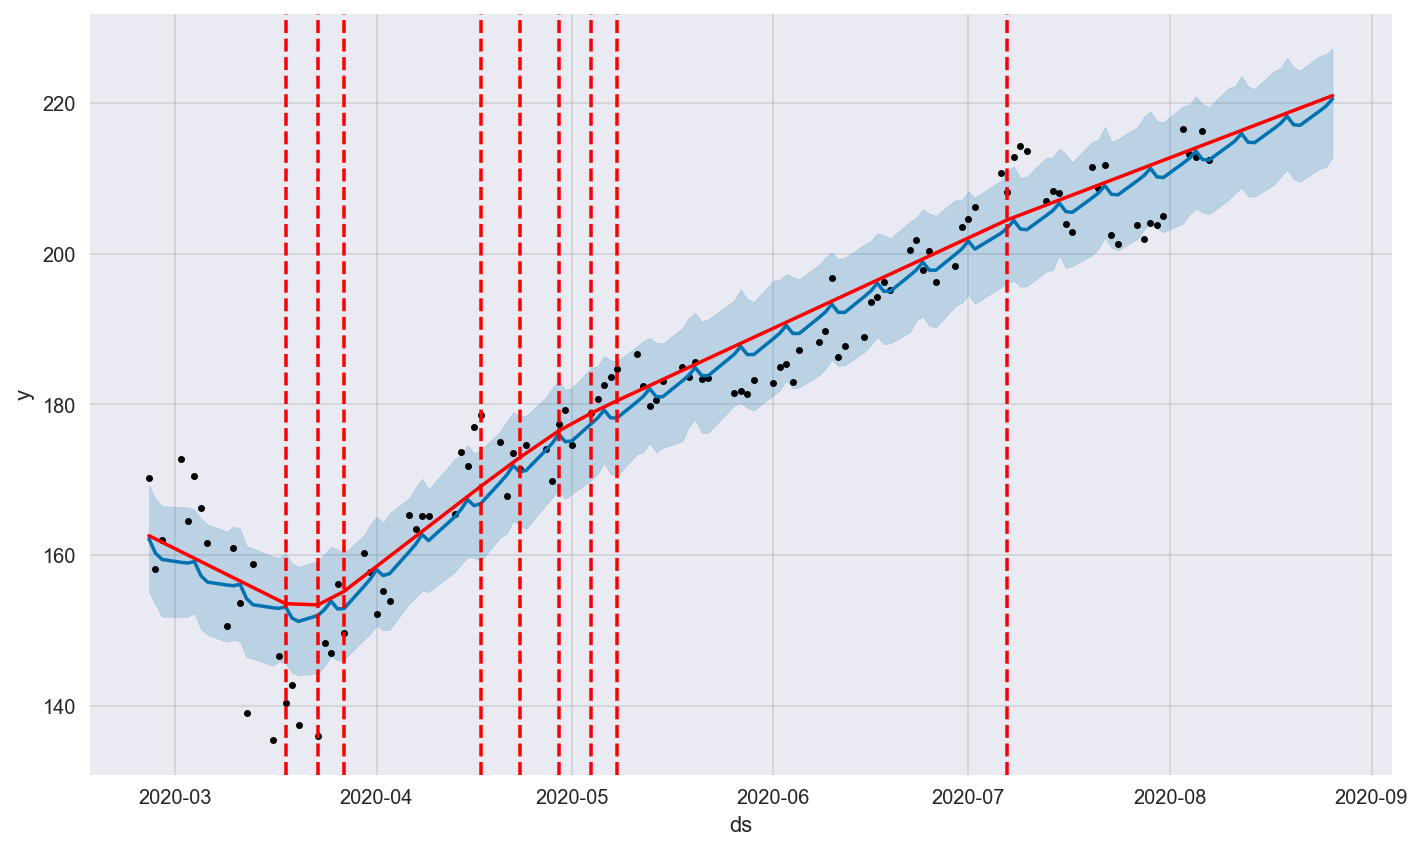

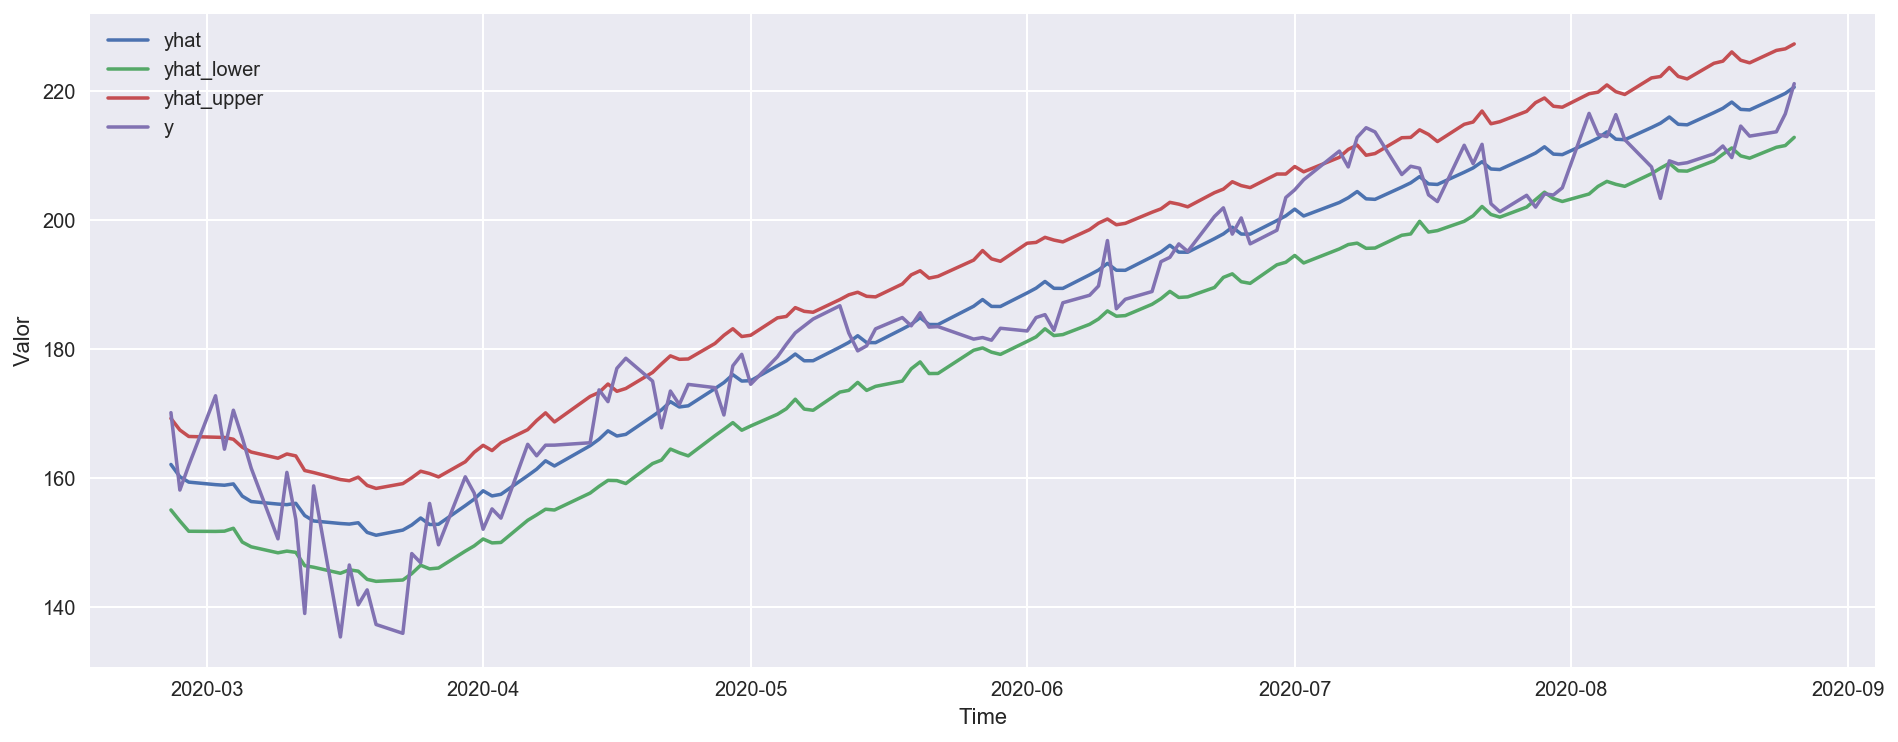

In [134]:
#import warnings
#warnings.filterwarnings('ignore')

# Import Prophet
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

# Split into a train/test set
d0 = df_test.index[0]
d1 = (df_test.index[-1] + DateOffset(days=1))
delta = d1 - d0
prediction_size = delta.days

#train_df = df[:-prediction_size]

#df_train_prophet['cap'] = 330
# Initialize and train a model

# Automatic changepoint detection in Prophet
# n_changepoints: number of potential changepoints
# changepoint_range: By default changepoints are only inferred for the first 80% of the time series
# changepoint_prior_scale: By default is set to 0.05. Increasing it will make the trend more flexible-
# changepoints:  manually specify the locations of potential changepoints 

# seasonality_mode='additive'
#--------------------------------------------------------------------------------------
#m = Prophet(growth='linear', changepoint_prior_scale=0.01, changepoint_range=0.8, interval_width=0.8)
m = Prophet()
#m.add_seasonality(name='monthly', period=21, fourier_order=5)
m.fit(df_train_prophet)
#--------------------------------------------------------------------------------------
# Make predictions
future = m.make_future_dataframe(periods=prediction_size)
#future['cap'] = 330
forecast = m.predict(future)
forecast = forecast[forecast.ds.dt.dayofweek < 5]  # eliminamos los fines de semana ya que no tenemos datos

# Plot forecast
m.plot(forecast)

# Plot forecast's components
m.plot_components(forecast)

# Evaluate the model
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

cmp_df = make_comparison_dataframe(df_prophet, forecast)
cmp_df.head()

#Automatic changepoint detection in Prophet
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# Plot forecast with upper and lower bounds
plt.figure(figsize=(16, 6))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Valor')
plt.grid(True)
plt.legend(loc="best")
plt.show()

#### 4.2 - Time Series Cross-Validation con Prophet

In [135]:
from fbprophet.diagnostics import cross_validation

# initial: Cantidad de Datos de entrenamiento. (default, tres veces "horizon"). 
# horizon: Cantidad de predicciones a realizar
# período: cuanto mueve la ventana de datos de entranamiento en cada iteración del CV.

# delta lo calculamos más arriba
df_cv = cross_validation(m, initial= "30 days", period='20 days', horizon = delta)
df_cv.shape

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-04-10 00:00:00 and 2020-07-19 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


(79, 6)

In [136]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(30)

horizon      mse    rmse     mae    mape   mdape  coverage
0   2 days 22.05568 4.69635 4.10635 0.02126 0.02467   0.91429
1   3 days 15.53172 3.94103 3.10150 0.01562 0.01759   0.85714
2   4 days 25.37564 5.03742 3.79061 0.01939 0.01260   0.71429
3   5 days 40.51642 6.36525 5.05095 0.02611 0.01932   0.67857
4   6 days 43.39780 6.58770 5.34229 0.02873 0.02292   0.57143
5   7 days 48.62478 6.97315 6.10054 0.03242 0.04103   0.42857
6   8 days 53.77181 7.33293 6.62992 0.03419 0.04103   0.40000
7   9 days 85.41977 9.24228 8.67445 0.04384 0.04696   0.17143
8  10 days 98.42958 9.92117 8.96708 0.04432 0.04696   0.28571
9  11 days 95.82651 9.78910 8.57632 0.04329 0.05877   0.35714
10 12 days 87.17944 9.33699 8.64241 0.04535 0.05476   0.25000
11 13 days 85.39181 9.24077 8.87019 0.04755 0.05331   0.25000
12 14 days 75.58414 8.69391 8.14834 0.04334 0.05049   0.35714
13 15 days 60.66264 7.78862 6.93432 0.03655 0.05049   0.40000
14 16 days 55.60963 7.45719 6.77817 0.03468 0.03464   0.45714
15 17 days 41.91707 6.47434 5.75706 0.02933 0.03377   0.78571
16 18 days 63.73765 7.98359 6.33458 0.03444 0.02660   0.71429
17 19 days 85.45954 9.24443 8.24819 0.04458 0.04191   0.50000

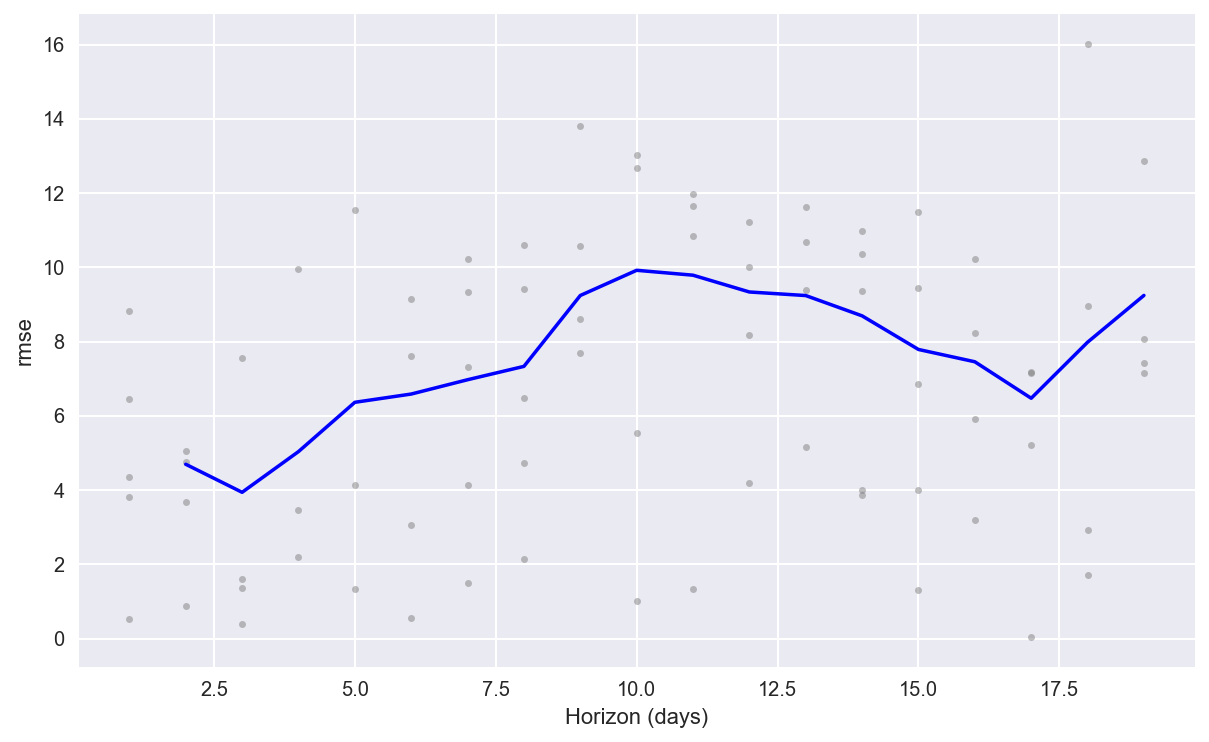

In [137]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

#### 4.3 - Hyperparameter tuning

In [138]:
# Detección Automática de Changepoints en Prophet
# n_changepoints: number of potential changepoints
# changepoint_range: By default changepoints are only inferred for the first 80% of the time series
# changepoint_prior_scale: By default is set to 0.05. Increasing it will make the trend more flexible-
# changepoints:  manually specify the locations of potential changepoints 
import itertools
param_grid = {  
    'changepoint_range': [0.8, 0.85, 0.9],
    'changepoint_prior_scale': [0.01, 0.1, 0.2],
    #'seasonality_prior_scale': [0.01, 0.1, 1.0],
    #'seasonality_mode': ['additive', 'multiplicative'],
}

# Generamos las combinaciones de parámetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

horizonte = delta # calculado anteriormente

# Usamos cross-validation para evaluar todos los parámetros
for params in all_params:
    m = Prophet(**params)
    #m.add_seasonality(name='monthly', period=21, fourier_order=5)
    m.fit(df_train_prophet)
    df_cv = cross_validation(m, initial= "30 days", period='35 days', horizon = delta)
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

#Mejores Parámetros
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2020-04-05 00:00:00 and 2020-07-19 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2020-04-05 00:00:00 and 2020-07-19 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 foreca

   changepoint_range  changepoint_prior_scale     rmse
0            0.80000                  0.01000 16.02163
1            0.80000                  0.10000  8.35467
2            0.80000                  0.20000  8.15370
3            0.85000                  0.01000 16.03803
4            0.85000                  0.10000  8.14871
5            0.85000                  0.20000  7.85984
6            0.90000                  0.01000 15.98847
7            0.90000                  0.10000  8.14413
8            0.90000                  0.20000  6.98232


In [139]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_range': 0.9, 'changepoint_prior_scale': 0.2}


In [140]:

# -------------------------------------------------------------------------------------
#m = Prophet(growth='linear', changepoint_prior_scale=0.01, changepoint_range=0.8, interval_width=0.8)
m = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],\
            changepoint_range= best_params['changepoint_range'])
#m.add_seasonality(name='monthly', period=21, fourier_order=5)
m.fit(df_train_prophet)
# -------------------------------------------------------------------------------------

# Make predictions
# En future se guardar los Históricos +las Predicciones
future = m.make_future_dataframe(periods=prediction_size+2, include_history=True)
#future['cap'] = 330
forecast = m.predict(future)
#forecast = forecast[forecast.ds.dt.dayofweek < 5]  # eliminamos los fines de semana ya que no tenemos datos


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


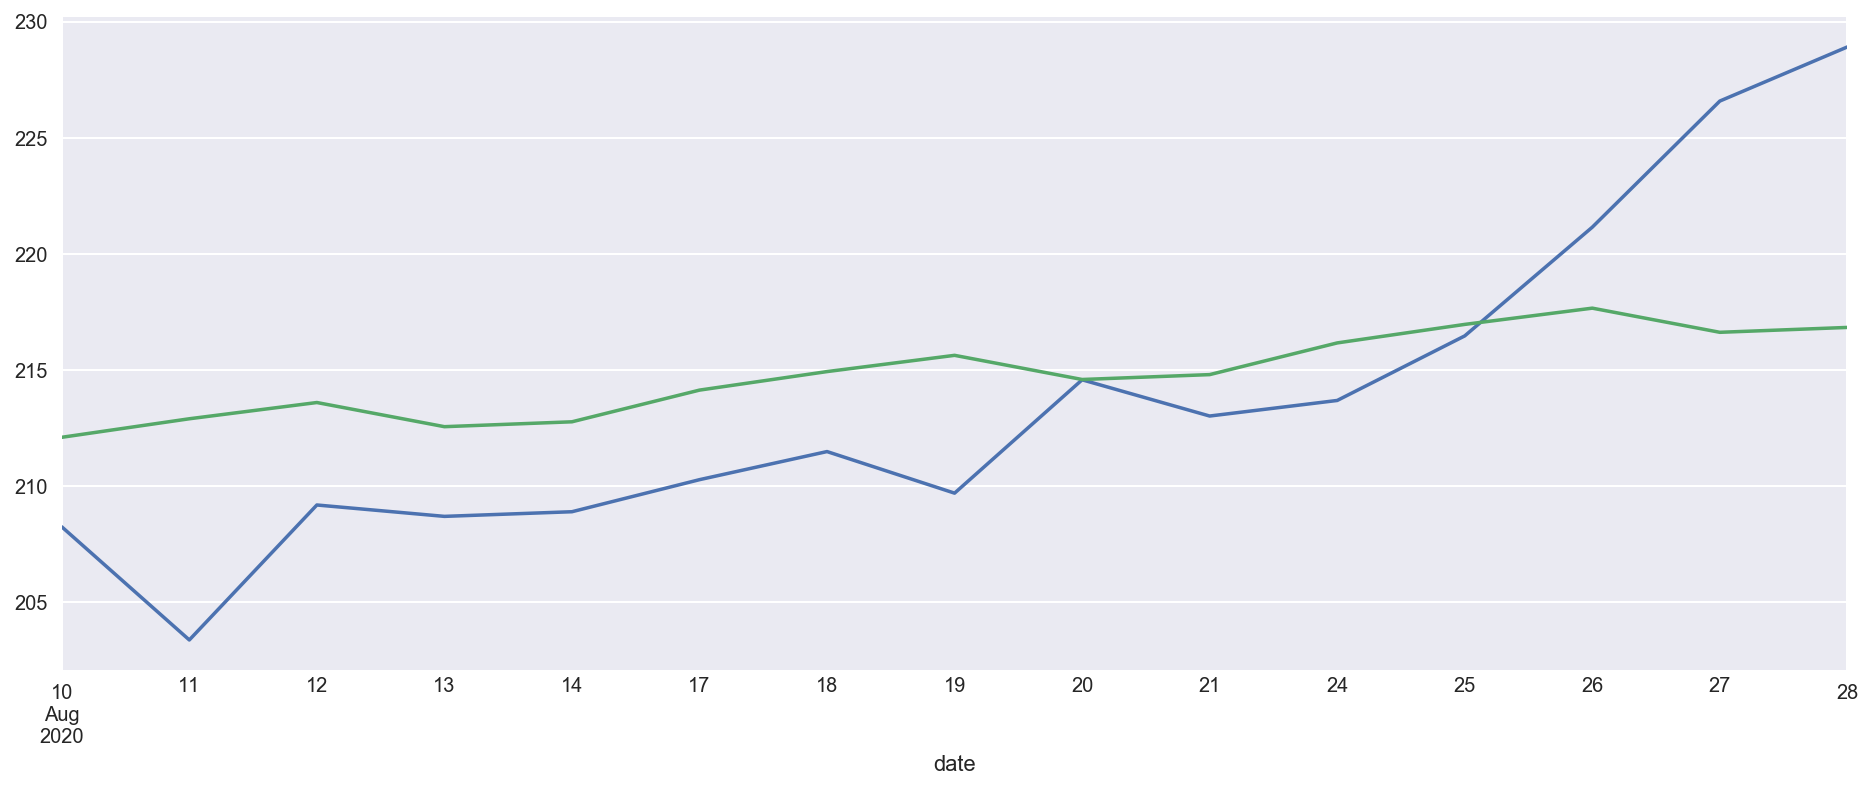

In [141]:
plt.figure(figsize=(16, 6))
df_test.value.plot()
forecast_yhat_tail = forecast[["ds","yhat"]].tail(prediction_size)
# Hacemos un Merges porque Prophet prdice para los Fines de Semanas que no los tenemos
df_proph_tail= df_test.merge(forecast_yhat_tail, left_index=True, right_on="ds").yhat
df_proph_tail.index= df_test.index # me quedo con los últimos
df_proph_tail.plot()

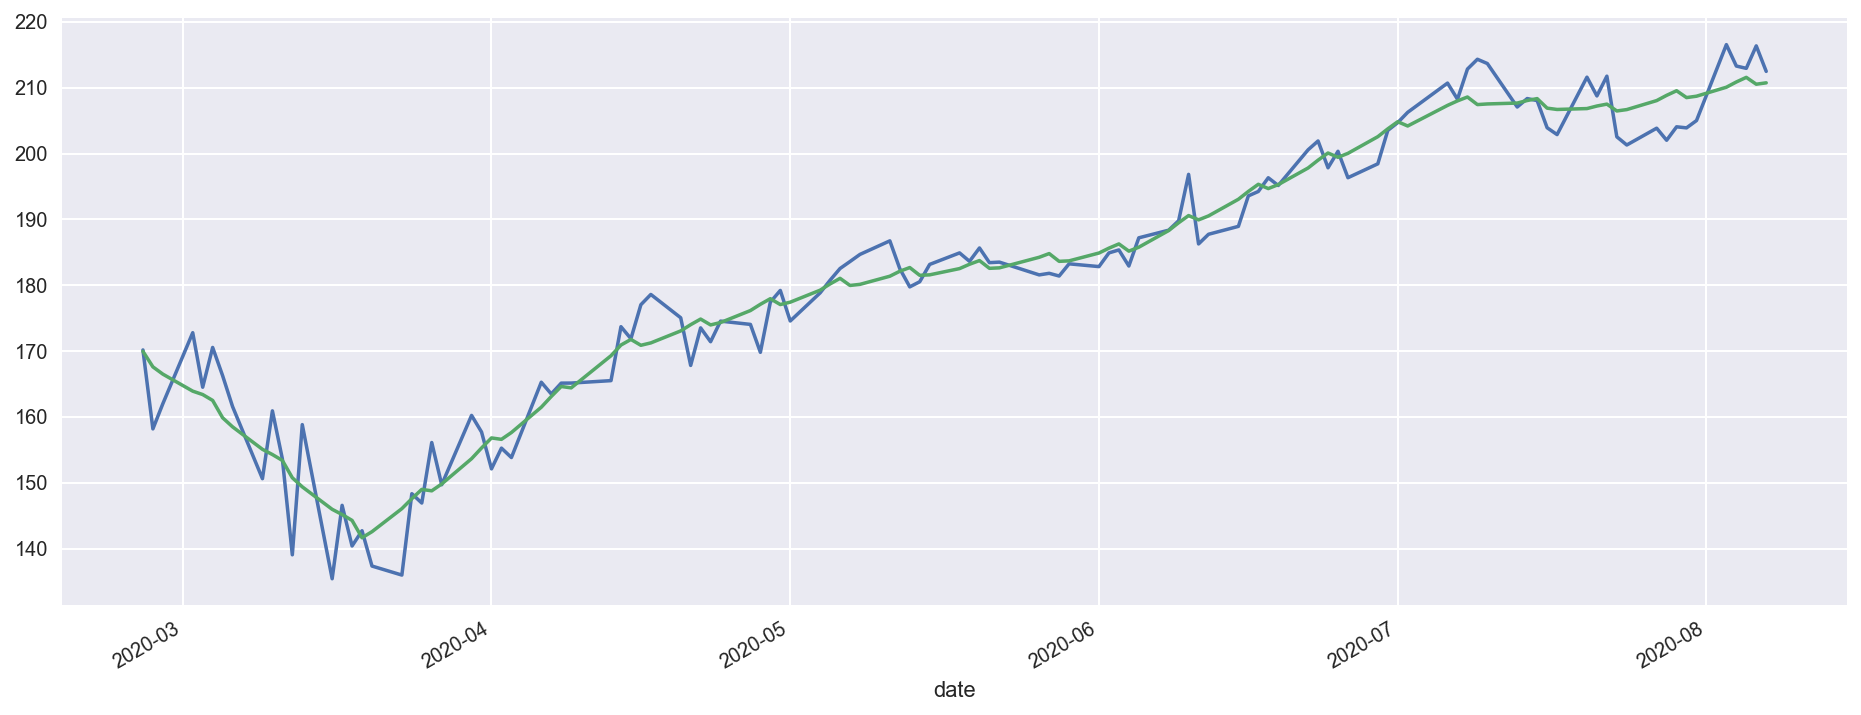

In [142]:
plt.figure(figsize=(16, 6))
df_train.value.plot()
forecast_yhat_head = forecast[["ds","yhat"]].head(len(forecast["yhat"]))
df_proph_head= df_train.merge(forecast_yhat_head, left_index=True, right_on="ds").yhat
df_proph_head.index= df_train.index
df_proph_head.plot()

In [143]:
# cuando haga las predicciones el modelo va a devolver en LOGARITMO, con lo cual luego voy a antirtnsformar
# antitransformará haciendo el Exponente
df_train['Prophet'] = df_proph_head
df_test['Prophet'] = df_proph_tail

In [144]:
df_train['Prophet'].isnull().sum()

0

In [145]:
model_prophet_RMSE = RMSE(df_test["Prophet"], df_test.value)
model_prophet_RMSE

5.677162408220519

In [146]:
# Calculamos el RMSE y almacenamos los resultados
df_Results.loc[13, "Model"] = 'Prophet'
df_Results.loc[13, "RMSE"] = RMSE(df_test['Prophet'], df_test.value)
df_Results

Model     RMSE
0                    Mean 32.51765
1             Random Walk  6.91949
2             LinearTrend  7.86980
3          QuadraticTrend  9.02761
4              Transf Log  9.60369
6        Simple Smoothing  6.87014
7   Exponential Smoothing  9.79673
8       Tendencia + ARIMA  9.89523
9               Diff + AR  7.84804
10              Diff + MA  7.96508
11           Diff + ARIMA  7.92761
12         Diff + SARIMAX  6.90160
13                Prophet  5.67716

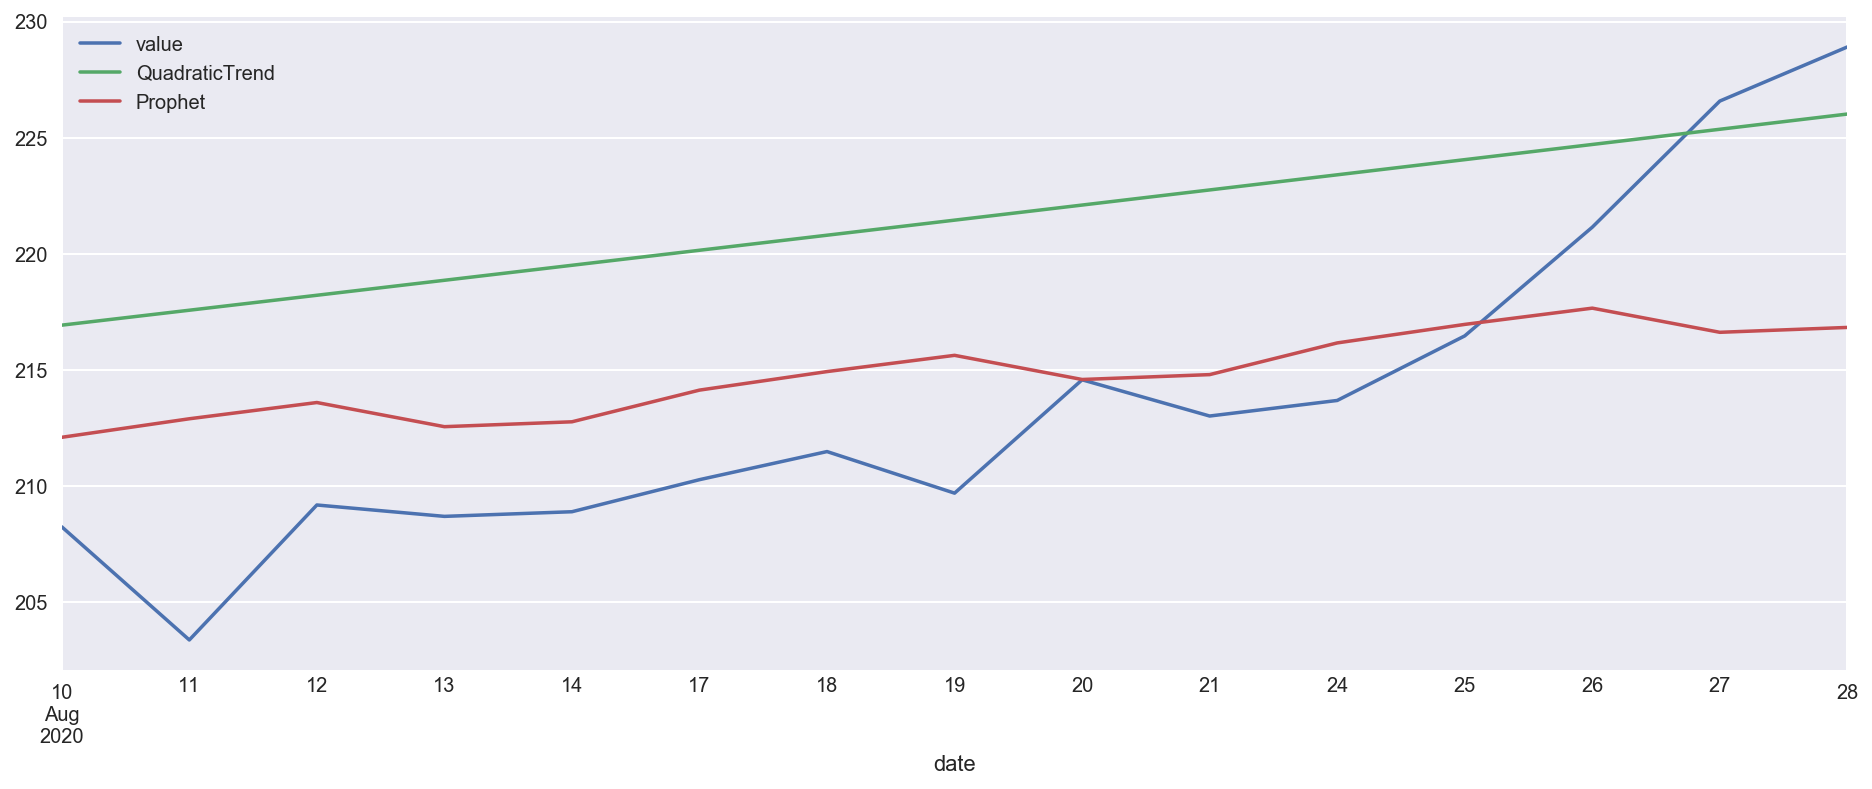

In [147]:
# Ploteamos las mejores estimaciones 
df_test.plot(kind = "line", y = ['value', 'QuadraticTrend', 'Prophet'], figsize=(16, 6));

#### 4.4 - REGRESORAS

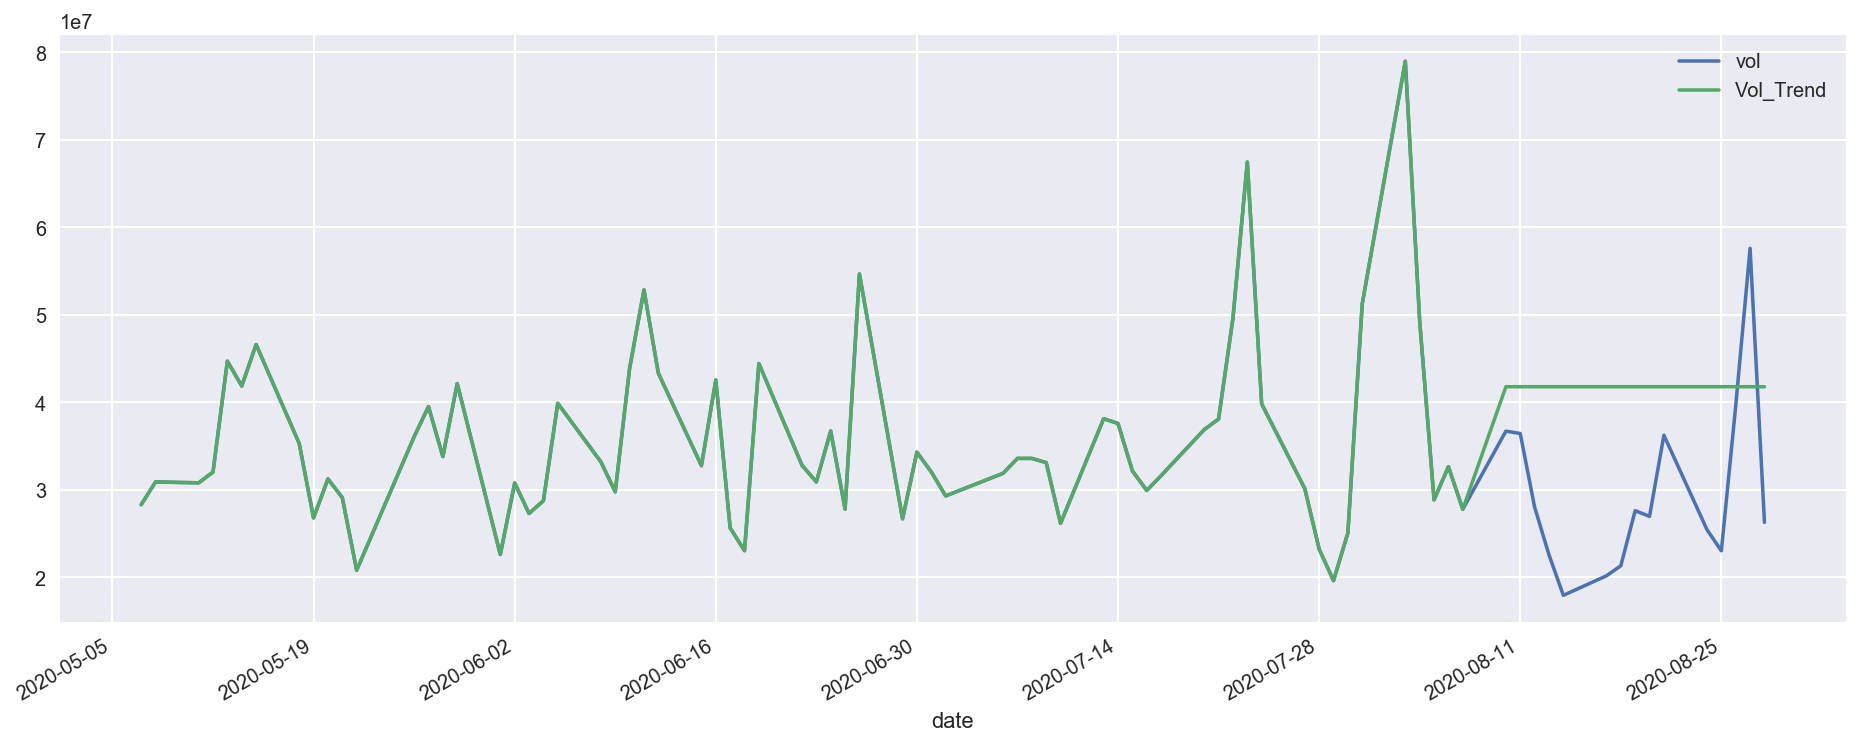

In [148]:
# ARMAMOS LA VARIABLE REGRESORA (Volumen Negociado de Acciones)

dfv= pd.DataFrame(df_msft['Volume'], columns=['MSFT'])
dfv.index.rename('date', inplace=True)
dfv.rename(columns={'MSFT' : 'vol'}, inplace=True)

dfv['year'] = [d.year for d in dfv.index]
dfv['month'] = [d.strftime('%b') for d in dfv.index]
dfv["timeIndex"] = pd.Series(np.arange(len(dfv['vol'])), index=dfv.index)
dfv["timeIndex_sq"] = dfv["timeIndex"]**2

# Armamos dfv2 para Predecir nuestra variable regresora utilizando
# los datos de los últimos xx días (para armar el eje de timeIndex desde 0)
dfv2= dfv.loc[(df_train.index[-1] - DateOffset(days=35)):(df_test.index[-1])] 
dfv2["timeIndex"] = pd.Series(np.arange(len(dfv2['vol'])), index=dfv2.index)
dfv2["timeIndex_sq"] = dfv2["timeIndex"]**2

# Ahora fiteamos nuestro modelo de regresión lineal entre value y timeIndex + timeIndex_sq

#para entrenar me quedo con 30 datos sin los de test
#dfv3= dfv2.loc[(df_train.index[-1] - DateOffset(days=30)):(df_test.index[0]- DateOffset(days=1))] 

model_quadratic = smf.ols('vol ~ timeIndex', data = dfv2).fit()

# value = a*t + b*t2 * c

# Observamos el summary del modelo:
model_quadratic.summary()

# PREDECIMOS sobre los datos de TEST (los de Train son los originales "vol"):

# TRAIN - Vol_Trend) 
# Primer parte de Vol_Trend son los datos verdaderos que usamos como regresora para entrenaro el modelo
dfv["Vol_Trend"] = dfv["vol"]

# TEST - Vol_Trend)
    # a) Podemos usar la regresiónlineal:
# dfv["Vol_Trend"].loc[df_test.index] = model_quadratic.predict(dfv2[["timeIndex","timeIndex_sq"]]).loc[df_test.index]
    
    # b) o asignar la media de los últimos x días
dfv["Vol_Trend"].loc[df_test.index] = dfv["vol"].loc[df_train.index].iloc[-100:].mean()

dfv.iloc[-80:].plot(kind = "line", y = ['vol', "Vol_Trend"], figsize=(16, 6));


In [149]:
# Preparamos los Datos como los requiere Prophet:

temp_train= dfv["Vol_Trend"].loc[df_train.index]
temp_train= pd.DataFrame(temp_train)
temp_train.columns = ["vol"]

df_train_prophet_REG = df_train_prophet.merge(temp_train, left_on="ds", right_index=True)


temp_test = dfv["Vol_Trend"].loc[df_test.index]
temp_test= pd.DataFrame(temp_test)
temp_test.columns = ["vol"]
temp_test

df_test_prophet_REG = df_test_prophet.merge(temp_test, left_on="ds", right_index=True)

vol_reg = pd.concat([df_train_prophet_REG.vol, df_test_prophet_REG.vol], ignore_index=True)

In [150]:
# -------------------------------------------------------------------------------------
m = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],\
            changepoint_range= best_params['changepoint_range'])

m.add_regressor('vol', prior_scale=0.5, mode='additive', standardize=True)

m.fit(df_train_prophet_REG)
#--------------------------------------------------------------------------------------

# Make predictions
# En future se guardar los Históricos +las Predicciones
future = m.make_future_dataframe(periods=prediction_size+2, include_history=True)
future = future[future.ds.dt.dayofweek < 5] # eliminamos los fines de semana ya que no tenemos datos
future.reset_index(inplace = True)
future['vol'] = vol_reg.values
forecast = m.predict(future)
forecast = forecast[forecast.ds.dt.dayofweek < 5]  # eliminamos los fines de semana ya que no tenemos datos


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


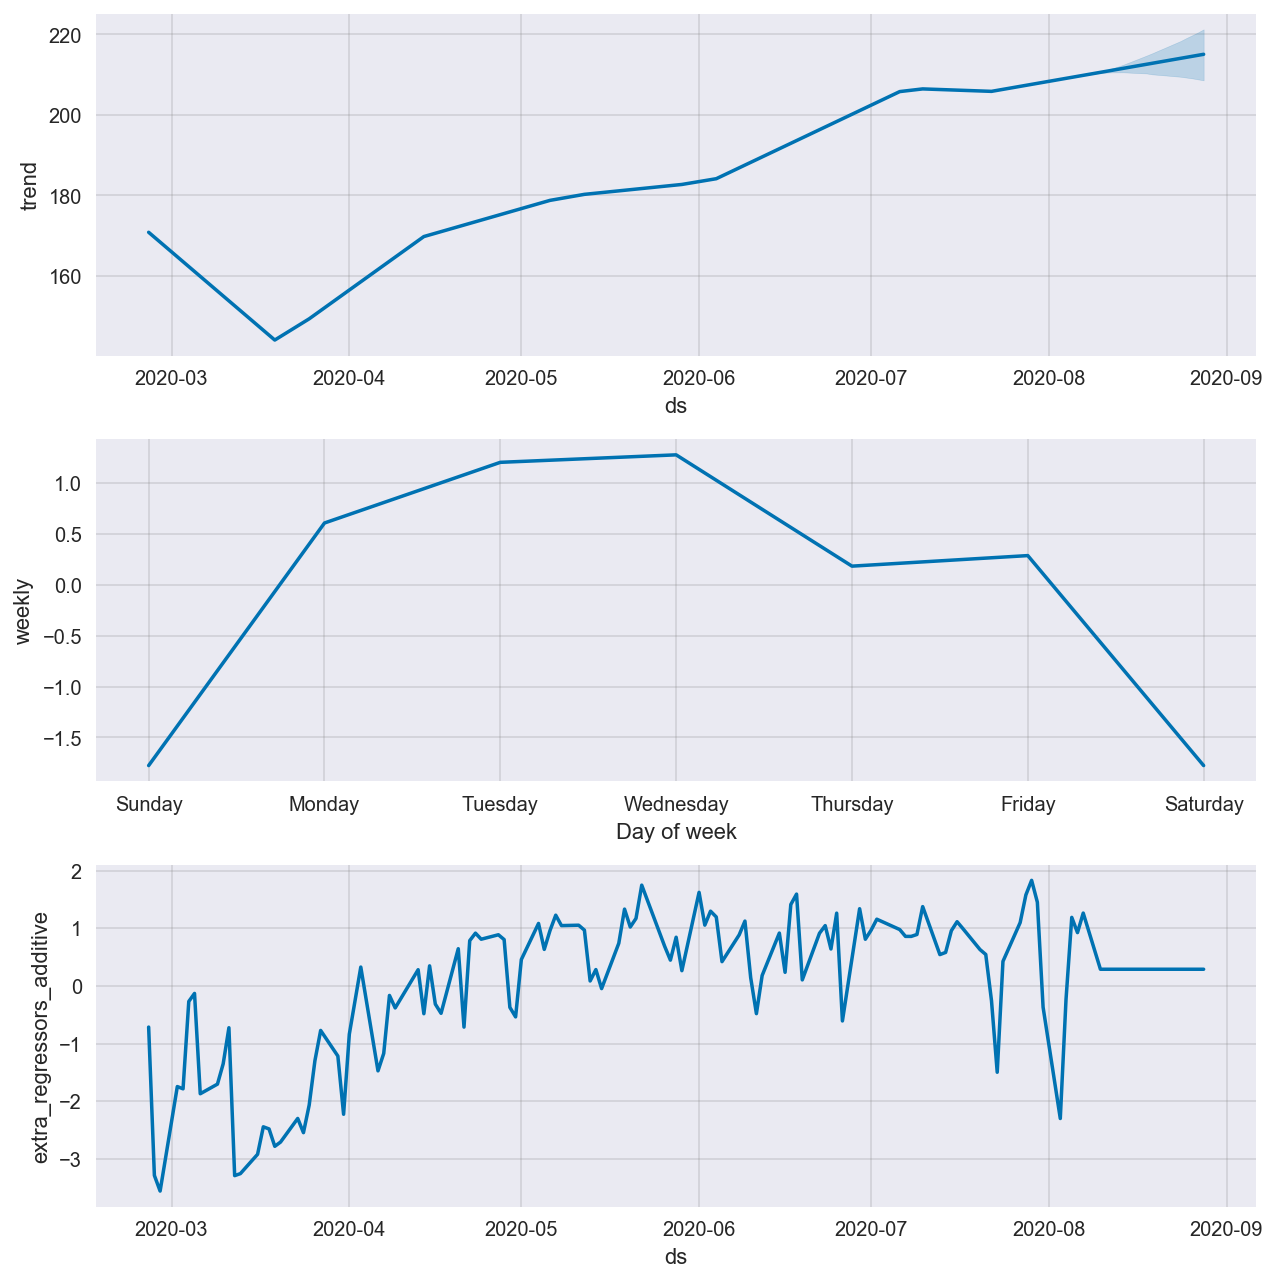

In [151]:
f = m.plot_components(forecast)

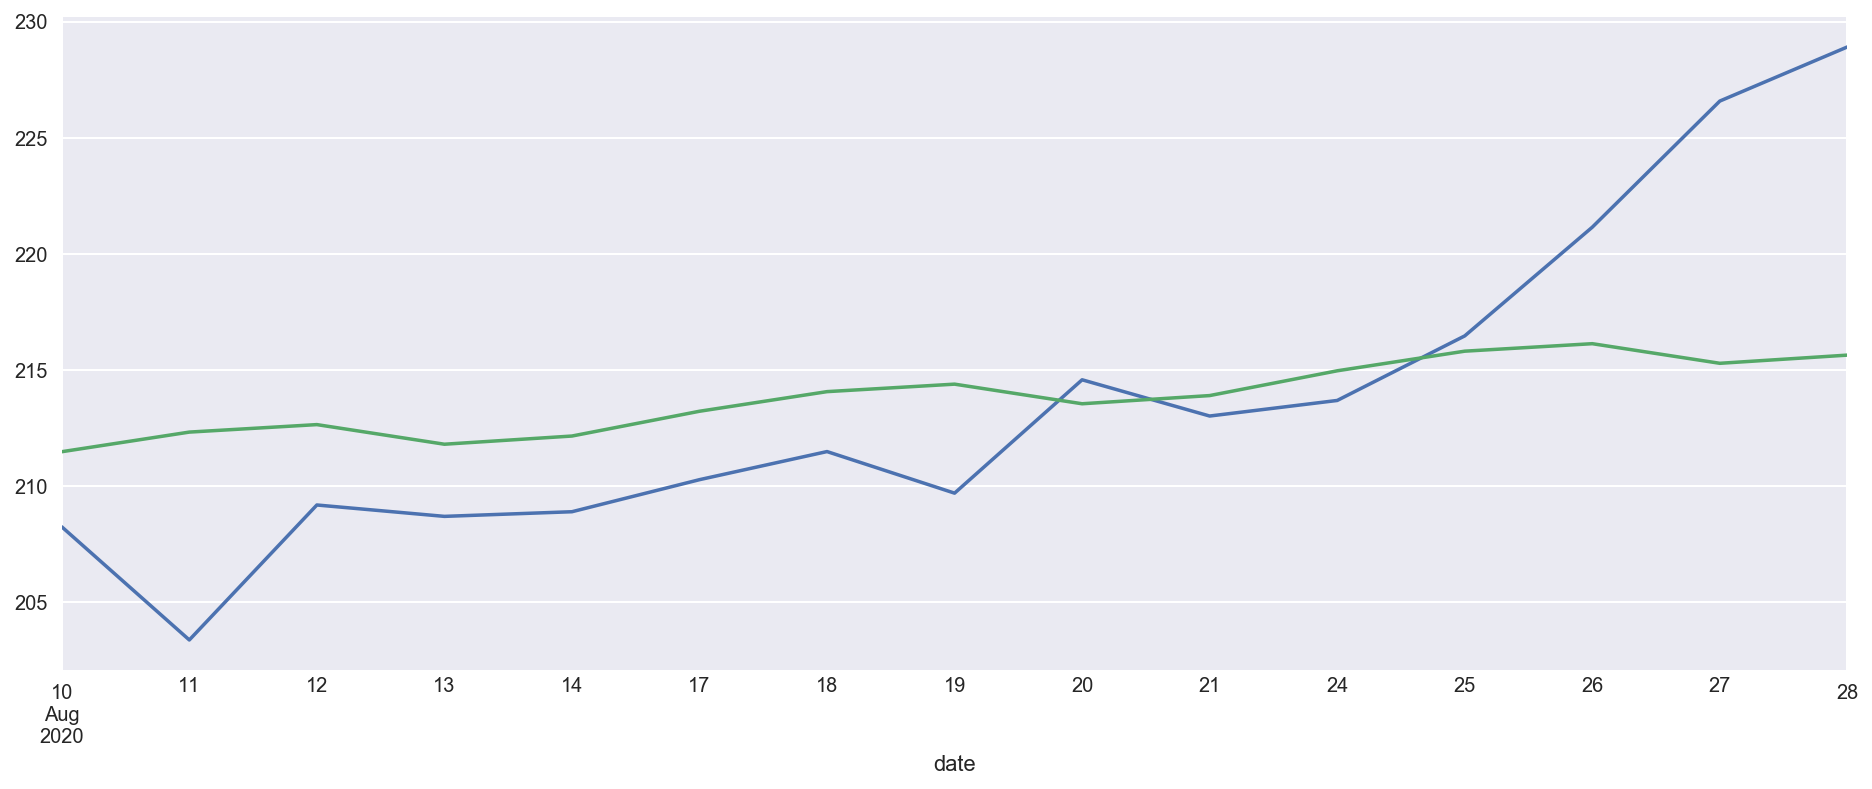

In [152]:
plt.figure(figsize=(16, 6))
df_test.value.plot()
forecast_yhat_tail = forecast[["ds","yhat"]].tail(prediction_size)
# Hacemos un Merges porque Prophet predice para los Fines de Semanas que no los tenemos
df_proph_tail= df_test.merge(forecast_yhat_tail, left_index=True, right_on="ds").yhat
df_proph_tail.index= df_test.index # me quedo con los últimos
df_proph_tail.plot()

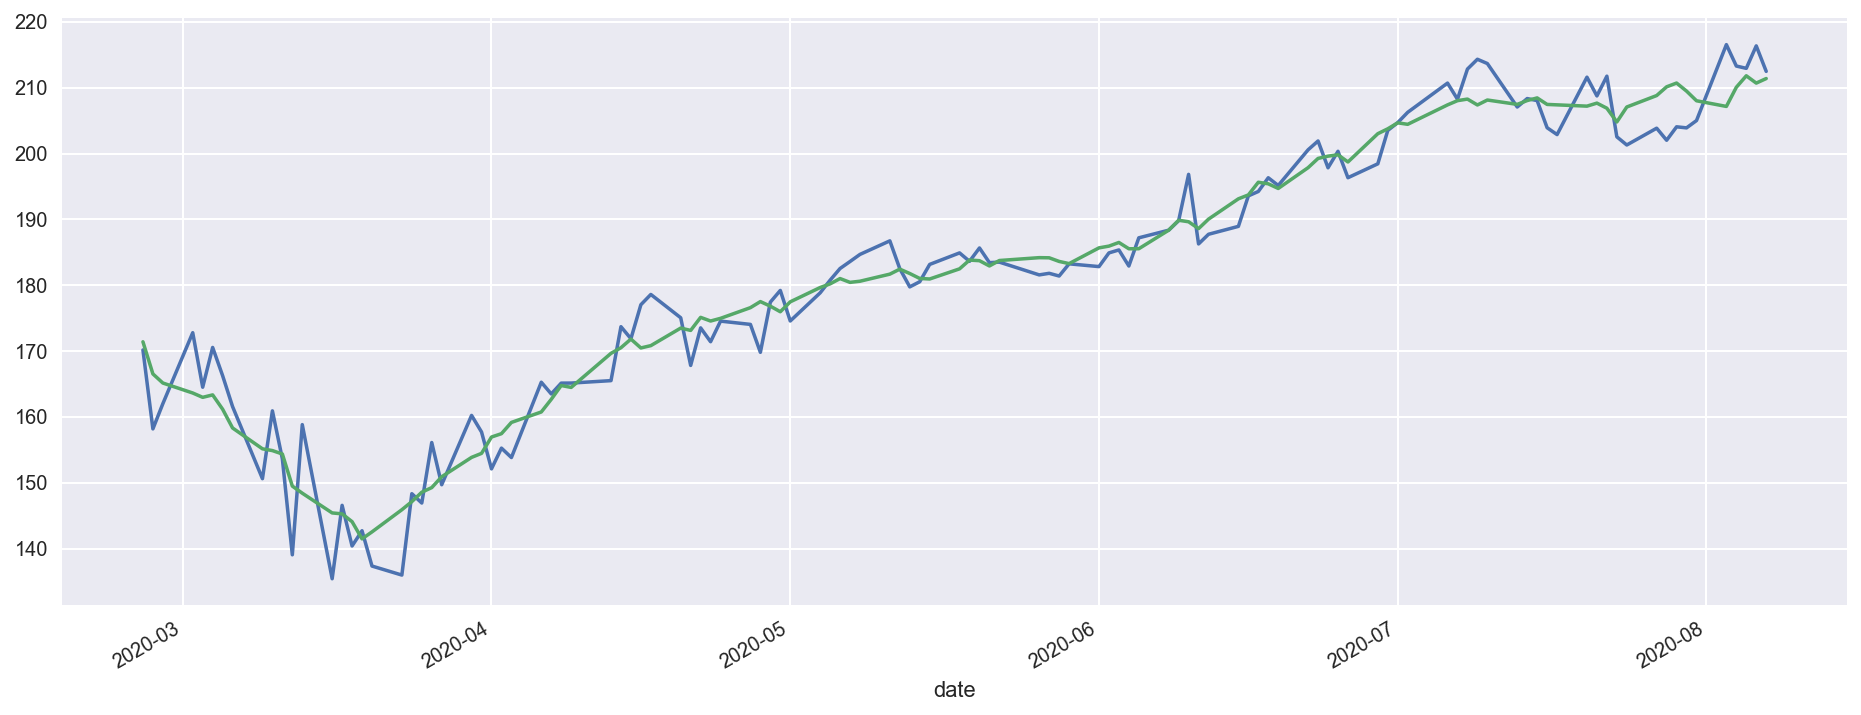

In [153]:
plt.figure(figsize=(16, 6))
df_train.value.plot()
forecast_yhat_head = forecast[["ds","yhat"]].head(len(forecast["yhat"]))
# Hacemos un Merges porque Prophet predice para los Fines de Semanas que no los tenemos
df_proph_head= df_train.merge(forecast_yhat_head, left_index=True, right_on="ds").yhat
df_proph_head.index= df_train.index
df_proph_head.plot()

In [154]:
# cuando haga las predicciones el modelo va a devolver en LOGARITMO, con lo cual luego voy a antirtnsformar
# antitransformará haciendo el Exponente
df_train['Prophet_REG'] = df_proph_head
df_test['Prophet_REG'] = df_proph_tail

In [155]:
# Calculamos el RMSE y almacenamos los resultados
df_Results.loc[14, "Model"] = 'Prophet_REG'
df_Results.loc[14, "RMSE"] = RMSE(df_test['Prophet_REG'], df_test.value)
df_Results

Model     RMSE
0                    Mean 32.51765
1             Random Walk  6.91949
2             LinearTrend  7.86980
3          QuadraticTrend  9.02761
4              Transf Log  9.60369
6        Simple Smoothing  6.87014
7   Exponential Smoothing  9.79673
8       Tendencia + ARIMA  9.89523
9               Diff + AR  7.84804
10              Diff + MA  7.96508
11           Diff + ARIMA  7.92761
12         Diff + SARIMAX  6.90160
13                Prophet  5.67716
14            Prophet_REG  5.73111

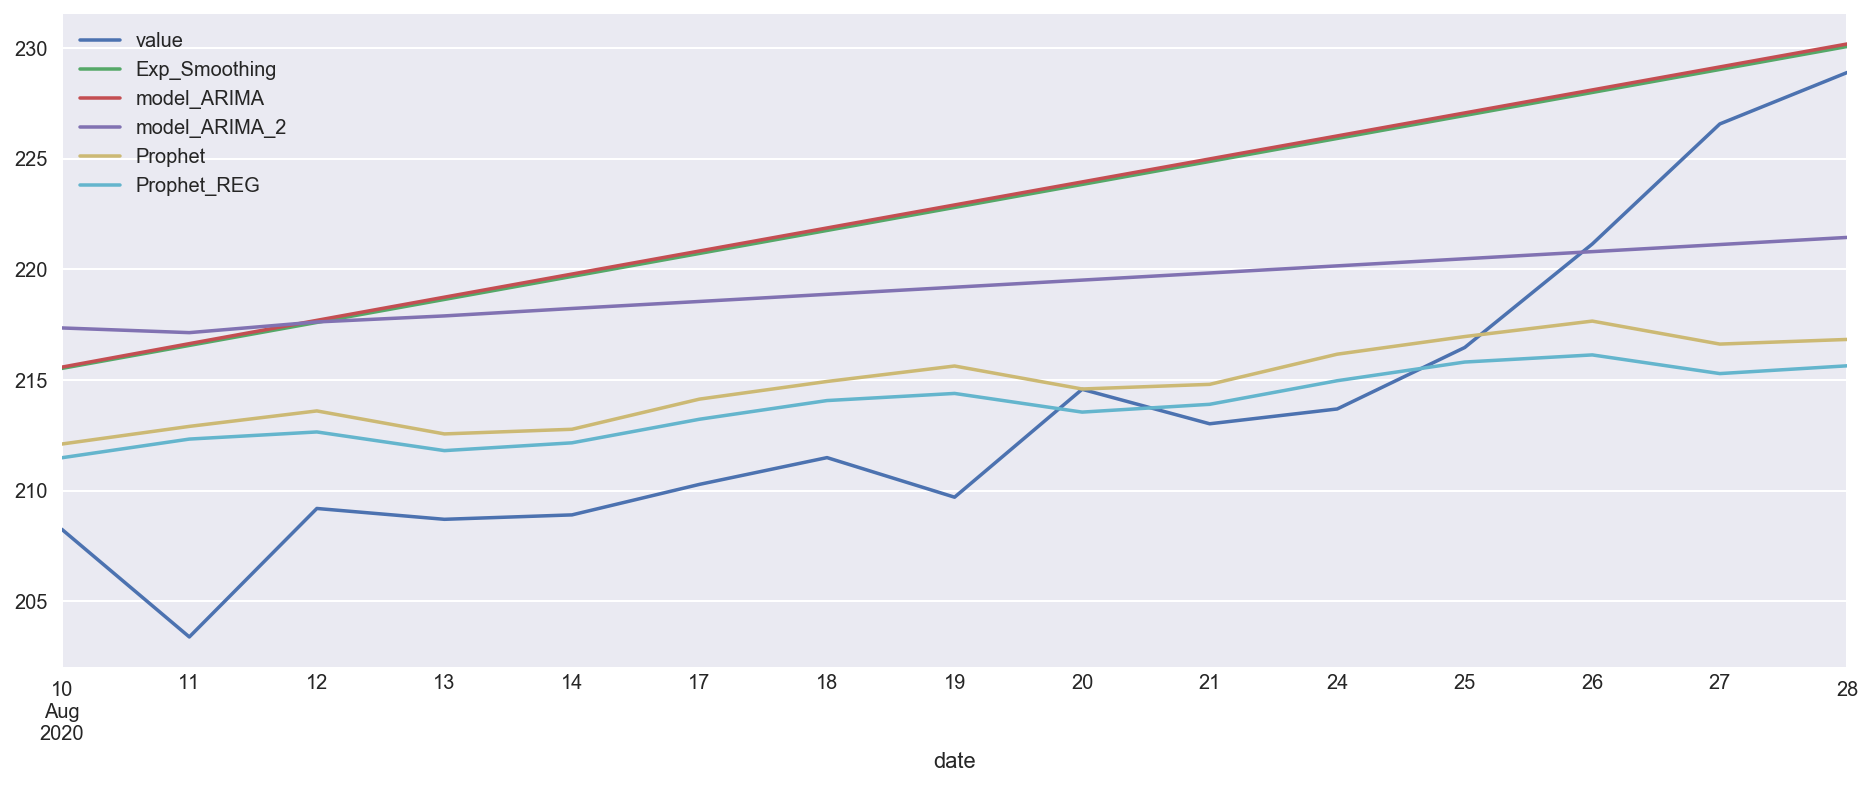

In [156]:
df_test.plot(kind="line", y = ["value", 'Exp_Smoothing', 'model_ARIMA',\
                               'model_ARIMA_2', 'Prophet', "Prophet_REG"], figsize=(16, 6));

---

In [157]:
# Acción de Microsoft
tickers = ['MSFT']

In [158]:
start_date = '2020-01-01'
end_date = '2020-08-30'

#end_date = datetime.datetime.now().strftime('%Y%m%d')

In [159]:
df_msft = data.DataReader(tickers, data_source='yahoo', start=start_date, end=end_date)

In [160]:
df_msft.columns = df_msft.columns.droplevel(1)

In [161]:
df_nasdaq_train = pd.read_csv('Data/NASDAQ20200401_train.csv');
df_nasdaq_test = pd.read_csv('Data/NASDAQ20200401_test.csv');

In [162]:
df_nasdaq_train.index = df_nasdaq_train['date']
df_nasdaq_test.index = df_nasdaq_test['date']

In [163]:
df_nasdaq_train.drop(columns=['date'], axis=1, inplace=True)

In [164]:
df_nasdaq_test.drop(columns=['date'], axis=1, inplace=True)

In [165]:
df_nasdaq_train.rename(columns={'value' : 'nasdaq'}, inplace=True)
df_nasdaq_test.rename(columns={'model_SARIMAX_mas_res' : 'nasdaq'}, inplace=True)

In [166]:
exogenous_features = ['nasdaq']

In [167]:
df_nasdaq_train.head(2)

nasdaq
date                 
2020-02-26 8980.78027
2020-02-27 8566.48047

In [168]:
df_nasdaq_test.head(2)

nasdaq
date                  
2020-08-10 10972.95872
2020-08-11 11078.38584

---

<a id="section_modelo_sarimax"></a> 
### 2 - Modelo SARIMAX

In [169]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
import os
import itertools
import warnings

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
def test_stationarity(timeseries,
                      maxlag=None, regression=None, autolag=None,
                      window=None, plot=False, verbose=False):
    '''
    Check unit root stationarity of time series.
    
    Null hypothesis: the series is non-stationary.
    If p >= alpha, the series is non-stationary.
    If p < alpha, reject the null hypothesis (has unit root stationarity).
    
    Original source: http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
    Function: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    
    window argument is only required for plotting rolling functions. Default=4.
    '''
    
    # set defaults (from function page)
    if regression is None:
        regression = 'c'
    
    if verbose:
        print('Running Augmented Dickey-Fuller test with paramters:')
        print('maxlag: {}'.format(maxlag))
        print('regression: {}'.format(regression))
        print('autolag: {}'.format(autolag))
    
    if plot:
        if window is None:
            window = 4
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=window, center=False).mean()
        rolstd = timeseries.rolling(window=window, center=False).std()
        
        #Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean ({})'.format(window))
        std = plt.plot(rolstd, color='black', label='Rolling Std ({})'.format(window))
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    #Perform Augmented Dickey-Fuller test:
    dftest = smt.adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used',
                                            ])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if verbose:
        print('Results of Augmented Dickey-Fuller Test:')
        print(dfoutput)
    return dfoutput

In [171]:
def model_resid_stats(model_results,
                      het_method='breakvar',
                      norm_method='jarquebera',
                      sercor_method='ljungbox',
                      verbose=True,
                      ):
    '''More information about the statistics under the ARIMA parameters table, tests of standardized residuals:
    
    Test of heteroskedasticity
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity

    Test of normality (Default: Jarque-Bera)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality

    Test of serial correlation (Default: Ljung-Box)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html
    '''
    # Re-run the ARIMA model statistical tests, and more. To be used when selecting viable models.
    (het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
    norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
    sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
    sercor_stat = sercor_stat[-1] # last number for the largest lag
    sercor_p = sercor_p[-1] # last number for the largest lag

    # Run Durbin-Watson test on the standardized residuals.
    # The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
    # Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
    # This statistic will always be between 0 and 4. The closer to 0 the statistic,
    # the more evidence for positive serial correlation. The closer to 4,
    # the more evidence for negative serial correlation.
    # Essentially, below 1 or above 3 is bad.
    dw_stat = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

    # check whether roots are outside the unit circle (we want them to be);
    # will be True when AR is not used (i.e., AR order = 0)
    arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
    # will be True when MA is not used (i.e., MA order = 0)
    maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)
    
    if verbose:
        print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
        print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
        print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
        print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw_stat))
        print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
        print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))
    
    stat = {'het_method': het_method,
            'het_stat': het_stat,
            'het_p': het_p,
            'norm_method': norm_method,
            'norm_stat': norm_stat,
            'norm_p': norm_p,
            'skew': skew,
            'kurtosis': kurtosis,
            'sercor_method': sercor_method,
            'sercor_stat': sercor_stat,
            'sercor_p': sercor_p,
            'dw_stat': dw_stat,
            'arroots_outside_unit_circle': arroots_outside_unit_circle,
            'maroots_outside_unit_circle': maroots_outside_unit_circle,
            }
    return stat

In [172]:
def model_gridsearch(ts,
                     p_min,
                     d_min,
                     q_min,
                     p_max,
                     d_max,
                     q_max,
                     sP_min,
                     sD_min,
                     sQ_min,
                     sP_max,
                     sD_max,
                     sQ_max,
                     trends,
                     exogenas=None,
                     s=None,
                     enforce_stationarity=True,
                     enforce_invertibility=True,
                     simple_differencing=False,
                     plot_diagnostics=False,
                     verbose=False,
                     filter_warnings=True,
                    ):
    '''Run grid search of SARIMAX models and save results.
    '''
    
    cols = ['p', 'd', 'q', 'sP', 'sD', 'sQ', 's', 'trend',
            'enforce_stationarity', 'enforce_invertibility', 'simple_differencing',
            'aic', 'bic',
            'het_p', 'norm_p', 'sercor_p', 'dw_stat',
            'arroots_gt_1', 'maroots_gt_1',
            'datetime_run']

    # Initialize a DataFrame to store the results
    df_results = pd.DataFrame(columns=cols)

    mod_num=0
    for trend,p,d,q,sP,sD,sQ in itertools.product(trends,
                                                  range(p_min,p_max+1),
                                                  range(d_min,d_max+1),
                                                  range(q_min,q_max+1),
                                                  range(sP_min,sP_max+1),
                                                  range(sD_min,sD_max+1),
                                                  range(sQ_min,sQ_max+1),
                                                  ):
        # initialize to store results for this parameter set
        this_model = pd.DataFrame(index=[mod_num], columns=cols)

        if p==0 and d==0 and q==0:
            continue

        try:
            model = sm.tsa.SARIMAX(ts,
                                   trend=trend,
                                   order=(p, d, q),
                                   seasonal_order=(sP, sD, sQ, s),
                                   enforce_stationarity=enforce_stationarity,
                                   enforce_invertibility=enforce_invertibility,
                                   simple_differencing=simple_differencing,
                                   exog=exogenas
                                  )
            
            if filter_warnings is True:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model_results = model.fit(disp=0)
            else:
                model_results = model.fit()

            if verbose:
                print(model_results.summary())

            if plot_diagnostics:
                model_results.plot_diagnostics();

            stat = model_resid_stats(model_results,
                                     verbose=verbose)

            this_model.loc[mod_num, 'p'] = p
            this_model.loc[mod_num, 'd'] = d
            this_model.loc[mod_num, 'q'] = q
            this_model.loc[mod_num, 'sP'] = sP
            this_model.loc[mod_num, 'sD'] = sD
            this_model.loc[mod_num, 'sQ'] = sQ
            this_model.loc[mod_num, 's'] = s
            this_model.loc[mod_num, 'trend'] = trend
            this_model.loc[mod_num, 'enforce_stationarity'] = enforce_stationarity
            this_model.loc[mod_num, 'enforce_invertibility'] = enforce_invertibility
            this_model.loc[mod_num, 'simple_differencing'] = simple_differencing
            this_model.loc[mod_num, 'aic'] = model_results.aic
            this_model.loc[mod_num, 'bic'] = model_results.bic
            this_model.loc[mod_num, 'het_p'] = stat['het_p']
            this_model.loc[mod_num, 'norm_p'] = stat['norm_p']
            this_model.loc[mod_num, 'sercor_p'] = stat['sercor_p']
            this_model.loc[mod_num, 'dw_stat'] = stat['dw_stat']
            this_model.loc[mod_num, 'arroots_gt_1'] = stat['arroots_outside_unit_circle']
            this_model.loc[mod_num, 'maroots_gt_1'] = stat['maroots_outside_unit_circle']

            this_model.loc[mod_num, 'datetime_run'] = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')

            df_results = df_results.append(this_model)
            mod_num+=1
        except:
            continue
    return df_results

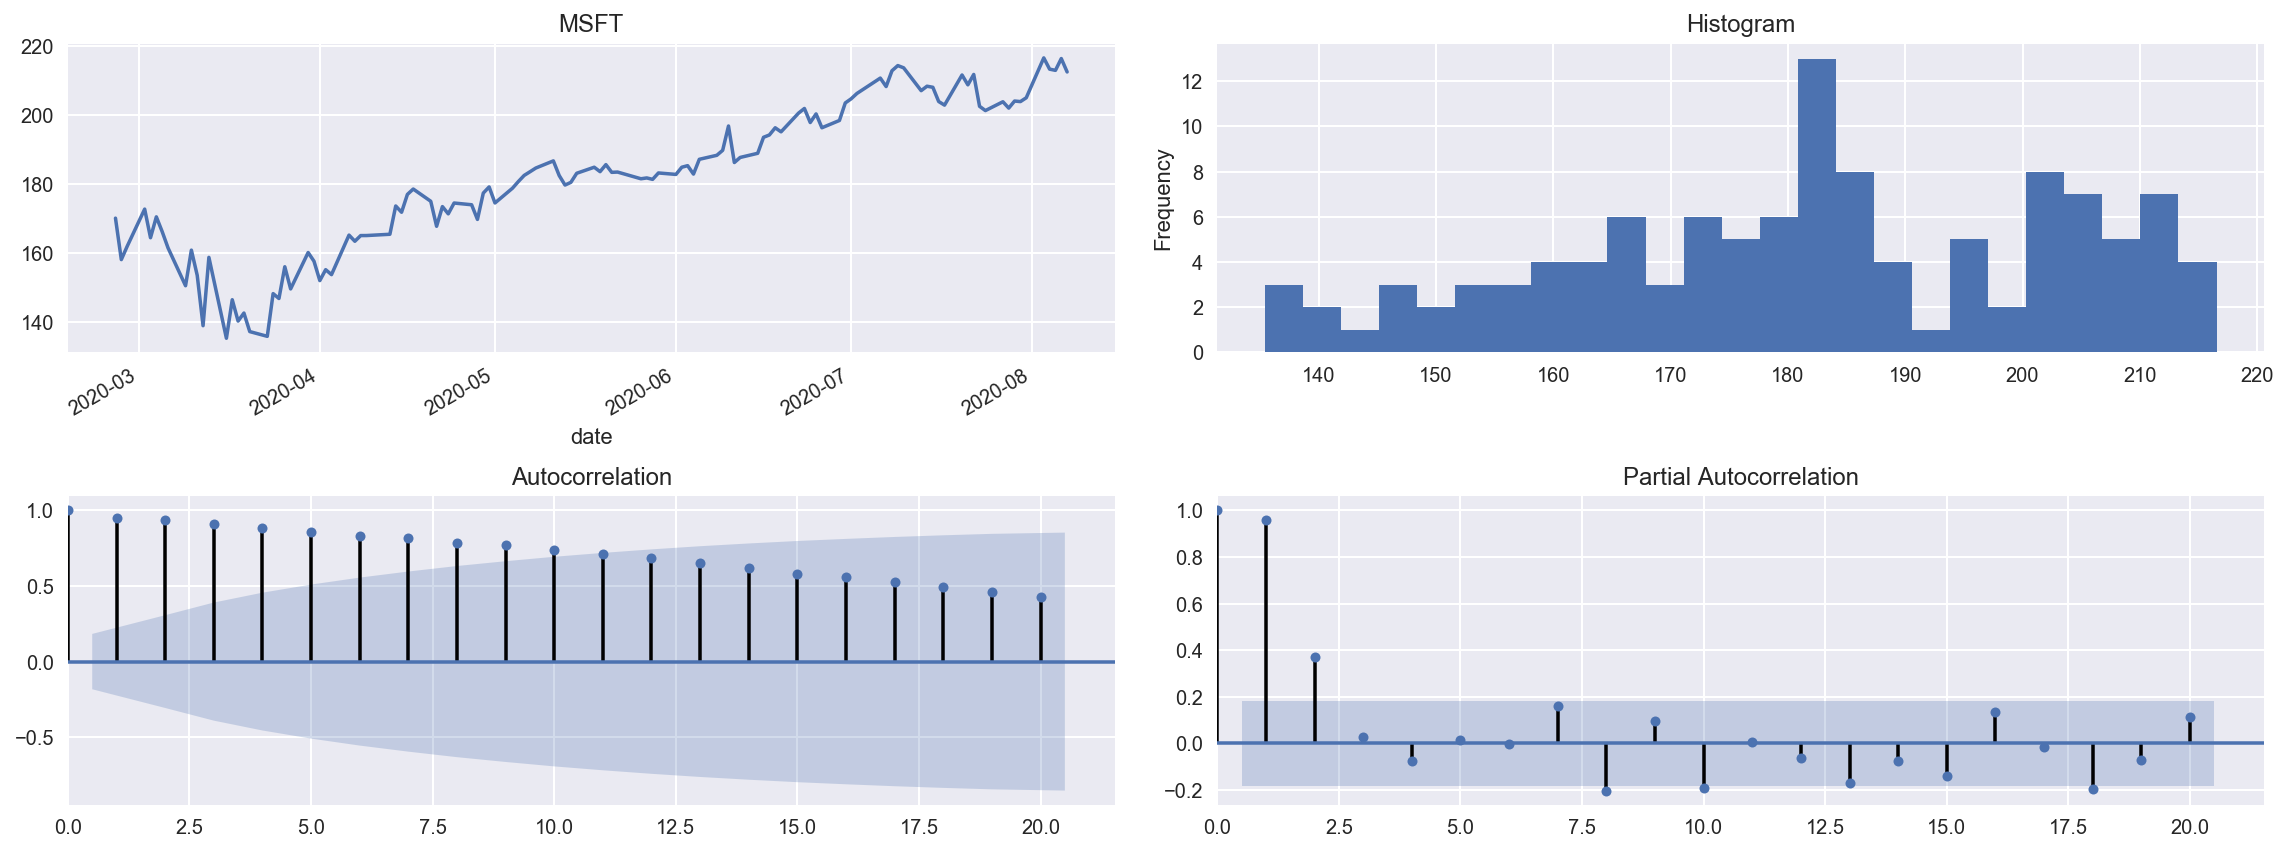

In [173]:
def tsplot(y, lags=None, title='', figsize=(16, 6)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

tsplot(df_train.value, title='MSFT', lags=20);

In [174]:
# HACEMOS UN GRIDSEARH PARA LOS PARÁMETROS DE TODO (LA PARTE DE SIN y CON SEASONAL) ARIMA / SARIMA

p_min = 5
d_min = 1
q_min = 1
p_max = 7
d_max = 2
q_max = 2

sP_min = 0
sD_min = 0
sQ_min = 0
sP_max = 0
sD_max = 0
sQ_max = 0

s=0

trends=['n', 'c']

enforce_stationarity=False
enforce_invertibility=False
simple_differencing=False

plot_diagnostics=False

verbose=False

df_results = model_gridsearch(df_train.value,
                              p_min,
                              d_min,
                              q_min,
                              p_max,
                              d_max,
                              q_max,
                              sP_min,
                              sD_min,
                              sQ_min,
                              sP_max,
                              sD_max,
                              sQ_max,
                              trends,
                              df_nasdaq_train[exogenous_features],
                              s=s,
                              enforce_stationarity=enforce_stationarity,
                              enforce_invertibility=enforce_invertibility,
                              simple_differencing=simple_differencing,
                              plot_diagnostics=plot_diagnostics,
                              verbose=verbose
                              )

In [175]:
# Elegiríamos el modelo con el mayor sercor_p
df_results.sort_values(by='sercor_p', ascending=False).head(10)

p  d  q sP sD sQ  s trend enforce_stationarity enforce_invertibility  \
21  7  1  2  0  0  0  0     c                False                 False   
9   7  1  2  0  0  0  0     n                False                 False   
20  7  1  1  0  0  0  0     c                False                 False   
8   7  1  1  0  0  0  0     n                False                 False   
19  6  2  2  0  0  0  0     c                False                 False   
17  6  1  2  0  0  0  0     c                False                 False   
5   6  1  2  0  0  0  0     n                False                 False   
7   6  2  2  0  0  0  0     n                False                 False   
23  7  2  2  0  0  0  0     c                False                 False   
11  7  2  2  0  0  0  0     n                False                 False   

   simple_differencing       aic       bic   het_p  norm_p sercor_p dw_stat  \
21               False 449.31266 481.38661 0.15851 0.00005  0.94793 1.93782   
9                False 447.37960 476.78072 0.14760 0.00005  0.94732 1.93867   
20               False 447.24746 476.64858 0.16121 0.00007  0.94653 1.93772   
8                False 445.31942 472.04771 0.14988 0.00006  0.94593 1.93851   
19               False 450.00307 479.40419 0.14961 0.00000  0.93235 1.99532   
17               False 451.88557 481.38901 0.17635 0.00000  0.89972 1.96824   
5                False 449.97040 476.79171 0.16304 0.00000  0.89543 1.97373   
7                False 449.83317 476.56146 0.15702 0.00000  0.87632 1.97683   
23               False 444.60767 476.56893 0.06760 0.00000  0.85832 2.00571   
11               False 443.32802 472.62585 0.09739 0.00000  0.85811 2.00247   

   arroots_gt_1 maroots_gt_1         datetime_run  
21         True         True  2020-09-04 22:11:21  
9          True         True  2020-09-04 22:11:15  
20         True         True  2020-09-04 22:11:21  
8          True         True  2020-09-04 22:11:15  
19         True        False  2020-09-04 22:11:20  
17         True         True  2020-09-04 22:11:19  
5          True         True  2020-09-04 22:11:14  
7          True         True  2020-09-04 22:11:15  
23         True         True  2020-09-04 22:11:22  
11         True         True  2020-09-04 22:11:17

In [176]:
model_SARIMAX = sm.tsa.SARIMAX(df_train.value,
                                   trend="c",
                                   order=(5, 1, 2),
                                   seasonal_order=(0, 0, 0, 0),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False,
                                   simple_differencing=False,
                                   exog=df_nasdaq_train[exogenous_features]
                                  )
# Estimo el modelo:
results_SARIMAX = model_SARIMAX.fit()
results_SARIMAX.fittedvalues.head()

date
2020-02-26   201.59365
2020-02-27   160.12500
2020-02-28   148.01861
2020-03-02   168.11576
2020-03-03   167.91702
dtype: float64

##### Guardamos las Prediccones del modelo SARIMAX

In [177]:
predictions_SARIMAX = results_SARIMAX.forecast(len(df_test['value']), alpha=0.05, exog=df_nasdaq_test[exogenous_features])

In [178]:
predictions_SARIMAX.index = df_test.index

In [179]:
df_test['model_SARIMAX_NASDAQ'] = predictions_SARIMAX

In [180]:
df_train['model_SARIMAX_NASDAQ'] = results_SARIMAX.fittedvalues

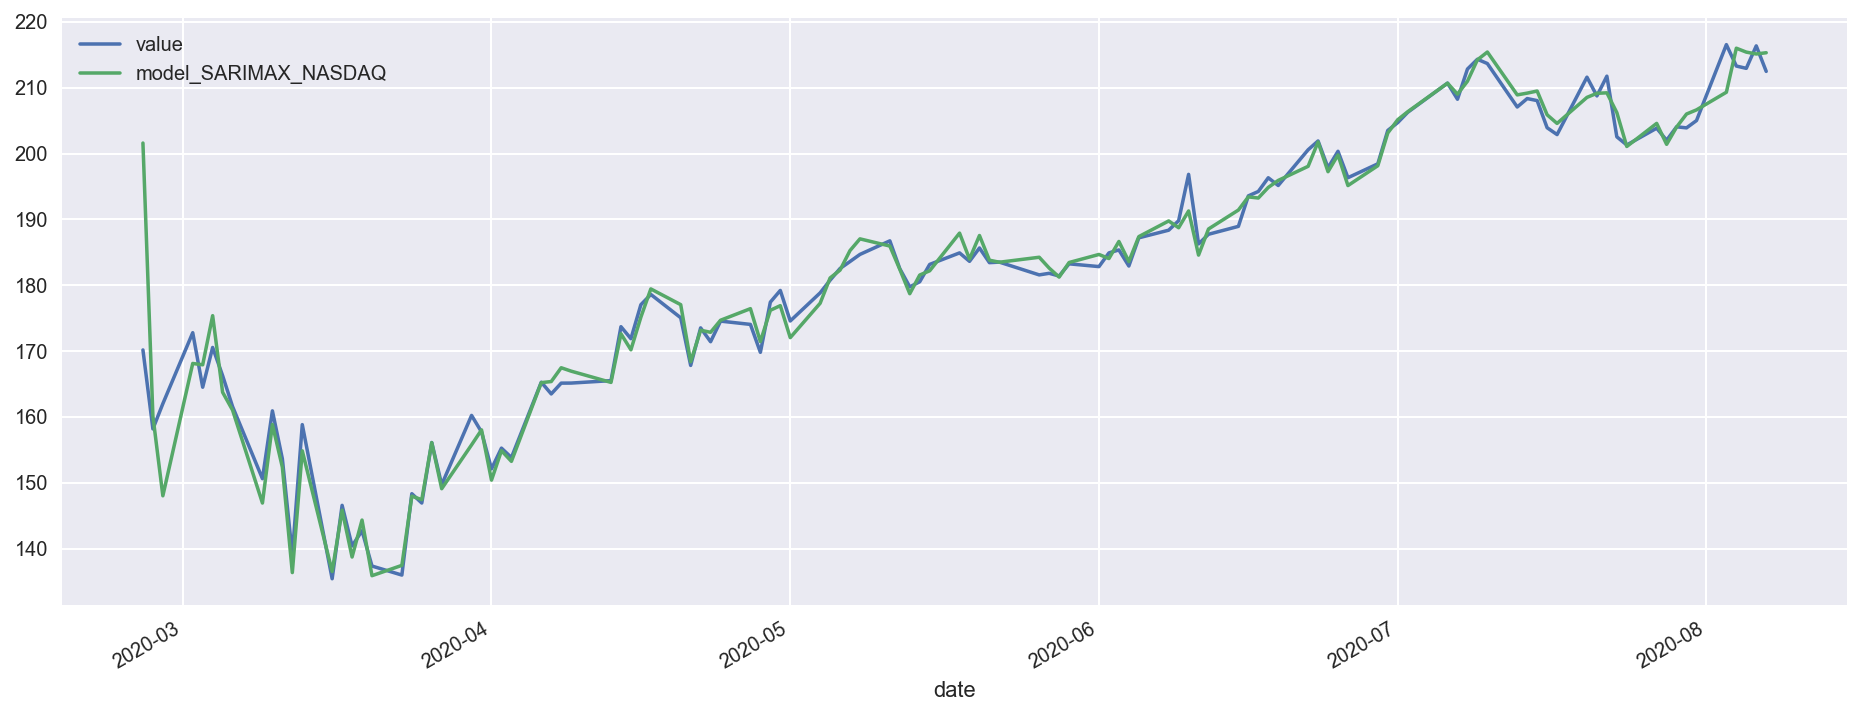

In [181]:
df_train.plot(kind = "line", y = ['value', 'model_SARIMAX_NASDAQ'], figsize=(16, 6));

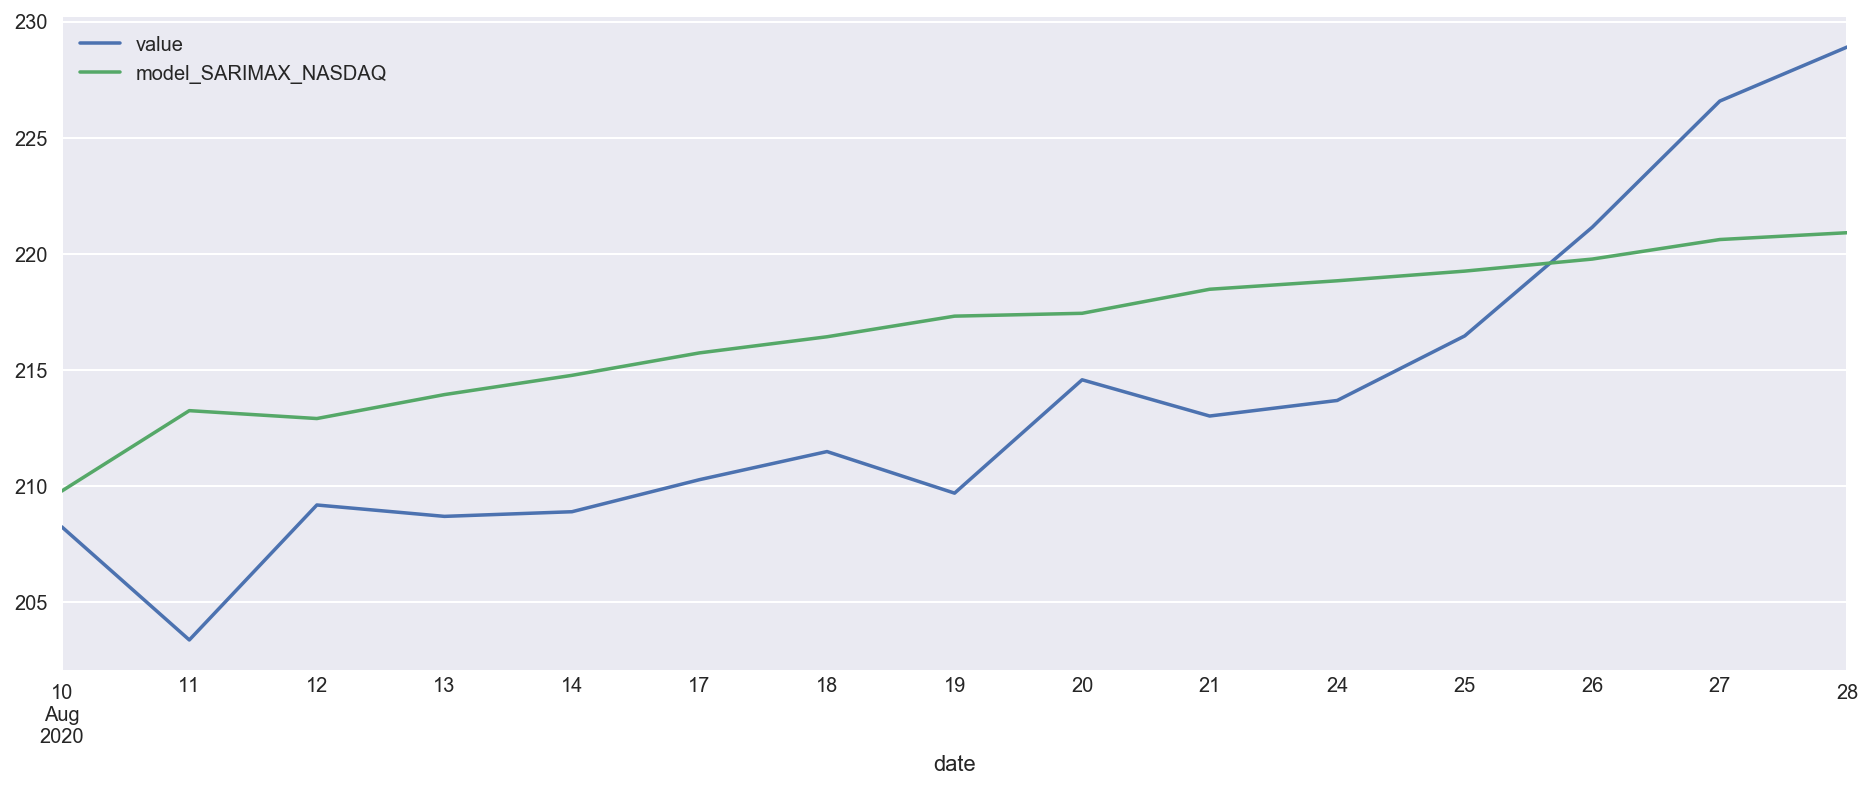

In [182]:
df_test.plot(kind = "line", y = ['value', 'model_SARIMAX_NASDAQ'], figsize=(16, 6));

---

In [183]:
res_SARIMAX = df_train.value - results_SARIMAX.fittedvalues

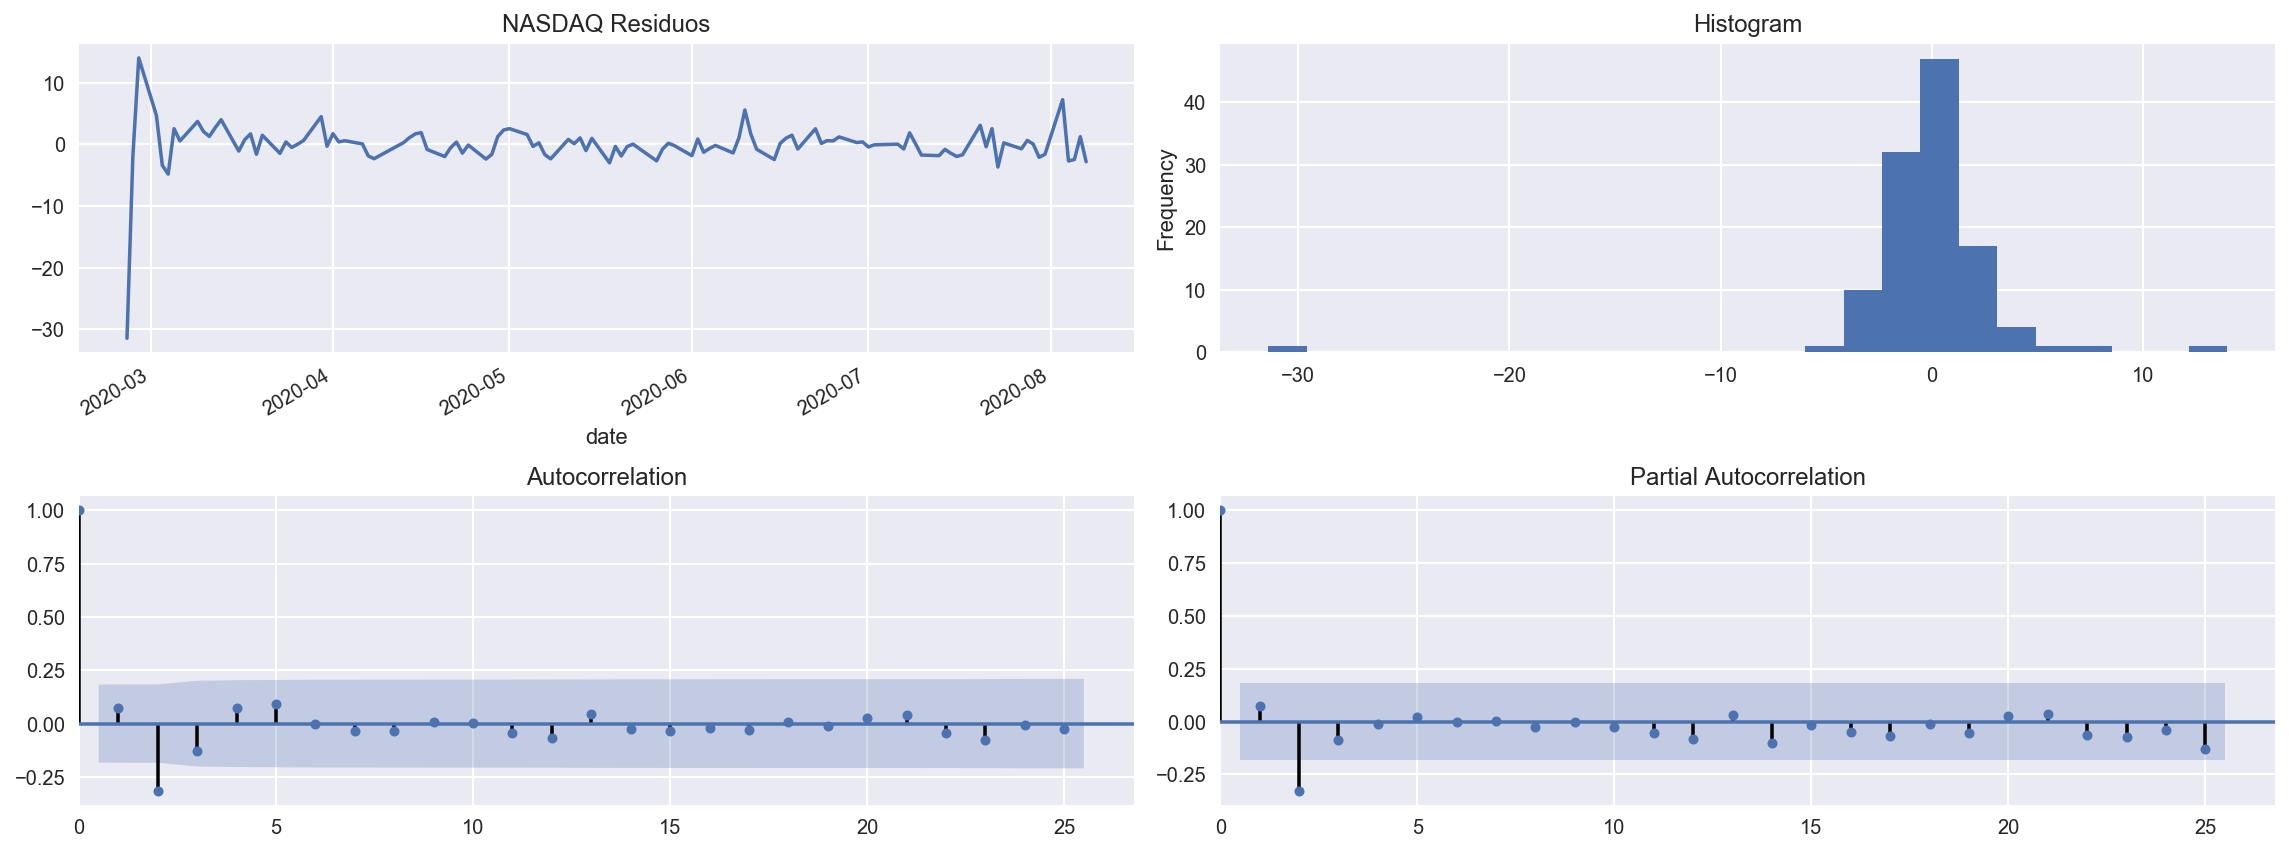

In [184]:
tsplot(res_SARIMAX, title='NASDAQ Residuos', lags=25);

In [185]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(res_SARIMAX)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -15.903472
p-value: 0.000000
Valor crítico 1%: -3.49
Valor crítico 5%: -2.89
Valor crítico 10%: -2.58


In [186]:
# HACEMOS UN GRIDSEARH PARA LOS PARÁMETROS DE TODO (LA PARTE DE SIN y CON SEASONAL) ARIMA / SARIMA

p_min2 = 1
d_min2 = 0
q_min2 = 1
p_max2 = 2
d_max2 = 2
q_max2 = 2

sP_min2 = 0
sD_min2 = 0
sQ_min2 = 0
sP_max2 = 0
sD_max2 = 0
sQ_max2 = 0

s2=0

trends2=['n', 'c']

enforce_stationarity2=False
enforce_invertibility2=False
simple_differencing2=False

plot_diagnostics2=False

verbose2=False

df_results2 = model_gridsearch(res_SARIMAX,
                              p_min2,
                              d_min2,
                              q_min2,
                              p_max2,
                              d_max2,
                              q_max2,
                              sP_min2,
                              sD_min2,
                              sQ_min2,
                              sP_max2,
                              sD_max2,
                              sQ_max2,
                              trends2,
                              s=s2,
                              enforce_stationarity=enforce_stationarity2,
                              enforce_invertibility=enforce_invertibility2,
                              simple_differencing=simple_differencing2,
                              plot_diagnostics=plot_diagnostics2,
                              verbose=verbose2
                              )

In [187]:
df_results2.sort_values(by='sercor_p', ascending=False).head(10)

p  d  q sP sD sQ  s trend enforce_stationarity enforce_invertibility  \
0   1  0  1  0  0  0  0     n                False                 False   
12  1  0  1  0  0  0  0     c                False                 False   
3   1  1  2  0  0  0  0     n                False                 False   
19  2  0  2  0  0  0  0     c                False                 False   
7   2  0  2  0  0  0  0     n                False                 False   
13  1  0  2  0  0  0  0     c                False                 False   
1   1  0  2  0  0  0  0     n                False                 False   
15  1  1  2  0  0  0  0     c                False                 False   
17  1  2  2  0  0  0  0     c                False                 False   
14  1  1  1  0  0  0  0     c                False                 False   

   simple_differencing       aic       bic   het_p  norm_p sercor_p dw_stat  \
0                False 507.08300 515.26517 0.02473 0.00000  0.89948 1.49585   
12               False 506.11991 517.02946 0.02180 0.00000  0.86872 1.51956   
3                False 501.19677 512.03489 0.20248 0.00000  0.84701 1.79855   
19               False 461.82237 478.13337 0.25623 0.00000  0.80297 2.00038   
7                False 459.87097 473.46346 0.27104 0.00000  0.80219 2.00008   
13               False 472.28108 485.87358 0.99796 0.00025  0.79956 1.97162   
1                False 470.28171 481.15570 0.99606 0.00025  0.79939 1.97170   
15               False 500.74402 514.29167 0.23364 0.00000  0.72553 1.80500   
17               False 476.81205 490.31445 0.84807 0.00015  0.60252 1.77213   
14               False 487.35284 498.22683 0.30397 0.00000  0.57593 1.60732   

   arroots_gt_1 maroots_gt_1         datetime_run  
0          True         True  2020-09-04 22:11:26  
12         True        False  2020-09-04 22:11:27  
3          True        False  2020-09-04 22:11:26  
19         True         True  2020-09-04 22:11:28  
7          True         True  2020-09-04 22:11:27  
13         True         True  2020-09-04 22:11:27  
1          True         True  2020-09-04 22:11:26  
15         True        False  2020-09-04 22:11:28  
17         True         True  2020-09-04 22:11:28  
14         True        False  2020-09-04 22:11:27

In [188]:
model_SARIMAX_res = sm.tsa.SARIMAX(res_SARIMAX,
                                   trend="c",
                                   order=(1, 1, 1),
                                   seasonal_order=(0, 0, 0, 0),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False,
                                   simple_differencing=False
                                  )
# Estimo el modelo:
results_SARIMAX_res = model_SARIMAX_res.fit()
results_SARIMAX_res.fittedvalues.head()

date
2020-02-26     0.00000
2020-02-27   -29.85978
2020-02-28    -4.91791
2020-03-02     2.92343
2020-03-03     4.42894
dtype: float64

In [189]:
predictions_SARIMAX_res = results_SARIMAX_res.forecast(len(df_test['value']), alpha=0.05)

In [190]:
predictions_SARIMAX_res.index = df_test.index

In [191]:
df_test['model_SARIMAX_NASDAQ_res'] = predictions_SARIMAX_res

In [192]:
df_test['model_SARIMAX_NASDAQ_res_value'] = df_test.value - df_test['model_SARIMAX_NASDAQ']

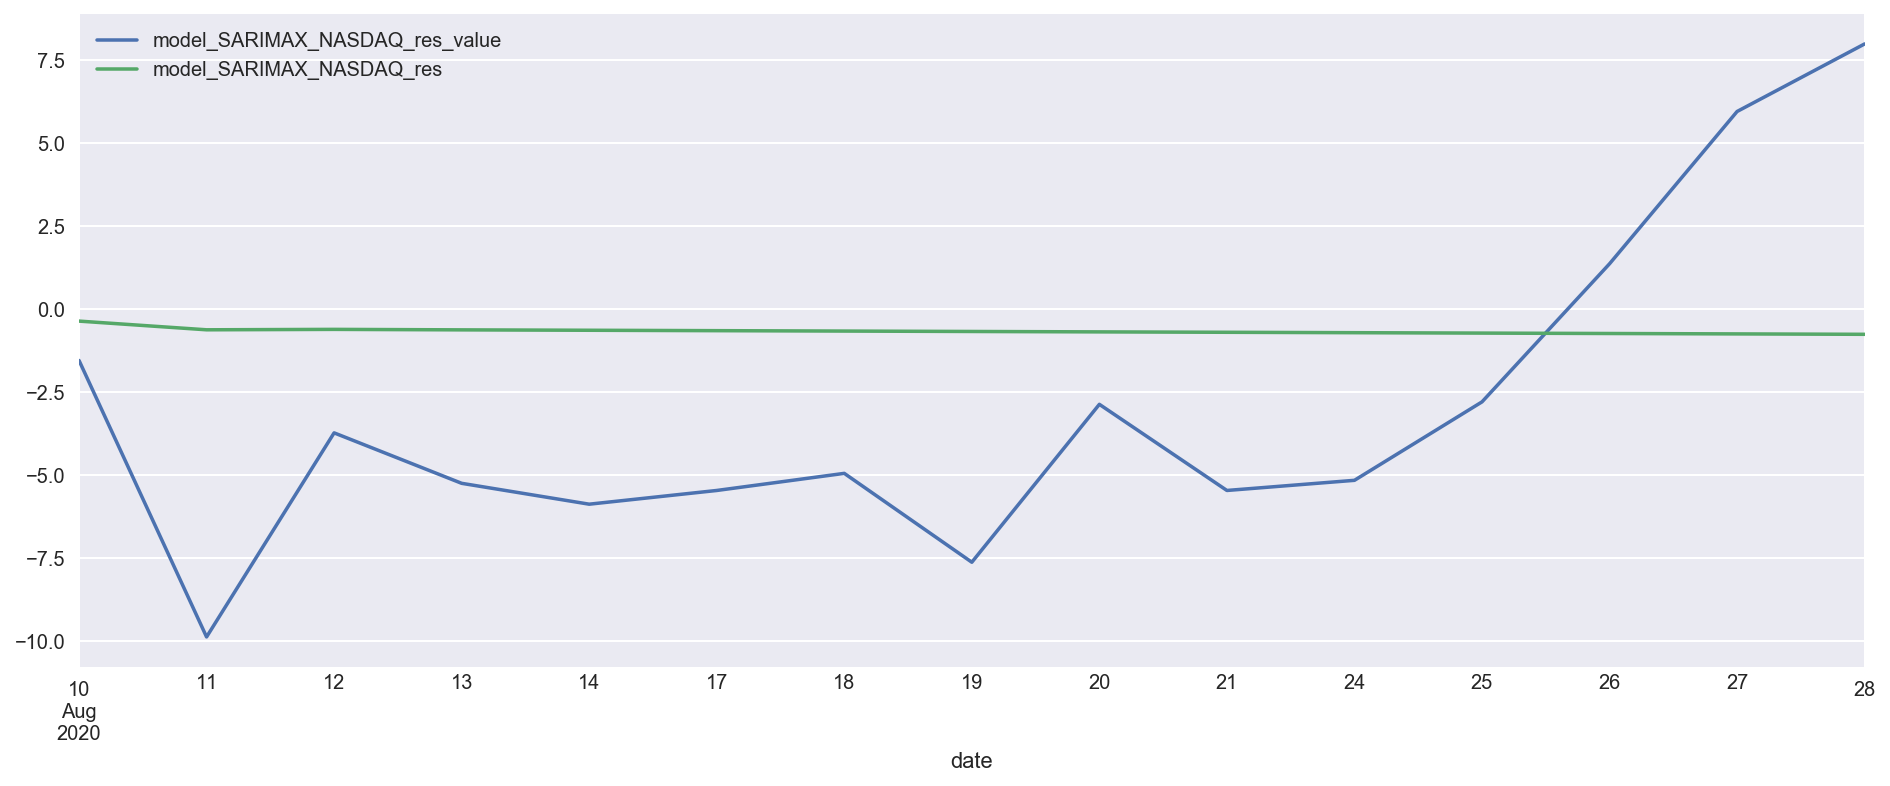

In [193]:
df_test.plot(kind = "line", y = ['model_SARIMAX_NASDAQ_res_value', 'model_SARIMAX_NASDAQ_res'], figsize=(16, 6));

In [194]:
RMSE(df_test['model_SARIMAX_NASDAQ_res'], df_test['model_SARIMAX_NASDAQ_res_value'])

5.247304646562536

In [195]:
# Sumamos la predicción de los de residuos o la predicción de la serie original
predictions_SARIMAX_mas_res = predictions_SARIMAX + predictions_SARIMAX_res

In [196]:
# Error de las predicciones + predicciones reiduos
df_Results.loc[10, "Model"] = "SARIMAX + NASDAQ + Residuos"
df_Results.loc[10, "RMSE"] = RMSE(predictions_SARIMAX_mas_res, df_test.value)
df_Results

Model     RMSE
0                          Mean 32.51765
1                   Random Walk  6.91949
2                   LinearTrend  7.86980
3                QuadraticTrend  9.02761
4                    Transf Log  9.60369
6              Simple Smoothing  6.87014
7         Exponential Smoothing  9.79673
8             Tendencia + ARIMA  9.89523
9                     Diff + AR  7.84804
10  SARIMAX + NASDAQ + Residuos  5.24730
11                 Diff + ARIMA  7.92761
12               Diff + SARIMAX  6.90160
13                      Prophet  5.67716
14                  Prophet_REG  5.73111

In [197]:
df_test['model_SARIMAX_NASDAQ_mas_res'] = predictions_SARIMAX_mas_res

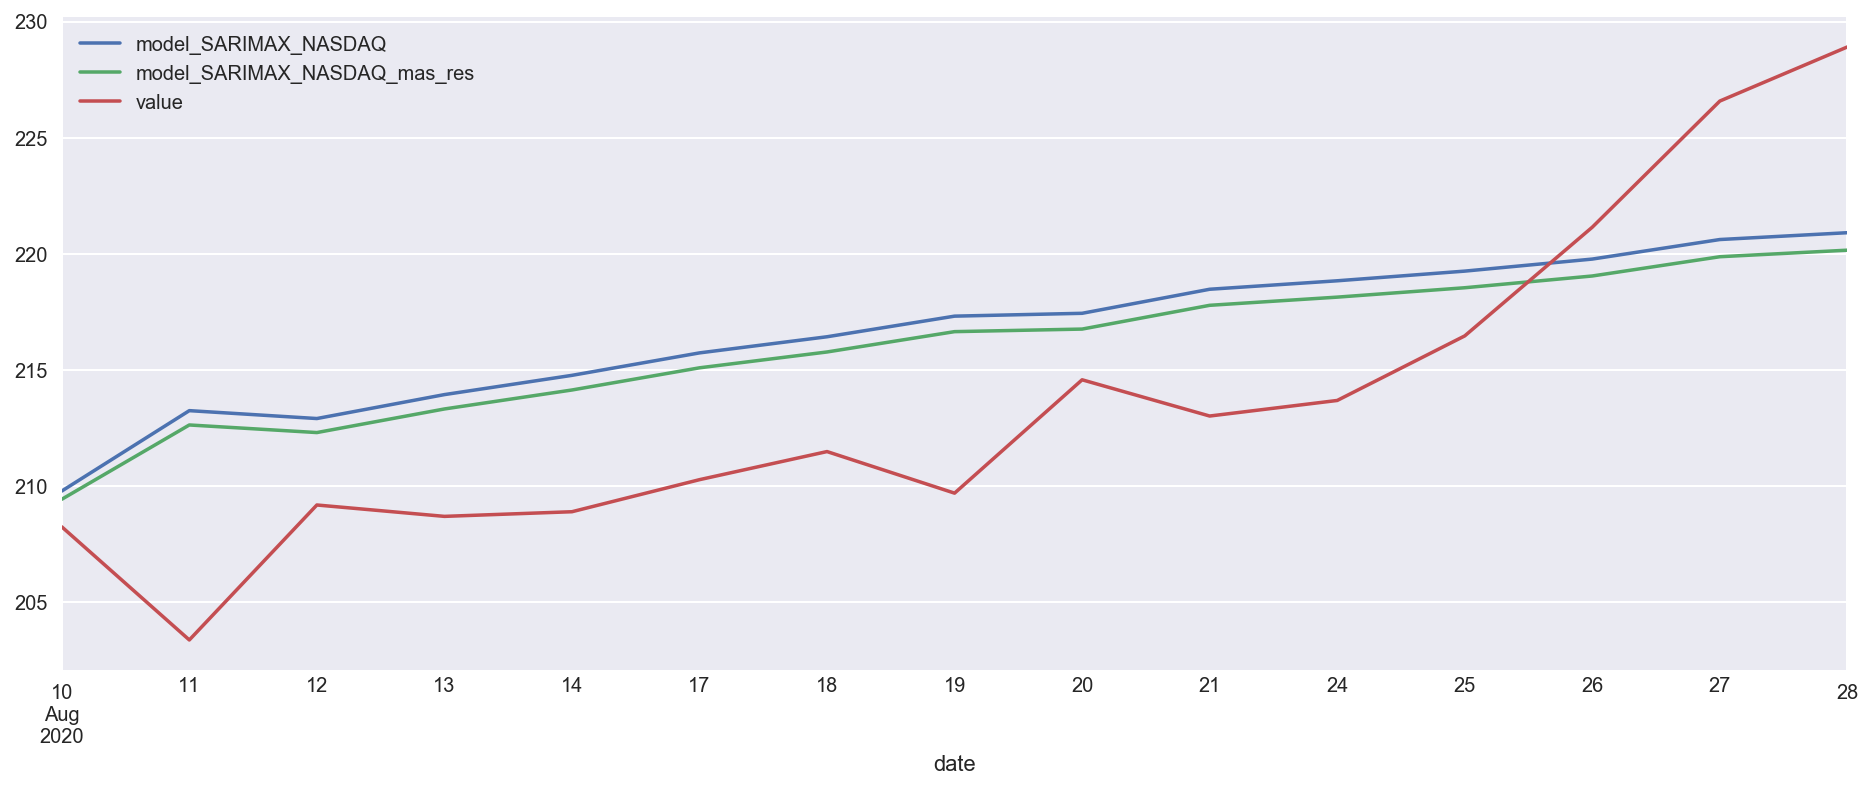

In [198]:
df_test.plot(kind = "line", y = ['model_SARIMAX_NASDAQ', 'model_SARIMAX_NASDAQ_mas_res', 'value'], figsize=(16, 6));

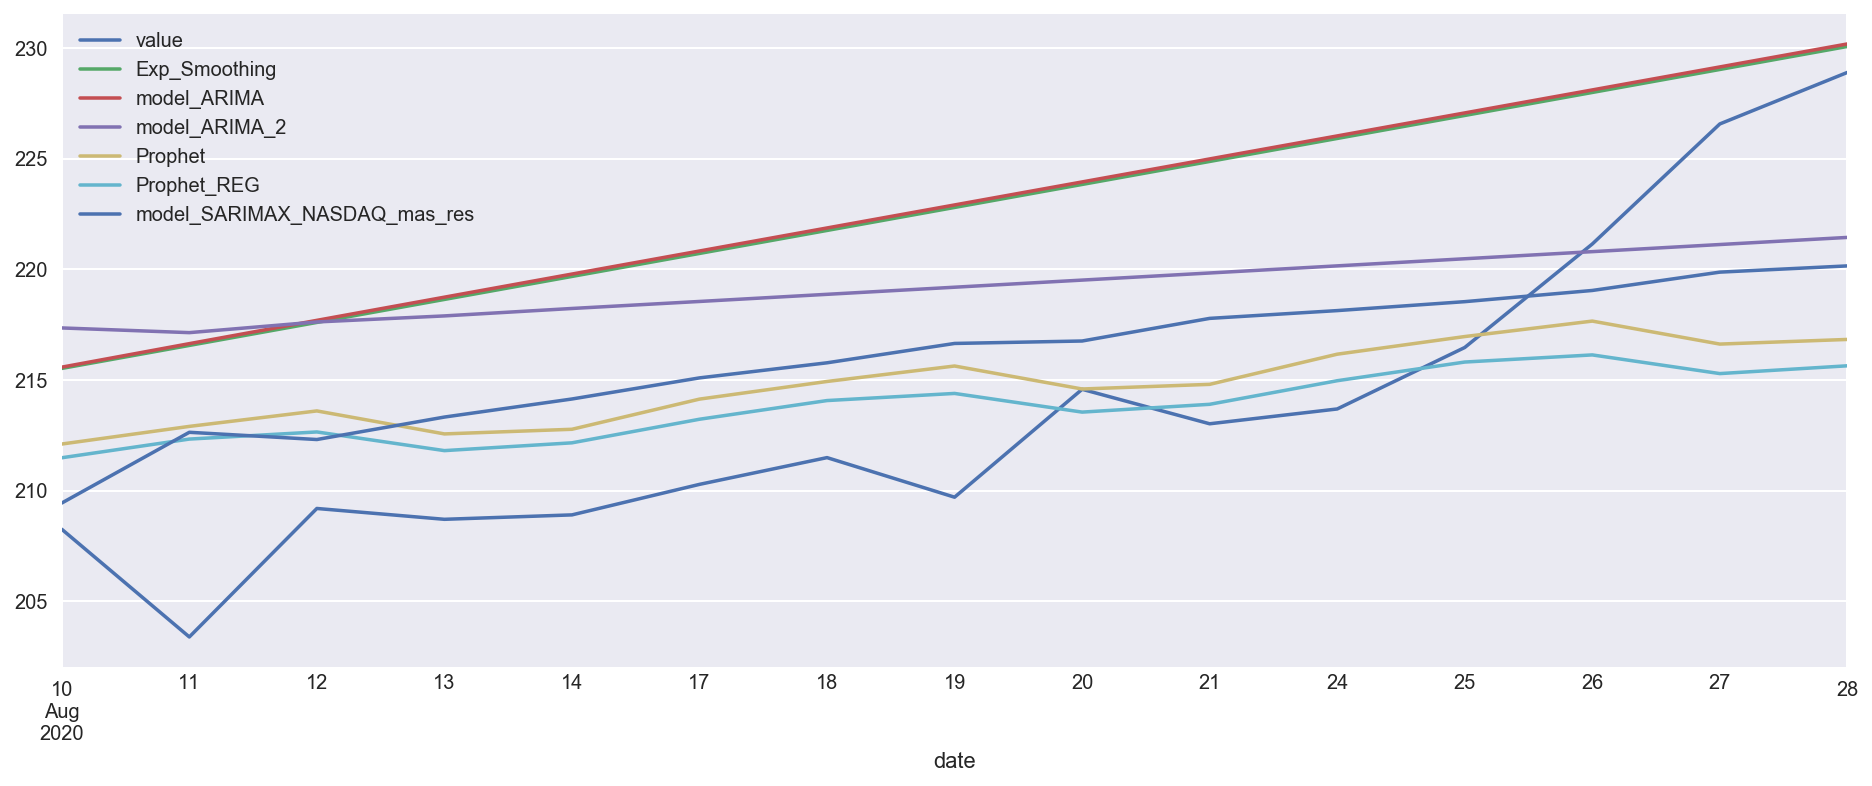

In [199]:
df_test.plot(kind="line", y = ["value", 'Exp_Smoothing', 'model_ARIMA',\
                               'model_ARIMA_2', 'Prophet', "Prophet_REG", 'model_SARIMAX_NASDAQ_mas_res'], figsize=(16, 6));